# Analyzing a spotify dataset

## Importing libs and reading CSV

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from IPython.display import display, HTML, clear_output

In [200]:
uploaded = files.upload()

Saving spotify_data.csv to spotify_data (2).csv


In [201]:
df = pd.read_csv('spotify_data.csv')

In [202]:
df.head()

,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0,True,Diplo,77,2812821,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.55
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0,True,Yelawolf,64,2363438,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,2025-10-31,1,single,3.07
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,4,True,Riff Raff,48,193302,NaN,3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,2025-10-31,1,single,2.55
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,30,True,Diplo,77,2813710,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.69
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0,True,Rumelis,48,8682,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,2025-10-30,2,single,2.39


## Understanding the dataset

### Does this dataset contains old songs, new songs or both?

In [203]:
# Transforming songs release date to datetime format

df['album_release_date'] = pd.to_datetime(df['album_release_date'])

In [204]:
# Visualizing the release year of the oldest and newest songs, and the  range between them

oldest_song_year = df.sort_values(by="album_release_date")['album_release_date'].dt.year.iloc[0]
newest_song_year = df.sort_values(by="album_release_date")['album_release_date'].dt.year.iloc[-1]
release_date_range = newest_song_year - oldest_song_year

display(HTML(f'The oldest song is from {oldest_song_year}.<br>The newest song is from {newest_song_year}.<br>The range is {release_date_range} years'))





**🎶 Therefore, the dataset contains both old and modern musics.**

### What's predominant, old or modern songs?

<Axes: xlabel='album_release_date', ylabel='Count'>

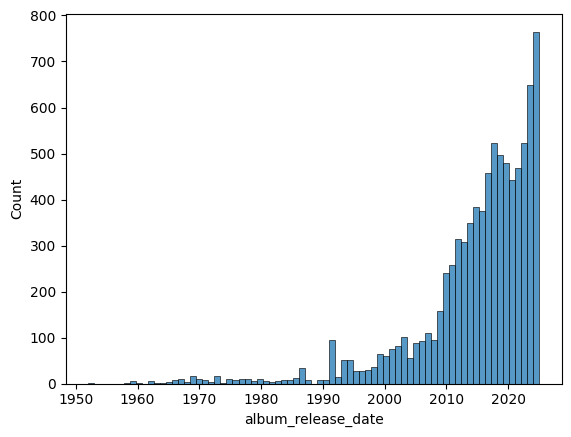

In [205]:
# Creating a histplot to visualize predominant release years

df['album_release_date'] = df['album_release_date'].dt.year
sns.histplot(df, x='album_release_date')

In [206]:
# Visualizing the number of songs per year
display(df['album_release_date'].value_counts().iloc[:10])

,count
album_release_date,
2025,765
2024,648
2023,523
2018,522
2019,496
2020,480
2022,468
2017,458
2021,443


In [207]:
# Calculating the average year of song release

mean_release_date = df['album_release_date'].mean()

display(f"The average release date of songs in this dataset is {mean_release_date:.0f}")

'The average release date of songs in this dataset is 2015'

**Most of the songs are from 2010 - 2020, so modern songs are predominant.**

### How can we measure the success of a track?

In [208]:
# We need to understand how to use the column 'track_popularity' to understand if a song is popular or not
# Maybe it could work as a rating or something? And what's the range of its values?

# Calculating the range
min_popularity = df['track_popularity'].min()
max_popularity = df['track_popularity'].max()
popularity_range = max_popularity - min_popularity

display(HTML(f'The max popularity is {max_popularity}.<br>The min popularity is {min_popularity}<br>The range of song popularity is {popularity_range}'))

So the popularity of tracks goes from 0 to 100.

With it, we can 'adapt' a rating from 0 to 10, just dividing the track's popularity by 10:

In [209]:
df['track_popularity'] /= 10
display((df.sort_values(by='track_popularity', ascending=False).iloc[:10]))


,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
457,1CPZ5BxNNd0n0nF4Orb9JS,Golden,4,9.9,False,HUNTR/X,87,3551538,k-pop,14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,3.24
88,3yWuTOYDztXjZxdE2cIRUa,Opalite,3,9.7,False,Taylor Swift,100,145443567,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.92
101,1jgTiNob5cVyXeJ3WgX5bL,Elizabeth Taylor,2,9.5,False,Taylor Swift,100,145489371,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.47
337,1qbmS6ep2hbBRaEZFpn7BX,Man I Need,1,9.5,False,Olivia Dean,88,1499215,pop soul,0Bv6OJO0L5gcf20DMww54a,Man I Need,2025,3,single,3.06
103,03bTIHJElXZ0O0jqOQvAbY,Father Figure,4,9.4,True,Taylor Swift,100,145542136,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.54
1134,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,4,9.4,False,Billie Eilish,90,118692183,"alternative pop, electropop, dark pop",7aJuG4TFXa2hmE4z1yxc3n,HIT ME HARD AND SOFT,2024,10,album,3.50
450,02sy7FAs8dkDNYsHp4Ul3f,Soda Pop,3,9.4,False,Saja Boys,80,2234812,NaN,14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,2.51
460,1I37Zz2g3hk9eWxaNkj031,Your Idol,7,9.3,False,Saja Boys,80,2234812,NaN,14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,3.19
93,2x3mwb96B6TquRqMtbxUE1,Actually Romantic,7,9.3,True,Taylor Swift,100,145396321,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,2.72
97,5ylJtmaWPJ33cW3En7WOu0,Wood,9,9.3,True,Taylor Swift,100,145443567,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,2.50


## Data Cleaning

In [210]:
# Checking the number of NaN values in the whole dataset

df.isna().sum()

,0
track_id,0
track_name,0
track_number,0
track_popularity,0
explicit,0
artist_name,3
artist_popularity,0
artist_followers,0
artist_genres,3361
album_id,0


**There are 3361 rows without artist genres**

🎯 **Goal: Read artist names via some Spotify API and get their genre(s)**

### Separating artists without genre

In [211]:
# Creating a separated df containing just the artists without genres and their number of followers
artists_without_genre = df[df['artist_genres'].isna()][['artist_name', 'artist_followers']]

# Selecting only artists with at least 10k followers
artists_without_genre = artists_without_genre[(artists_without_genre['artist_followers'] >= 10000)]

# Ordering by number of followers
artists_without_genre.sort_values(by='artist_followers', ascending=False, inplace=True)

display(artists_without_genre.tail())

,artist_name,artist_followers
355,Mandrazo,10272
1665,Prasewon,10229
5667,The Blue Notes,10148
620,Cloud,10130
3288,Olivia Herdt,10100


### Requesting Last.fm API

In [212]:
import requests

buffer = artists_without_genre['artist_name'].to_list()
artists_without_genre = []

In [215]:
# Removing duplicates
for artist in buffer:
  if artist not in artists_without_genre:
    artists_without_genre.append(artist)

buffer = []

# Setting URL and defining parameters
url = 'http://ws.audioscrobbler.com/2.0/'
params = {
    'method': 'artist.getinfo',
    'api_key': '548594b2115d6da3efd5d816a0916ef5',
    'format': 'json'
}


read_artist_genres = {}
genres_list = []
read = 0
total_artists_without_genre = len(artists_without_genre)

for artist in artists_without_genre:
  read += 1
  progress = (100 * read) / total_artists_without_genre
  display(f'{round(progress, 2)}% Done...')
  clear_output(wait=True)
  # display(f"Reading the artist {artist}")
  params['artist'] = artist

  response = requests.get(url, params=params)

  if response.status_code != 200:
    display('Artist not found or error')
    display(response.status_code)
    continue

  data = response.json()

  if 'artist' in data:
    for tags in data['artist']['tags']['tag']:
      # display(f'Artist: {artist} | Tag: {tags['name']}')
      genres_list.append(tags['name'])

  genres_list = ", ".join(genres_list).lower()
  if genres_list:
    read_artist_genres[artist] = genres_list
  genres_list = []


'0.1%...'

'Reading the artist Bruno Mars'

'Artist: Bruno Mars | Tag: pop'

'Artist: Bruno Mars | Tag: rnb'

'Artist: Bruno Mars | Tag: male vocalists'

'Artist: Bruno Mars | Tag: r&b'

'Artist: Bruno Mars | Tag: slow jams'

'0.2%...'

'Reading the artist Coldplay'

'Artist: Coldplay | Tag: rock'

'Artist: Coldplay | Tag: alternative'

'Artist: Coldplay | Tag: britpop'

'Artist: Coldplay | Tag: alternative rock'

'Artist: Coldplay | Tag: indie'

'0.3%...'

'Reading the artist Imagine Dragons'

'Artist: Imagine Dragons | Tag: indie'

'Artist: Imagine Dragons | Tag: indie rock'

'Artist: Imagine Dragons | Tag: alternative'

'Artist: Imagine Dragons | Tag: rock'

'Artist: Imagine Dragons | Tag: indie pop'

'0.4%...'

'Reading the artist Selena Gomez'

'Artist: Selena Gomez | Tag: pop'

'Artist: Selena Gomez | Tag: female vocalists'

'Artist: Selena Gomez | Tag: Disney'

'Artist: Selena Gomez | Tag: pop rock'

'Artist: Selena Gomez | Tag: dance'

'0.5%...'

'Reading the artist Shawn Mendes'

'Artist: Shawn Mendes | Tag: pop'

'Artist: Shawn Mendes | Tag: Canadian'

'Artist: Shawn Mendes | Tag: folk'

'Artist: Shawn Mendes | Tag: male vocalists'

'Artist: Shawn Mendes | Tag: acoustic'

'0.61%...'

'Reading the artist Alan Walker'

'Artist: Alan Walker | Tag: electronic'

'Artist: Alan Walker | Tag: House'

'Artist: Alan Walker | Tag: EDM'

'Artist: Alan Walker | Tag: dance'

'Artist: Alan Walker | Tag: norwegian'

'0.71%...'

'Reading the artist Beyoncé'

'Artist: Beyoncé | Tag: rnb'

'Artist: Beyoncé | Tag: pop'

'Artist: Beyoncé | Tag: female vocalists'

'Artist: Beyoncé | Tag: soul'

'Artist: Beyoncé | Tag: Hip-Hop'

'0.81%...'

'Reading the artist One Direction'

'Artist: One Direction | Tag: pop'

'Artist: One Direction | Tag: british'

'Artist: One Direction | Tag: boyband'

'Artist: One Direction | Tag: one direction'

'Artist: One Direction | Tag: X factor'

'0.91%...'

'Reading the artist Michael Jackson'

'Artist: Michael Jackson | Tag: pop'

'Artist: Michael Jackson | Tag: 80s'

'Artist: Michael Jackson | Tag: dance'

'Artist: Michael Jackson | Tag: soul'

'Artist: Michael Jackson | Tag: funk'

'1.01%...'

'Reading the artist Camila Cabello'

'Artist: Camila Cabello | Tag: pop'

'Artist: Camila Cabello | Tag: female vocalists'

'Artist: Camila Cabello | Tag: cuba'

'Artist: Camila Cabello | Tag: dance'

'Artist: Camila Cabello | Tag: cuban'

'1.11%...'

'Reading the artist Doja Cat'

'Artist: Doja Cat | Tag: pop'

'Artist: Doja Cat | Tag: rnb'

'Artist: Doja Cat | Tag: rap'

'Artist: Doja Cat | Tag: Hip-Hop'

'Artist: Doja Cat | Tag: hip hop'

'1.21%...'

'Reading the artist Nicki Minaj'

'Artist: Nicki Minaj | Tag: Hip-Hop'

'Artist: Nicki Minaj | Tag: rap'

'Artist: Nicki Minaj | Tag: rnb'

'Artist: Nicki Minaj | Tag: pop'

'Artist: Nicki Minaj | Tag: hip hop'

'1.31%...'

'Reading the artist Sia'

'Artist: Sia | Tag: female vocalists'

'Artist: Sia | Tag: indie'

'Artist: Sia | Tag: chillout'

'Artist: Sia | Tag: trip-hop'

'Artist: Sia | Tag: downtempo'

'1.41%...'

'Reading the artist Demi Lovato'

'Artist: Demi Lovato | Tag: pop'

'Artist: Demi Lovato | Tag: pop rock'

'Artist: Demi Lovato | Tag: female vocalists'

'Artist: Demi Lovato | Tag: Disney'

'Artist: Demi Lovato | Tag: guilty pleasure'

'1.51%...'

'Reading the artist Cardi B'

'Artist: Cardi B | Tag: Hip-Hop'

'Artist: Cardi B | Tag: rap'

'Artist: Cardi B | Tag: trap'

'Artist: Cardi B | Tag: hip hop'

'Artist: Cardi B | Tag: american'

'1.61%...'

'Reading the artist Twenty One Pilots'

'Artist: Twenty One Pilots | Tag: electronic'

'Artist: Twenty One Pilots | Tag: alternative'

'Artist: Twenty One Pilots | Tag: rap'

'Artist: Twenty One Pilots | Tag: indie pop'

'Artist: Twenty One Pilots | Tag: indie'

'1.72%...'

'Reading the artist Tyler, The Creator'

'Artist: Tyler, The Creator | Tag: Hip-Hop'

'Artist: Tyler, The Creator | Tag: rap'

'Artist: Tyler, The Creator | Tag: ofwgkta'

'Artist: Tyler, The Creator | Tag: underground hip-hop'

'Artist: Tyler, The Creator | Tag: swag'

'1.82%...'

'Reading the artist ZAYN'

'Artist: ZAYN | Tag: pop'

'Artist: ZAYN | Tag: rnb'

'Artist: ZAYN | Tag: british'

'Artist: ZAYN | Tag: male vocalists'

'Artist: ZAYN | Tag: sexy'

'1.92%...'

'Reading the artist 21 Savage'

'Artist: 21 Savage | Tag: trap'

'Artist: 21 Savage | Tag: Hip-Hop'

'Artist: 21 Savage | Tag: rap'

'Artist: 21 Savage | Tag: hip hop'

'Artist: 21 Savage | Tag: atlanta'

'2.02%...'

'Reading the artist Halsey'

'Artist: Halsey | Tag: pop'

'Artist: Halsey | Tag: indie pop'

'Artist: Halsey | Tag: indie'

'Artist: Halsey | Tag: alternative'

'Artist: Halsey | Tag: female vocalists'

'2.12%...'

'Reading the artist Melanie Martinez'

'Artist: Melanie Martinez | Tag: pop'

'Artist: Melanie Martinez | Tag: indie'

'Artist: Melanie Martinez | Tag: indie pop'

'Artist: Melanie Martinez | Tag: female vocalists'

'Artist: Melanie Martinez | Tag: alternative'

'2.22%...'

'Reading the artist Lil Baby'

'Artist: Lil Baby | Tag: rap'

'Artist: Lil Baby | Tag: Hip-Hop'

'Artist: Lil Baby | Tag: hip hop'

'Artist: Lil Baby | Tag: trap'

'Artist: Lil Baby | Tag: atlanta'

'2.32%...'

'Reading the artist The Neighbourhood'

'Artist: The Neighbourhood | Tag: indie'

'Artist: The Neighbourhood | Tag: indie rock'

'Artist: The Neighbourhood | Tag: indie pop'

'Artist: The Neighbourhood | Tag: rock'

'Artist: The Neighbourhood | Tag: alternative'

'2.42%...'

'Reading the artist The Chainsmokers'

'Artist: The Chainsmokers | Tag: electronic'

'Artist: The Chainsmokers | Tag: pop'

'Artist: The Chainsmokers | Tag: House'

'Artist: The Chainsmokers | Tag: electro house'

'Artist: The Chainsmokers | Tag: dance'

'2.52%...'

'Reading the artist Frank Ocean'

'Artist: Frank Ocean | Tag: rnb'

'Artist: Frank Ocean | Tag: soul'

'Artist: Frank Ocean | Tag: Hip-Hop'

'Artist: Frank Ocean | Tag: r&b'

'Artist: Frank Ocean | Tag: ofwgkta'

'2.62%...'

'Reading the artist P!nk'

'Artist: P!nk | Tag: pop'

'Artist: P!nk | Tag: pop rock'

'Artist: P!nk | Tag: female vocalists'

'Artist: P!nk | Tag: rock'

'Artist: P!nk | Tag: female'

'2.72%...'

'Reading the artist Khalid'

'Artist: Khalid | Tag: soul'

'Artist: Khalid | Tag: pop'

'Artist: Khalid | Tag: rnb'

'Artist: Khalid | Tag: alternative rnb'

'Artist: Khalid | Tag: alternative'

'2.83%...'

'Reading the artist Fifth Harmony'

'Artist: Fifth Harmony | Tag: pop'

'Artist: Fifth Harmony | Tag: female vocalists'

'Artist: Fifth Harmony | Tag: X factor'

'Artist: Fifth Harmony | Tag: american'

'Artist: Fifth Harmony | Tag: rnb'

'2.93%...'

'Reading the artist Justin Timberlake'

'Artist: Justin Timberlake | Tag: pop'

'Artist: Justin Timberlake | Tag: rnb'

'Artist: Justin Timberlake | Tag: dance'

'Artist: Justin Timberlake | Tag: male vocalists'

'Artist: Justin Timberlake | Tag: Hip-Hop'

'3.03%...'

'Reading the artist Meghan Trainor'

'Artist: Meghan Trainor | Tag: pop'

'Artist: Meghan Trainor | Tag: female vocalists'

'Artist: Meghan Trainor | Tag: soul'

'Artist: Meghan Trainor | Tag: american'

'Artist: Meghan Trainor | Tag: jazz'

'3.13%...'

'Reading the artist Elton John'

'Artist: Elton John | Tag: pop'

'Artist: Elton John | Tag: classic rock'

'Artist: Elton John | Tag: singer-songwriter'

'Artist: Elton John | Tag: rock'

'Artist: Elton John | Tag: piano'

'3.23%...'

'Reading the artist YoungBoy Never Broke Again'

'Artist: YoungBoy Never Broke Again | Tag: rap'

'Artist: YoungBoy Never Broke Again | Tag: trap'

'Artist: YoungBoy Never Broke Again | Tag: Hip-Hop'

'Artist: YoungBoy Never Broke Again | Tag: louisiana'

'Artist: YoungBoy Never Broke Again | Tag: Gangsta Rap'

'3.33%...'

'Reading the artist ABBA'

'Artist: ABBA | Tag: pop'

'Artist: ABBA | Tag: Disco'

'Artist: ABBA | Tag: 70s'

'Artist: ABBA | Tag: swedish'

'Artist: ABBA | Tag: 80s'

'3.43%...'

'Reading the artist Childish Gambino'

'Artist: Childish Gambino | Tag: Hip-Hop'

'Artist: Childish Gambino | Tag: rap'

'Artist: Childish Gambino | Tag: hip hop'

'Artist: Childish Gambino | Tag: indie'

'Artist: Childish Gambino | Tag: underground hip-hop'

'3.53%...'

'Reading the artist Gorillaz'

'Artist: Gorillaz | Tag: electronic'

'Artist: Gorillaz | Tag: alternative'

'Artist: Gorillaz | Tag: Hip-Hop'

'Artist: Gorillaz | Tag: rock'

'Artist: Gorillaz | Tag: indie'

'3.63%...'

'Reading the artist Jennifer Lopez'

'Artist: Jennifer Lopez | Tag: pop'

'Artist: Jennifer Lopez | Tag: rnb'

'Artist: Jennifer Lopez | Tag: latin'

'Artist: Jennifer Lopez | Tag: female vocalists'

'Artist: Jennifer Lopez | Tag: dance'

'3.73%...'

'Reading the artist Ellie Goulding'

'Artist: Ellie Goulding | Tag: electronic'

'Artist: Ellie Goulding | Tag: female vocalists'

'Artist: Ellie Goulding | Tag: british'

'Artist: Ellie Goulding | Tag: indie'

'Artist: Ellie Goulding | Tag: indie pop'

'3.83%...'

'Reading the artist Polo G'

'Artist: Polo G | Tag: rap'

'Artist: Polo G | Tag: Hip-Hop'

'Artist: Polo G | Tag: trap'

'Artist: Polo G | Tag: hip hop'

'Artist: Polo G | Tag: american'

'3.94%...'

'Reading the artist DaBaby'

'Artist: DaBaby | Tag: Hip-Hop'

'Artist: DaBaby | Tag: rap'

'Artist: DaBaby | Tag: trap'

'Artist: DaBaby | Tag: hip hop'

'Artist: DaBaby | Tag: american'

'4.04%...'

'Reading the artist Anne-Marie'

'Artist: Anne-Marie | Tag: pop'

'Artist: Anne-Marie | Tag: rnb'

'Artist: Anne-Marie | Tag: british'

'Artist: Anne-Marie | Tag: electronic'

'Artist: Anne-Marie | Tag: female vocalists'

'4.14%...'

'Reading the artist TV Girl'

'Artist: TV Girl | Tag: indie pop'

'Artist: TV Girl | Tag: Lo-Fi'

'Artist: TV Girl | Tag: indie'

'Artist: TV Girl | Tag: chillwave'

'Artist: TV Girl | Tag: pop'

'4.24%...'

'Reading the artist Kodak Black'

'Artist: Kodak Black | Tag: trap'

'Artist: Kodak Black | Tag: rap'

'Artist: Kodak Black | Tag: Hip-Hop'

'Artist: Kodak Black | Tag: hip hop'

'Artist: Kodak Black | Tag: florida'

'4.34%...'

'Reading the artist Jason Derulo'

'4.44%...'

'Reading the artist Conan Gray'

'Artist: Conan Gray | Tag: pop'

'Artist: Conan Gray | Tag: indie pop'

'Artist: Conan Gray | Tag: indie'

'Artist: Conan Gray | Tag: my top songs'

'Artist: Conan Gray | Tag: american'

'4.54%...'

'Reading the artist DJ Khaled'

'Artist: DJ Khaled | Tag: Hip-Hop'

'Artist: DJ Khaled | Tag: rap'

'Artist: DJ Khaled | Tag: hip hop'

'Artist: DJ Khaled | Tag: miami'

'Artist: DJ Khaled | Tag: djs'

'4.64%...'

'Reading the artist Little Mix'

'Artist: Little Mix | Tag: pop'

'Artist: Little Mix | Tag: british'

'Artist: Little Mix | Tag: female vocalists'

'Artist: Little Mix | Tag: Girl Groups'

'Artist: Little Mix | Tag: X factor'

'4.74%...'

'Reading the artist Lil Nas X'

'Artist: Lil Nas X | Tag: Hip-Hop'

'Artist: Lil Nas X | Tag: rap'

'Artist: Lil Nas X | Tag: pop'

'Artist: Lil Nas X | Tag: trap'

'Artist: Lil Nas X | Tag: country rap'

'4.84%...'

'Reading the artist Alessia Cara'

'Artist: Alessia Cara | Tag: pop'

'Artist: Alessia Cara | Tag: soul'

'Artist: Alessia Cara | Tag: rnb'

'Artist: Alessia Cara | Tag: Canadian'

'Artist: Alessia Cara | Tag: female vocalists'

'4.94%...'

'Reading the artist Jessie J'

'Artist: Jessie J | Tag: pop'

'Artist: Jessie J | Tag: british'

'Artist: Jessie J | Tag: female vocalists'

'Artist: Jessie J | Tag: rnb'

'Artist: Jessie J | Tag: singer-songwriter'

'5.05%...'

'Reading the artist Mac Miller'

'Artist: Mac Miller | Tag: Hip-Hop'

'Artist: Mac Miller | Tag: rap'

'Artist: Mac Miller | Tag: underground hip-hop'

'Artist: Mac Miller | Tag: hip hop'

'Artist: Mac Miller | Tag: pittsburgh'

'5.15%...'

'Reading the artist Avril Lavigne'

'Artist: Avril Lavigne | Tag: pop rock'

'Artist: Avril Lavigne | Tag: pop'

'Artist: Avril Lavigne | Tag: rock'

'Artist: Avril Lavigne | Tag: female vocalists'

'Artist: Avril Lavigne | Tag: Canadian'

'5.25%...'

'Reading the artist Pitbull'

'Artist: Pitbull | Tag: Hip-Hop'

'Artist: Pitbull | Tag: rap'

'Artist: Pitbull | Tag: Reggaeton'

'Artist: Pitbull | Tag: hip hop'

'Artist: Pitbull | Tag: Crunk'

'5.35%...'

'Reading the artist Metro Boomin'

'Artist: Metro Boomin | Tag: trap'

'Artist: Metro Boomin | Tag: rap'

'Artist: Metro Boomin | Tag: Hip-Hop'

'Artist: Metro Boomin | Tag: hip hop'

'Artist: Metro Boomin | Tag: Southern Hip Hop'

'5.45%...'

'Reading the artist Big Sean'

'Artist: Big Sean | Tag: Hip-Hop'

'Artist: Big Sean | Tag: rap'

'Artist: Big Sean | Tag: hip hop'

'Artist: Big Sean | Tag: good music'

'Artist: Big Sean | Tag: big sean'

'5.55%...'

'Reading the artist Daniel Caesar'

'Artist: Daniel Caesar | Tag: rnb'

'Artist: Daniel Caesar | Tag: soul'

'Artist: Daniel Caesar | Tag: Neo-Soul'

'Artist: Daniel Caesar | Tag: Canadian'

'Artist: Daniel Caesar | Tag: alternative rnb'

'5.65%...'

'Reading the artist Mitski'

'Artist: Mitski | Tag: indie rock'

'Artist: Mitski | Tag: indie'

'Artist: Mitski | Tag: indie pop'

'Artist: Mitski | Tag: singer-songwriter'

'Artist: Mitski | Tag: dream pop'

'5.75%...'

'Reading the artist Zara Larsson'

'Artist: Zara Larsson | Tag: pop'

'Artist: Zara Larsson | Tag: swedish'

'Artist: Zara Larsson | Tag: female vocalists'

'Artist: Zara Larsson | Tag: indie'

'Artist: Zara Larsson | Tag: Sweden'

'5.85%...'

'Reading the artist Lil Yachty'

'Artist: Lil Yachty | Tag: trap'

'Artist: Lil Yachty | Tag: rap'

'Artist: Lil Yachty | Tag: Hip-Hop'

'Artist: Lil Yachty | Tag: hip hop'

'Artist: Lil Yachty | Tag: Psychedelic Rock'

'5.95%...'

'Reading the artist Megan Thee Stallion'

'Artist: Megan Thee Stallion | Tag: rap'

'Artist: Megan Thee Stallion | Tag: Hip-Hop'

'Artist: Megan Thee Stallion | Tag: trap'

'Artist: Megan Thee Stallion | Tag: hip hop'

'Artist: Megan Thee Stallion | Tag: american'

'6.05%...'

'Reading the artist Joji'

'Artist: Joji | Tag: Lo-Fi'

'Artist: Joji | Tag: rnb'

'Artist: Joji | Tag: Hip-Hop'

'Artist: Joji | Tag: alternative rnb'

'Artist: Joji | Tag: japanese'

'6.16%...'

'Reading the artist Måneskin'

'Artist: Måneskin | Tag: rock'

'Artist: Måneskin | Tag: glam rock'

'Artist: Måneskin | Tag: italian'

'Artist: Måneskin | Tag: alternative rock'

'Artist: Måneskin | Tag: Italy'

'6.26%...'

'Reading the artist Lorde'

'Artist: Lorde | Tag: pop'

'Artist: Lorde | Tag: indie pop'

'Artist: Lorde | Tag: electronic'

'Artist: Lorde | Tag: indie'

'Artist: Lorde | Tag: New Zealand'

'6.36%...'

'Reading the artist Chase Atlantic'

'Artist: Chase Atlantic | Tag: rnb'

'Artist: Chase Atlantic | Tag: indie'

'Artist: Chase Atlantic | Tag: australian'

'Artist: Chase Atlantic | Tag: rock'

'Artist: Chase Atlantic | Tag: alternative'

'6.46%...'

'Reading the artist Selena Gomez & The Scene'

'Artist: Selena Gomez & The Scene | Tag: pop'

'Artist: Selena Gomez & The Scene | Tag: female vocalists'

'Artist: Selena Gomez & The Scene | Tag: pop rock'

'Artist: Selena Gomez & The Scene | Tag: Disney'

'Artist: Selena Gomez & The Scene | Tag: Selena Gomez'

'6.56%...'

'Reading the artist 5 Seconds of Summer'

'Artist: 5 Seconds of Summer | Tag: pop punk'

'Artist: 5 Seconds of Summer | Tag: pop rock'

'Artist: 5 Seconds of Summer | Tag: pop'

'Artist: 5 Seconds of Summer | Tag: australian'

'Artist: 5 Seconds of Summer | Tag: rock'

'6.66%...'

'Reading the artist Liam Payne'

'Artist: Liam Payne | Tag: pop'

'Artist: Liam Payne | Tag: rnb'

'Artist: Liam Payne | Tag: british'

'Artist: Liam Payne | Tag: male vocalists'

'Artist: Liam Payne | Tag: one direction'

'6.76%...'

'Reading the artist Niall Horan'

'Artist: Niall Horan | Tag: pop'

'Artist: Niall Horan | Tag: folk'

'Artist: Niall Horan | Tag: irish'

'Artist: Niall Horan | Tag: singer-songwriter'

'Artist: Niall Horan | Tag: male vocalists'

'6.86%...'

'Reading the artist Ne-Yo'

'Artist: Ne-Yo | Tag: rnb'

'Artist: Ne-Yo | Tag: soul'

'Artist: Ne-Yo | Tag: Hip-Hop'

'Artist: Ne-Yo | Tag: pop'

'Artist: Ne-Yo | Tag: Ne-Yo'

'6.96%...'

'Reading the artist NLE Choppa'

'Artist: NLE Choppa | Tag: trap'

'Artist: NLE Choppa | Tag: rap'

'Artist: NLE Choppa | Tag: Hip-Hop'

'Artist: NLE Choppa | Tag: hip hop'

'Artist: NLE Choppa | Tag: memphis'

'7.06%...'

'Reading the artist Nick Jonas'

'Artist: Nick Jonas | Tag: pop'

'Artist: Nick Jonas | Tag: pop rock'

'Artist: Nick Jonas | Tag: Disney'

'Artist: Nick Jonas | Tag: jonas brothers'

'Artist: Nick Jonas | Tag: male vocalists'

'7.16%...'

'Reading the artist Bebe Rexha'

'Artist: Bebe Rexha | Tag: pop'

'Artist: Bebe Rexha | Tag: female vocalists'

'Artist: Bebe Rexha | Tag: electronic'

'Artist: Bebe Rexha | Tag: singer-songwriter'

'Artist: Bebe Rexha | Tag: alternative'

'7.27%...'

'Reading the artist Amy Winehouse'

'Artist: Amy Winehouse | Tag: soul'

'Artist: Amy Winehouse | Tag: jazz'

'Artist: Amy Winehouse | Tag: female vocalists'

'Artist: Amy Winehouse | Tag: british'

'Artist: Amy Winehouse | Tag: singer-songwriter'

'7.37%...'

'Reading the artist Rod Wave'

'Artist: Rod Wave | Tag: rap'

'Artist: Rod Wave | Tag: trap'

'Artist: Rod Wave | Tag: Hip-Hop'

'Artist: Rod Wave | Tag: hip hop'

'Artist: Rod Wave | Tag: american'

'7.47%...'

'Reading the artist Black Eyed Peas'

'Artist: Black Eyed Peas | Tag: Hip-Hop'

'Artist: Black Eyed Peas | Tag: pop'

'Artist: Black Eyed Peas | Tag: rnb'

'Artist: Black Eyed Peas | Tag: rap'

'Artist: Black Eyed Peas | Tag: hip hop'

'7.57%...'

'Reading the artist Kali Uchis'

'Artist: Kali Uchis | Tag: rnb'

'Artist: Kali Uchis | Tag: Neo-Soul'

'Artist: Kali Uchis | Tag: soul'

'Artist: Kali Uchis | Tag: alternative rnb'

'Artist: Kali Uchis | Tag: pop'

'7.67%...'

'Reading the artist Troye Sivan'

'Artist: Troye Sivan | Tag: pop'

'Artist: Troye Sivan | Tag: indie pop'

'Artist: Troye Sivan | Tag: indie'

'Artist: Troye Sivan | Tag: male vocalists'

'Artist: Troye Sivan | Tag: electronic'

'7.77%...'

'Reading the artist DJ Snake'

'Artist: DJ Snake | Tag: trap'

'Artist: DJ Snake | Tag: electronic'

'Artist: DJ Snake | Tag: dance'

'Artist: DJ Snake | Tag: EDM'

'Artist: DJ Snake | Tag: french'

'7.87%...'

'Reading the artist Christina Aguilera'

'Artist: Christina Aguilera | Tag: pop'

'Artist: Christina Aguilera | Tag: female vocalists'

'Artist: Christina Aguilera | Tag: soul'

'Artist: Christina Aguilera | Tag: rnb'

'Artist: Christina Aguilera | Tag: dance'

'7.97%...'

'Reading the artist Kesha'

'8.07%...'

'Reading the artist Hozier'

'Artist: Hozier | Tag: blues'

'Artist: Hozier | Tag: indie'

'Artist: Hozier | Tag: soul'

'Artist: Hozier | Tag: singer-songwriter'

'Artist: Hozier | Tag: irish'

'8.17%...'

'Reading the artist Flo Rida'

'Artist: Flo Rida | Tag: Hip-Hop'

'Artist: Flo Rida | Tag: rap'

'Artist: Flo Rida | Tag: hip hop'

'Artist: Flo Rida | Tag: Dirty South'

'Artist: Flo Rida | Tag: southern rap'

'8.27%...'

'Reading the artist Hailee Steinfeld'

'Artist: Hailee Steinfeld | Tag: pop'

'Artist: Hailee Steinfeld | Tag: female vocalists'

'Artist: Hailee Steinfeld | Tag: dance'

'Artist: Hailee Steinfeld | Tag: teen pop'

'Artist: Hailee Steinfeld | Tag: american'

'8.38%...'

'Reading the artist The Script'

'Artist: The Script | Tag: pop rock'

'Artist: The Script | Tag: rock'

'Artist: The Script | Tag: irish'

'Artist: The Script | Tag: pop'

'Artist: The Script | Tag: acoustic'

'8.48%...'

'Reading the artist Madonna'

'Artist: Madonna | Tag: pop'

'Artist: Madonna | Tag: dance'

'Artist: Madonna | Tag: female vocalists'

'Artist: Madonna | Tag: 80s'

'Artist: Madonna | Tag: electronic'

'8.58%...'

'Reading the artist Kehlani'

'Artist: Kehlani | Tag: rnb'

'Artist: Kehlani | Tag: pop'

'Artist: Kehlani | Tag: soul'

'Artist: Kehlani | Tag: female vocalists'

'Artist: Kehlani | Tag: Hip-Hop'

'8.68%...'

'Reading the artist Madison Beer'

'Artist: Madison Beer | Tag: pop'

'Artist: Madison Beer | Tag: female vocalists'

'Artist: Madison Beer | Tag: rnb'

'Artist: Madison Beer | Tag: indie'

'Artist: Madison Beer | Tag: my top songs'

'8.78%...'

'Reading the artist Laufey'

'Artist: Laufey | Tag: jazz'

'Artist: Laufey | Tag: Bossa Nova'

'Artist: Laufey | Tag: pop'

'Artist: Laufey | Tag: female vocalists'

'Artist: Laufey | Tag: jazz pop'

'8.88%...'

'Reading the artist Rita Ora'

'Artist: Rita Ora | Tag: pop'

'Artist: Rita Ora | Tag: dance'

'Artist: Rita Ora | Tag: female vocalists'

'Artist: Rita Ora | Tag: rnb'

'Artist: Rita Ora | Tag: british'

'8.98%...'

'Reading the artist Tory Lanez'

'Artist: Tory Lanez | Tag: rnb'

'Artist: Tory Lanez | Tag: Hip-Hop'

'Artist: Tory Lanez | Tag: rap'

'Artist: Tory Lanez | Tag: Canadian'

'Artist: Tory Lanez | Tag: trap'

'9.08%...'

"Reading the artist Destiny's Child"

"Artist: Destiny's Child | Tag: rnb"

"Artist: Destiny's Child | Tag: pop"

"Artist: Destiny's Child | Tag: female vocalists"

"Artist: Destiny's Child | Tag: soul"

"Artist: Destiny's Child | Tag: Hip-Hop"

'9.18%...'

'Reading the artist Quavo'

'Artist: Quavo | Tag: rap'

'Artist: Quavo | Tag: Hip-Hop'

'Artist: Quavo | Tag: trap'

'Artist: Quavo | Tag: atlanta'

'Artist: Quavo | Tag: migos'

'9.28%...'

'Reading the artist The 1975'

'Artist: The 1975 | Tag: indie'

'Artist: The 1975 | Tag: indie rock'

'Artist: The 1975 | Tag: british'

'Artist: The 1975 | Tag: alternative'

'Artist: The 1975 | Tag: rock'

'9.38%...'

'Reading the artist Rae Sremmurd'

'Artist: Rae Sremmurd | Tag: Hip-Hop'

'Artist: Rae Sremmurd | Tag: rap'

'Artist: Rae Sremmurd | Tag: hip hop'

'Artist: Rae Sremmurd | Tag: trap'

'Artist: Rae Sremmurd | Tag: urban'

'9.49%...'

'Reading the artist Jonas Brothers'

'Artist: Jonas Brothers | Tag: pop'

'Artist: Jonas Brothers | Tag: pop rock'

'Artist: Jonas Brothers | Tag: Disney'

'Artist: Jonas Brothers | Tag: rock'

'Artist: Jonas Brothers | Tag: pop punk'

'9.59%...'

'Reading the artist Ava Max'

'Artist: Ava Max | Tag: pop'

'Artist: Ava Max | Tag: electropop'

'Artist: Ava Max | Tag: female vocalists'

'Artist: Ava Max | Tag: american'

'Artist: Ava Max | Tag: USA'

'9.69%...'

'Reading the artist Kid Cudi'

'Artist: Kid Cudi | Tag: Hip-Hop'

'Artist: Kid Cudi | Tag: rap'

'Artist: Kid Cudi | Tag: alternative rap'

'Artist: Kid Cudi | Tag: hip hop'

'Artist: Kid Cudi | Tag: House'

'9.79%...'

'Reading the artist Lil Pump'

'Artist: Lil Pump | Tag: Hip-Hop'

'Artist: Lil Pump | Tag: trap'

'Artist: Lil Pump | Tag: rap'

'Artist: Lil Pump | Tag: mumble rap'

'Artist: Lil Pump | Tag: florida'

'9.89%...'

'Reading the artist The Police'

'Artist: The Police | Tag: rock'

'Artist: The Police | Tag: new wave'

'Artist: The Police | Tag: classic rock'

'Artist: The Police | Tag: 80s'

'Artist: The Police | Tag: pop'

'9.99%...'

'Reading the artist Don Toliver'

'Artist: Don Toliver | Tag: rap'

'Artist: Don Toliver | Tag: trap'

'Artist: Don Toliver | Tag: Hip-Hop'

'Artist: Don Toliver | Tag: rnb'

'Artist: Don Toliver | Tag: texas'

'10.09%...'

'Reading the artist Gracie Abrams'

'Artist: Gracie Abrams | Tag: pop'

'Artist: Gracie Abrams | Tag: indie pop'

'Artist: Gracie Abrams | Tag: my top songs'

'Artist: Gracie Abrams | Tag: indie'

'Artist: Gracie Abrams | Tag: female vocalists'

'10.19%...'

'Reading the artist Ciara'

'Artist: Ciara | Tag: rnb'

'Artist: Ciara | Tag: pop'

'Artist: Ciara | Tag: Hip-Hop'

'Artist: Ciara | Tag: female vocalists'

'Artist: Ciara | Tag: dance'

'10.29%...'

'Reading the artist Bruce Springsteen'

'Artist: Bruce Springsteen | Tag: rock'

'Artist: Bruce Springsteen | Tag: classic rock'

'Artist: Bruce Springsteen | Tag: singer-songwriter'

'Artist: Bruce Springsteen | Tag: folk'

'Artist: Bruce Springsteen | Tag: 80s'

'10.39%...'

'Reading the artist Tyga'

'Artist: Tyga | Tag: Hip-Hop'

'Artist: Tyga | Tag: rap'

'Artist: Tyga | Tag: hip hop'

'Artist: Tyga | Tag: tyga'

'Artist: Tyga | Tag: west coast'

'10.49%...'

'Reading the artist Chappell Roan'

'Artist: Chappell Roan | Tag: pop'

'Artist: Chappell Roan | Tag: indie pop'

'Artist: Chappell Roan | Tag: synthpop'

'Artist: Chappell Roan | Tag: electropop'

'Artist: Chappell Roan | Tag: queer'

'10.6%...'

'Reading the artist Jeremih'

'Artist: Jeremih | Tag: rnb'

'Artist: Jeremih | Tag: Hip-Hop'

'Artist: Jeremih | Tag: soul'

'Artist: Jeremih | Tag: hip hop'

'Artist: Jeremih | Tag: r&b'

'10.7%...'

'Reading the artist Louis Tomlinson'

'Artist: Louis Tomlinson | Tag: pop'

'Artist: Louis Tomlinson | Tag: pop rock'

'Artist: Louis Tomlinson | Tag: british'

'Artist: Louis Tomlinson | Tag: indie'

'Artist: Louis Tomlinson | Tag: indie rock'

'10.8%...'

'Reading the artist Gwen Stefani'

'Artist: Gwen Stefani | Tag: pop'

'Artist: Gwen Stefani | Tag: female vocalists'

'Artist: Gwen Stefani | Tag: dance'

'Artist: Gwen Stefani | Tag: rock'

'Artist: Gwen Stefani | Tag: alternative'

'10.9%...'

'Reading the artist Benson Boone'

'Artist: Benson Boone | Tag: pop'

'Artist: Benson Boone | Tag: rock'

'Artist: Benson Boone | Tag: pop rock'

'Artist: Benson Boone | Tag: my top songs'

'Artist: Benson Boone | Tag: USA'

'11.0%...'

'Reading the artist Lauv'

'Artist: Lauv | Tag: pop'

'Artist: Lauv | Tag: indie pop'

'Artist: Lauv | Tag: indie'

'Artist: Lauv | Tag: american'

'Artist: Lauv | Tag: jazz'

'11.1%...'

'Reading the artist Kevin Gates'

'Artist: Kevin Gates | Tag: Hip-Hop'

'Artist: Kevin Gates | Tag: rap'

'Artist: Kevin Gates | Tag: trap'

'Artist: Kevin Gates | Tag: All'

'Artist: Kevin Gates | Tag: underground hip-hop'

'11.2%...'

'Reading the artist Backstreet Boys'

'Artist: Backstreet Boys | Tag: pop'

'Artist: Backstreet Boys | Tag: boybands'

'Artist: Backstreet Boys | Tag: 90s'

'Artist: Backstreet Boys | Tag: dance'

'Artist: Backstreet Boys | Tag: backstreet boys'

'11.3%...'

'Reading the artist Iggy Azalea'

'Artist: Iggy Azalea | Tag: Hip-Hop'

'Artist: Iggy Azalea | Tag: rap'

'Artist: Iggy Azalea | Tag: pop'

'Artist: Iggy Azalea | Tag: hip hop'

'Artist: Iggy Azalea | Tag: australia'

'11.4%...'

'Reading the artist The Kid LAROI'

'Artist: The Kid LAROI | Tag: rap'

'Artist: The Kid LAROI | Tag: Hip-Hop'

'Artist: The Kid LAROI | Tag: emo rap'

'Artist: The Kid LAROI | Tag: australian'

'Artist: The Kid LAROI | Tag: trap'

'11.5%...'

'Reading the artist Steve Lacy'

'Artist: Steve Lacy | Tag: free jazz'

'Artist: Steve Lacy | Tag: jazz'

'Artist: Steve Lacy | Tag: saxophone'

'Artist: Steve Lacy | Tag: rnb'

'Artist: Steve Lacy | Tag: Avant-Garde Jazz'

'11.6%...'

'Reading the artist Quevedo'

'Artist: Quevedo | Tag: Reggaeton'

'Artist: Quevedo | Tag: rap'

'Artist: Quevedo | Tag: spanish'

'Artist: Quevedo | Tag: Hip-Hop'

'Artist: Quevedo | Tag: hip hop'

'11.71%...'

'Reading the artist G-Eazy'

'Artist: G-Eazy | Tag: Hip-Hop'

'Artist: G-Eazy | Tag: rap'

'Artist: G-Eazy | Tag: hip hop'

'Artist: G-Eazy | Tag: american'

'Artist: G-Eazy | Tag: The Cool Kids'

'11.81%...'

'Reading the artist The Pussycat Dolls'

'Artist: The Pussycat Dolls | Tag: pop'

'Artist: The Pussycat Dolls | Tag: rnb'

'Artist: The Pussycat Dolls | Tag: dance'

'Artist: The Pussycat Dolls | Tag: female vocalists'

'Artist: The Pussycat Dolls | Tag: Hip-Hop'

'11.91%...'

'Reading the artist Fergie'

'Artist: Fergie | Tag: pop'

'Artist: Fergie | Tag: rnb'

'Artist: Fergie | Tag: female vocalists'

'Artist: Fergie | Tag: Hip-Hop'

'Artist: Fergie | Tag: dance'

'12.01%...'

'Reading the artist Logic'

'Artist: Logic | Tag: Hip-Hop'

'Artist: Logic | Tag: rap'

'Artist: Logic | Tag: hip hop'

'Artist: Logic | Tag: biracial'

'Artist: Logic | Tag: electronic'

'12.11%...'

'Reading the artist MARINA'

'Artist: MARINA | Tag: pop'

'Artist: MARINA | Tag: female vocalists'

'Artist: MARINA | Tag: indie pop'

'Artist: MARINA | Tag: post-hardcore'

'Artist: MARINA | Tag: polish'

'12.21%...'

'Reading the artist Ski Mask The Slump God'

'Artist: Ski Mask The Slump God | Tag: trap'

'Artist: Ski Mask The Slump God | Tag: Hip-Hop'

'Artist: Ski Mask The Slump God | Tag: rap'

'Artist: Ski Mask The Slump God | Tag: hip hop'

'Artist: Ski Mask The Slump God | Tag: florida'

'12.31%...'

'Reading the artist Chance the Rapper'

'Artist: Chance the Rapper | Tag: Hip-Hop'

'Artist: Chance the Rapper | Tag: rap'

'Artist: Chance the Rapper | Tag: hip hop'

'Artist: Chance the Rapper | Tag: chicago'

'Artist: Chance the Rapper | Tag: jazz rap'

'12.41%...'

'Reading the artist Akon'

'Artist: Akon | Tag: rnb'

'Artist: Akon | Tag: Hip-Hop'

'Artist: Akon | Tag: rap'

'Artist: Akon | Tag: pop'

'Artist: Akon | Tag: hip hop'

'12.51%...'

'Reading the artist Clean Bandit'

'Artist: Clean Bandit | Tag: electronic'

'Artist: Clean Bandit | Tag: indie'

'Artist: Clean Bandit | Tag: experimental'

'Artist: Clean Bandit | Tag: british'

'Artist: Clean Bandit | Tag: electronica'

'12.61%...'

'Reading the artist The Vamps'

'Artist: The Vamps | Tag: pop'

'Artist: The Vamps | Tag: british'

'Artist: The Vamps | Tag: pop rock'

'Artist: The Vamps | Tag: indie'

'Artist: The Vamps | Tag: acoustic'

'12.71%...'

'Reading the artist French Montana'

'Artist: French Montana | Tag: Hip-Hop'

'Artist: French Montana | Tag: rap'

'Artist: French Montana | Tag: hip hop'

'Artist: French Montana | Tag: trap'

'Artist: French Montana | Tag: trap rap'

'12.82%...'

'Reading the artist JVKE'

'Artist: JVKE | Tag: pop'

'Artist: JVKE | Tag: indie pop'

'Artist: JVKE | Tag: indie'

'Artist: JVKE | Tag: my top songs'

'Artist: JVKE | Tag: american'

'12.92%...'

'Reading the artist Kings of Leon'

'Artist: Kings of Leon | Tag: rock'

'Artist: Kings of Leon | Tag: indie'

'Artist: Kings of Leon | Tag: indie rock'

'Artist: Kings of Leon | Tag: alternative'

'Artist: Kings of Leon | Tag: Southern Rock'

'13.02%...'

'Reading the artist Lizzo'

'Artist: Lizzo | Tag: pop'

'Artist: Lizzo | Tag: Hip-Hop'

'Artist: Lizzo | Tag: rnb'

'Artist: Lizzo | Tag: hip hop'

'Artist: Lizzo | Tag: rap'

'13.12%...'

'Reading the artist Teddy Swims'

'Artist: Teddy Swims | Tag: soul'

'Artist: Teddy Swims | Tag: singer-songwriter'

'Artist: Teddy Swims | Tag: rnb'

'Artist: Teddy Swims | Tag: pop'

'Artist: Teddy Swims | Tag: Neo-Soul'

'13.22%...'

'Reading the artist George Michael'

'Artist: George Michael | Tag: pop'

'Artist: George Michael | Tag: 80s'

'Artist: George Michael | Tag: british'

'Artist: George Michael | Tag: soul'

'Artist: George Michael | Tag: dance'

'13.32%...'

'Reading the artist Bastille'

'Artist: Bastille | Tag: indie'

'Artist: Bastille | Tag: electronic'

'Artist: Bastille | Tag: alternative'

'Artist: Bastille | Tag: british'

'Artist: Bastille | Tag: House'

'13.42%...'

'Reading the artist mgk'

'Artist: mgk | Tag: rap'

'Artist: mgk | Tag: Hip-Hop'

'Artist: mgk | Tag: pop punk'

'Artist: mgk | Tag: hip hop'

'Artist: mgk | Tag: Cleveland'

'13.52%...'

'Reading the artist Offset'

'Artist: Offset | Tag: trap'

'Artist: Offset | Tag: rap'

'Artist: Offset | Tag: Hip-Hop'

'Artist: Offset | Tag: travis scott'

'Artist: Offset | Tag: hip hop'

'13.62%...'

'Reading the artist Alec Benjamin'

'Artist: Alec Benjamin | Tag: pop'

'Artist: Alec Benjamin | Tag: indie pop'

'Artist: Alec Benjamin | Tag: american'

'Artist: Alec Benjamin | Tag: indie'

'Artist: Alec Benjamin | Tag: male vocalists'

'13.72%...'

'Reading the artist Dove Cameron'

'Artist: Dove Cameron | Tag: pop'

'Artist: Dove Cameron | Tag: Disney'

'Artist: Dove Cameron | Tag: female vocalists'

'Artist: Dove Cameron | Tag: american'

'Artist: Dove Cameron | Tag: my top songs'

'13.82%...'

'Reading the artist Russ'

'Artist: Russ | Tag: Hip-Hop'

'Artist: Russ | Tag: rap'

'Artist: Russ | Tag: rnb'

'Artist: Russ | Tag: hip hop'

'Artist: Russ | Tag: russ'

'13.93%...'

'Reading the artist Bazzi'

'Artist: Bazzi | Tag: rnb'

'Artist: Bazzi | Tag: pop'

'Artist: Bazzi | Tag: american'

'Artist: Bazzi | Tag: singer-songwriter'

'Artist: Bazzi | Tag: male vocalists'

'14.03%...'

'Reading the artist The Cranberries'

'Artist: The Cranberries | Tag: rock'

'Artist: The Cranberries | Tag: alternative'

'Artist: The Cranberries | Tag: alternative rock'

'Artist: The Cranberries | Tag: female vocalists'

'Artist: The Cranberries | Tag: irish'

'14.13%...'

'Reading the artist Pharrell Williams'

'Artist: Pharrell Williams | Tag: Hip-Hop'

'Artist: Pharrell Williams | Tag: rnb'

'Artist: Pharrell Williams | Tag: rap'

'Artist: Pharrell Williams | Tag: hip hop'

'Artist: Pharrell Williams | Tag: pop'

'14.23%...'

'Reading the artist Julia Michaels'

'Artist: Julia Michaels | Tag: pop'

'Artist: Julia Michaels | Tag: singer-songwriter'

'Artist: Julia Michaels | Tag: female vocalists'

'Artist: Julia Michaels | Tag: my top songs'

'Artist: Julia Michaels | Tag: american'

'14.33%...'

'Reading the artist Carly Rae Jepsen'

'Artist: Carly Rae Jepsen | Tag: pop'

'Artist: Carly Rae Jepsen | Tag: Canadian'

'Artist: Carly Rae Jepsen | Tag: female vocalists'

'Artist: Carly Rae Jepsen | Tag: folk'

'Artist: Carly Rae Jepsen | Tag: acoustic'

'14.43%...'

'Reading the artist Fetty Wap'

'Artist: Fetty Wap | Tag: Hip-Hop'

'Artist: Fetty Wap | Tag: rap'

'Artist: Fetty Wap | Tag: trap'

'Artist: Fetty Wap | Tag: rnb'

'Artist: Fetty Wap | Tag: hip hop'

'14.53%...'

'Reading the artist Sade'

'Artist: Sade | Tag: soul'

'Artist: Sade | Tag: jazz'

'Artist: Sade | Tag: female vocalists'

'Artist: Sade | Tag: chillout'

'Artist: Sade | Tag: pop'

'14.63%...'

'Reading the artist blackbear'

'Artist: blackbear | Tag: electronic'

'Artist: blackbear | Tag: pop'

'Artist: blackbear | Tag: hip hop'

'Artist: blackbear | Tag: Hip-Hop'

'Artist: blackbear | Tag: rnb'

'14.73%...'

'Reading the artist ScHoolboy Q'

'Artist: ScHoolboy Q | Tag: Hip-Hop'

'Artist: ScHoolboy Q | Tag: rap'

'Artist: ScHoolboy Q | Tag: underground hip-hop'

'Artist: ScHoolboy Q | Tag: West Coast Rap'

'Artist: ScHoolboy Q | Tag: hip hop'

'14.83%...'

'Reading the artist Ice Spice'

'Artist: Ice Spice | Tag: rap'

'Artist: Ice Spice | Tag: drill'

'Artist: Ice Spice | Tag: Hip-Hop'

'Artist: Ice Spice | Tag: trap'

'Artist: Ice Spice | Tag: mother'

'14.93%...'

'Reading the artist Bryan Adams'

'Artist: Bryan Adams | Tag: rock'

'Artist: Bryan Adams | Tag: classic rock'

'Artist: Bryan Adams | Tag: 80s'

'Artist: Bryan Adams | Tag: pop'

'Artist: Bryan Adams | Tag: Canadian'

'15.04%...'

'Reading the artist Nelly Furtado'

'Artist: Nelly Furtado | Tag: pop'

'Artist: Nelly Furtado | Tag: female vocalists'

'Artist: Nelly Furtado | Tag: folk'

'Artist: Nelly Furtado | Tag: Canadian'

'Artist: Nelly Furtado | Tag: singer-songwriter'

'15.14%...'

'Reading the artist d4vd'

'Artist: d4vd | Tag: pop'

'Artist: d4vd | Tag: rnb'

'Artist: d4vd | Tag: dream pop'

'Artist: d4vd | Tag: rock'

'Artist: d4vd | Tag: indie pop'

'15.24%...'

'Reading the artist DNCE'

'Artist: DNCE | Tag: pop'

'Artist: DNCE | Tag: pop rock'

'Artist: DNCE | Tag: dance'

'Artist: DNCE | Tag: funk'

'Artist: DNCE | Tag: american'

'15.34%...'

'Reading the artist Glass Animals'

'Artist: Glass Animals | Tag: electronic'

'Artist: Glass Animals | Tag: trip-hop'

'Artist: Glass Animals | Tag: indie'

'Artist: Glass Animals | Tag: british'

'Artist: Glass Animals | Tag: dubstep'

'15.44%...'

'Reading the artist Mother Mother'

'Artist: Mother Mother | Tag: indie'

'Artist: Mother Mother | Tag: Canadian'

'Artist: Mother Mother | Tag: indie pop'

'Artist: Mother Mother | Tag: experimental'

'Artist: Mother Mother | Tag: folk'

'15.54%...'

'Reading the artist Ruth B.'

'Artist: Ruth B. | Tag: pop'

'Artist: Ruth B. | Tag: rnb'

'Artist: Ruth B. | Tag: piano'

'Artist: Ruth B. | Tag: Canadian'

'Artist: Ruth B. | Tag: my top songs'

'15.64%...'

'Reading the artist LMFAO'

'Artist: LMFAO | Tag: electronic'

'Artist: LMFAO | Tag: Hip-Hop'

'Artist: LMFAO | Tag: electro'

'Artist: LMFAO | Tag: Crunk'

'Artist: LMFAO | Tag: hip hop'

'15.74%...'

'Reading the artist will.i.am'

'Artist: will.i.am | Tag: Hip-Hop'

'Artist: will.i.am | Tag: rap'

'Artist: will.i.am | Tag: rnb'

'Artist: will.i.am | Tag: funk'

'Artist: will.i.am | Tag: hip hop'

'15.84%...'

'Reading the artist Noah Kahan'

'Artist: Noah Kahan | Tag: indie'

'Artist: Noah Kahan | Tag: folk'

'Artist: Noah Kahan | Tag: singer-songwriter'

'Artist: Noah Kahan | Tag: acoustic'

'Artist: Noah Kahan | Tag: indie folk'

'15.94%...'

'Reading the artist Jack Harlow'

'Artist: Jack Harlow | Tag: rap'

'Artist: Jack Harlow | Tag: Hip-Hop'

'Artist: Jack Harlow | Tag: trap'

'Artist: Jack Harlow | Tag: hip hop'

'Artist: Jack Harlow | Tag: pop rap'

'16.04%...'

'Reading the artist George Ezra'

'Artist: George Ezra | Tag: indie'

'Artist: George Ezra | Tag: folk'

'Artist: George Ezra | Tag: singer-songwriter'

'Artist: George Ezra | Tag: british'

'Artist: George Ezra | Tag: indie folk'

'16.15%...'

'Reading the artist Tom Odell'

'Artist: Tom Odell | Tag: indie'

'Artist: Tom Odell | Tag: folk'

'Artist: Tom Odell | Tag: british'

'Artist: Tom Odell | Tag: singer-songwriter'

'Artist: Tom Odell | Tag: piano'

'16.25%...'

'Reading the artist Cage The Elephant'

'Artist: Cage The Elephant | Tag: indie rock'

'Artist: Cage The Elephant | Tag: alternative'

'Artist: Cage The Elephant | Tag: rock'

'Artist: Cage The Elephant | Tag: indie'

'Artist: Cage The Elephant | Tag: punk rock'

'16.35%...'

'Reading the artist The Fray'

'Artist: The Fray | Tag: alternative'

'Artist: The Fray | Tag: rock'

'Artist: The Fray | Tag: piano rock'

'Artist: The Fray | Tag: alternative rock'

'Artist: The Fray | Tag: indie'

'16.45%...'

'Reading the artist Wale'

'Artist: Wale | Tag: Hip-Hop'

'Artist: Wale | Tag: rap'

'Artist: Wale | Tag: hip hop'

'Artist: Wale | Tag: DC'

'Artist: Wale | Tag: Go-Go'

'16.55%...'

'Reading the artist Spice Girls'

'Artist: Spice Girls | Tag: pop'

'Artist: Spice Girls | Tag: 90s'

'Artist: Spice Girls | Tag: british'

'Artist: Spice Girls | Tag: female vocalists'

'Artist: Spice Girls | Tag: dance'

'16.65%...'

'Reading the artist Dean Lewis'

'Artist: Dean Lewis | Tag: indie'

'Artist: Dean Lewis | Tag: pop'

'Artist: Dean Lewis | Tag: australian'

'Artist: Dean Lewis | Tag: singer-songwriter'

'Artist: Dean Lewis | Tag: alternative'

'16.75%...'

'Reading the artist James Bay'

'Artist: James Bay | Tag: folk'

'Artist: James Bay | Tag: indie'

'Artist: James Bay | Tag: singer-songwriter'

'Artist: James Bay | Tag: british'

'Artist: James Bay | Tag: indie pop'

'16.85%...'

'Reading the artist Foster The People'

'Artist: Foster The People | Tag: indie'

'Artist: Foster The People | Tag: indie pop'

'Artist: Foster The People | Tag: alternative'

'Artist: Foster The People | Tag: american'

'Artist: Foster The People | Tag: indie rock'

'16.95%...'

'Reading the artist Thirty Seconds To Mars'

'17.05%...'

'Reading the artist Bon Iver'

'Artist: Bon Iver | Tag: folk'

'Artist: Bon Iver | Tag: indie'

'Artist: Bon Iver | Tag: singer-songwriter'

'Artist: Bon Iver | Tag: acoustic'

'Artist: Bon Iver | Tag: Lo-Fi'

'17.15%...'

'Reading the artist Keane'

'Artist: Keane | Tag: britpop'

'Artist: Keane | Tag: indie'

'Artist: Keane | Tag: british'

'Artist: Keane | Tag: alternative'

'Artist: Keane | Tag: rock'

'17.26%...'

'Reading the artist Santana'

'Artist: Santana | Tag: rock'

'Artist: Santana | Tag: classic rock'

'Artist: Santana | Tag: latin'

'Artist: Santana | Tag: guitar'

'Artist: Santana | Tag: blues'

'17.36%...'

'Reading the artist Leona Lewis'

'Artist: Leona Lewis | Tag: pop'

'Artist: Leona Lewis | Tag: female vocalists'

'Artist: Leona Lewis | Tag: soul'

'Artist: Leona Lewis | Tag: rnb'

'Artist: Leona Lewis | Tag: british'

'17.46%...'

'Reading the artist The xx'

'Artist: The xx | Tag: indie'

'Artist: The xx | Tag: electronic'

'Artist: The xx | Tag: post-punk'

'Artist: The xx | Tag: british'

'Artist: The xx | Tag: dance'

'17.56%...'

'Reading the artist Sean Kingston'

'Artist: Sean Kingston | Tag: rnb'

'Artist: Sean Kingston | Tag: Hip-Hop'

'Artist: Sean Kingston | Tag: reggae'

'Artist: Sean Kingston | Tag: pop'

'Artist: Sean Kingston | Tag: hip hop'

'17.66%...'

'Reading the artist Nelly'

'Artist: Nelly | Tag: Hip-Hop'

'Artist: Nelly | Tag: rap'

'Artist: Nelly | Tag: rnb'

'Artist: Nelly | Tag: hip hop'

'Artist: Nelly | Tag: Nelly'

'17.76%...'

'Reading the artist Birdy'

'Artist: Birdy | Tag: folk'

'Artist: Birdy | Tag: indie'

'Artist: Birdy | Tag: female vocalists'

'Artist: Birdy | Tag: british'

'Artist: Birdy | Tag: singer-songwriter'

'17.86%...'

'Reading the artist Sofia Carson'

'Artist: Sofia Carson | Tag: pop'

'Artist: Sofia Carson | Tag: female vocalists'

'Artist: Sofia Carson | Tag: Disney'

'Artist: Sofia Carson | Tag: USA'

'Artist: Sofia Carson | Tag: my top songs'

'17.96%...'

'Reading the artist Kelly Rowland'

'Artist: Kelly Rowland | Tag: rnb'

'Artist: Kelly Rowland | Tag: pop'

'Artist: Kelly Rowland | Tag: female vocalists'

'Artist: Kelly Rowland | Tag: soul'

'Artist: Kelly Rowland | Tag: Hip-Hop'

'18.06%...'

'Reading the artist Tove Lo'

'Artist: Tove Lo | Tag: pop'

'Artist: Tove Lo | Tag: swedish'

'Artist: Tove Lo | Tag: electronic'

'Artist: Tove Lo | Tag: female vocalists'

'Artist: Tove Lo | Tag: indie'

'18.16%...'

'Reading the artist AJR'

'Artist: AJR | Tag: indie pop'

'Artist: AJR | Tag: pop'

'Artist: AJR | Tag: indie'

'Artist: AJR | Tag: indie rock'

'Artist: AJR | Tag: american'

'18.26%...'

'Reading the artist Labrinth'

'Artist: Labrinth | Tag: electronic'

'Artist: Labrinth | Tag: british'

'Artist: Labrinth | Tag: rnb'

'Artist: Labrinth | Tag: dance'

'Artist: Labrinth | Tag: r&b'

'18.37%...'

'Reading the artist Van Morrison'

'Artist: Van Morrison | Tag: singer-songwriter'

'Artist: Van Morrison | Tag: classic rock'

'Artist: Van Morrison | Tag: folk'

'Artist: Van Morrison | Tag: blues'

'Artist: Van Morrison | Tag: rock'

'18.47%...'

'Reading the artist Desiigner'

'Artist: Desiigner | Tag: Hip-Hop'

'Artist: Desiigner | Tag: rap'

'Artist: Desiigner | Tag: trap'

'Artist: Desiigner | Tag: hip hop'

'Artist: Desiigner | Tag: american'

'18.57%...'

'Reading the artist Alex G'

'Artist: Alex G | Tag: Lo-Fi'

'Artist: Alex G | Tag: singer-songwriter'

'Artist: Alex G | Tag: indie rock'

'Artist: Alex G | Tag: indie'

'Artist: Alex G | Tag: indie folk'

'18.67%...'

'Reading the artist The Goo Goo Dolls'

'18.77%...'

'Reading the artist YG'

'Artist: YG | Tag: Hip-Hop'

'Artist: YG | Tag: rap'

'Artist: YG | Tag: west coast'

'Artist: YG | Tag: russian'

'Artist: YG | Tag: russian rap'

'18.87%...'

'Reading the artist Timbaland'

'Artist: Timbaland | Tag: Hip-Hop'

'Artist: Timbaland | Tag: rnb'

'Artist: Timbaland | Tag: rap'

'Artist: Timbaland | Tag: pop'

'Artist: Timbaland | Tag: hip hop'

'18.97%...'

'Reading the artist Galantis'

'Artist: Galantis | Tag: House'

'Artist: Galantis | Tag: electronic'

'Artist: Galantis | Tag: pop'

'Artist: Galantis | Tag: dance'

'Artist: Galantis | Tag: swedish'

'19.07%...'

'Reading the artist Robbie Williams'

'Artist: Robbie Williams | Tag: pop'

'Artist: Robbie Williams | Tag: britpop'

'Artist: Robbie Williams | Tag: british'

'Artist: Robbie Williams | Tag: rock'

'Artist: Robbie Williams | Tag: male vocalists'

'19.17%...'

'Reading the artist Snow Patrol'

'Artist: Snow Patrol | Tag: indie'

'Artist: Snow Patrol | Tag: alternative'

'Artist: Snow Patrol | Tag: rock'

'Artist: Snow Patrol | Tag: indie rock'

'Artist: Snow Patrol | Tag: britpop'

'19.27%...'

'Reading the artist James Blunt'

'Artist: James Blunt | Tag: pop'

'Artist: James Blunt | Tag: singer-songwriter'

'Artist: James Blunt | Tag: acoustic'

'Artist: James Blunt | Tag: indie'

'Artist: James Blunt | Tag: rock'

'19.37%...'

'Reading the artist Cyndi Lauper'

'Artist: Cyndi Lauper | Tag: pop'

'Artist: Cyndi Lauper | Tag: 80s'

'Artist: Cyndi Lauper | Tag: female vocalists'

'Artist: Cyndi Lauper | Tag: new wave'

'Artist: Cyndi Lauper | Tag: rock'

'19.48%...'

'Reading the artist Young Money'

'Artist: Young Money | Tag: Hip-Hop'

'Artist: Young Money | Tag: rap'

'Artist: Young Money | Tag: young money'

'Artist: Young Money | Tag: hip hop'

'Artist: Young Money | Tag: Lil Wayne'

'19.58%...'

'Reading the artist Neil Diamond'

'Artist: Neil Diamond | Tag: singer-songwriter'

'Artist: Neil Diamond | Tag: classic rock'

'Artist: Neil Diamond | Tag: soft rock'

'Artist: Neil Diamond | Tag: pop'

'Artist: Neil Diamond | Tag: rock'

'19.68%...'

'Reading the artist Doechii'

'Artist: Doechii | Tag: rap'

'Artist: Doechii | Tag: rnb'

'Artist: Doechii | Tag: Hip-Hop'

'Artist: Doechii | Tag: hip hop'

'Artist: Doechii | Tag: alternative rnb'

'19.78%...'

'Reading the artist YUNGBLUD'

'Artist: YUNGBLUD | Tag: indie rock'

'Artist: YUNGBLUD | Tag: british'

'Artist: YUNGBLUD | Tag: indie'

'Artist: YUNGBLUD | Tag: rock'

'Artist: YUNGBLUD | Tag: alternative'

'19.88%...'

'Reading the artist Olly Murs'

'Artist: Olly Murs | Tag: pop'

'Artist: Olly Murs | Tag: british'

'Artist: Olly Murs | Tag: male vocalists'

'Artist: Olly Murs | Tag: indie'

'Artist: Olly Murs | Tag: X factor'

'19.98%...'

'Reading the artist Kodaline'

'Artist: Kodaline | Tag: indie rock'

'Artist: Kodaline | Tag: irish'

'Artist: Kodaline | Tag: alternative'

'Artist: Kodaline | Tag: indie'

'Artist: Kodaline | Tag: acoustic'

'20.08%...'

'Reading the artist Alanis Morissette'

'Artist: Alanis Morissette | Tag: female vocalists'

'Artist: Alanis Morissette | Tag: rock'

'Artist: Alanis Morissette | Tag: alternative'

'Artist: Alanis Morissette | Tag: singer-songwriter'

'Artist: Alanis Morissette | Tag: pop'

'20.18%...'

'Reading the artist Jess Glynne'

'Artist: Jess Glynne | Tag: pop'

'Artist: Jess Glynne | Tag: british'

'Artist: Jess Glynne | Tag: female vocalists'

'Artist: Jess Glynne | Tag: electropop'

'Artist: Jess Glynne | Tag: United Kingdom'

'20.28%...'

'Reading the artist Baby Keem'

'Artist: Baby Keem | Tag: Hip-Hop'

'Artist: Baby Keem | Tag: rap'

'Artist: Baby Keem | Tag: trap'

'Artist: Baby Keem | Tag: hip hop'

'Artist: Baby Keem | Tag: pop rap'

'20.38%...'

'Reading the artist No Doubt'

'Artist: No Doubt | Tag: rock'

'Artist: No Doubt | Tag: ska'

'Artist: No Doubt | Tag: pop'

'Artist: No Doubt | Tag: alternative'

'Artist: No Doubt | Tag: female vocalists'

'20.48%...'

'Reading the artist X Ambassadors'

'Artist: X Ambassadors | Tag: indie'

'Artist: X Ambassadors | Tag: pop'

'Artist: X Ambassadors | Tag: indie pop'

'Artist: X Ambassadors | Tag: electronic'

'Artist: X Ambassadors | Tag: alternative'

'20.59%...'

'Reading the artist *NSYNC'

'Artist: *NSYNC | Tag: pop'

'Artist: *NSYNC | Tag: boybands'

'Artist: *NSYNC | Tag: 90s'

'Artist: *NSYNC | Tag: dance'

'Artist: *NSYNC | Tag: boy band'

'20.69%...'

'Reading the artist Bea Miller'

'Artist: Bea Miller | Tag: pop'

'Artist: Bea Miller | Tag: female vocalists'

'Artist: Bea Miller | Tag: X factor'

'Artist: Bea Miller | Tag: rock'

'Artist: Bea Miller | Tag: indie'

'20.79%...'

'Reading the artist fun.'

'Artist: fun. | Tag: indie pop'

'Artist: fun. | Tag: indie'

'Artist: fun. | Tag: alternative'

'Artist: fun. | Tag: pop'

'Artist: fun. | Tag: rock'

'20.89%...'

'Reading the artist Phoebe Bridgers'

'Artist: Phoebe Bridgers | Tag: singer-songwriter'

'Artist: Phoebe Bridgers | Tag: folk'

'Artist: Phoebe Bridgers | Tag: indie folk'

'Artist: Phoebe Bridgers | Tag: indie'

'Artist: Phoebe Bridgers | Tag: indie rock'

'20.99%...'

'Reading the artist Tones And I'

'Artist: Tones And I | Tag: pop'

'Artist: Tones And I | Tag: australian'

'Artist: Tones And I | Tag: indie pop'

'Artist: Tones And I | Tag: female vocalists'

'Artist: Tones And I | Tag: australia'

'21.09%...'

'Reading the artist Kid Rock'

'Artist: Kid Rock | Tag: rock'

'Artist: Kid Rock | Tag: hard rock'

'Artist: Kid Rock | Tag: alternative rock'

'Artist: Kid Rock | Tag: rap'

'Artist: Kid Rock | Tag: alternative'

'21.19%...'

'Reading the artist WILLOW'

'Artist: WILLOW | Tag: rnb'

'Artist: WILLOW | Tag: pop'

'Artist: WILLOW | Tag: alternative'

'Artist: WILLOW | Tag: post-rock'

'Artist: WILLOW | Tag: female vocalists'

'21.29%...'

'Reading the artist Kid Ink'

'Artist: Kid Ink | Tag: Hip-Hop'

'Artist: Kid Ink | Tag: rap'

'Artist: Kid Ink | Tag: west coast'

'Artist: Kid Ink | Tag: hip hop'

'Artist: Kid Ink | Tag: hipster rap'

'21.39%...'

'Reading the artist Normani'

'Artist: Normani | Tag: rnb'

'Artist: Normani | Tag: pop'

'Artist: Normani | Tag: soul'

'Artist: Normani | Tag: Fifth Harmony'

'Artist: Normani | Tag: female vocalists'

'21.49%...'

'Reading the artist Alex Warren'

'Artist: Alex Warren | Tag: folk'

'Artist: Alex Warren | Tag: pop'

'Artist: Alex Warren | Tag: singer-songwriter'

'Artist: Alex Warren | Tag: indie'

'Artist: Alex Warren | Tag: indie folk'

'21.59%...'

'Reading the artist Denzel Curry'

'Artist: Denzel Curry | Tag: Hip-Hop'

'Artist: Denzel Curry | Tag: rap'

'Artist: Denzel Curry | Tag: hip hop'

'Artist: Denzel Curry | Tag: Southern Hip Hop'

'Artist: Denzel Curry | Tag: trap'

'21.7%...'

'Reading the artist RAYE'

'Artist: RAYE | Tag: pop'

'Artist: RAYE | Tag: rnb'

'Artist: RAYE | Tag: british'

'Artist: RAYE | Tag: female vocalists'

'Artist: RAYE | Tag: my top songs'

'21.8%...'

'Reading the artist Waka Flocka Flame'

'Artist: Waka Flocka Flame | Tag: Hip-Hop'

'Artist: Waka Flocka Flame | Tag: rap'

'Artist: Waka Flocka Flame | Tag: Dirty South'

'Artist: Waka Flocka Flame | Tag: trap'

'Artist: Waka Flocka Flame | Tag: hip hop'

'21.9%...'

'Reading the artist LP'

'Artist: LP | Tag: indie'

'Artist: LP | Tag: rock'

'Artist: LP | Tag: synthpop'

'Artist: LP | Tag: pop'

'Artist: LP | Tag: female vocalists'

'22.0%...'

'Reading the artist Macklemore'

'Artist: Macklemore | Tag: Hip-Hop'

'Artist: Macklemore | Tag: rap'

'Artist: Macklemore | Tag: underground rap'

'Artist: Macklemore | Tag: hip hop'

'Artist: Macklemore | Tag: seattle'

'22.1%...'

'Reading the artist sombr'

'Artist: sombr | Tag: indie'

'Artist: sombr | Tag: alternative'

'Artist: sombr | Tag: rock'

'Artist: sombr | Tag: singer-songwriter'

'Artist: sombr | Tag: indie rock'

'22.2%...'

'Reading the artist David Kushner'

'Artist: David Kushner | Tag: indie'

'Artist: David Kushner | Tag: folk'

'Artist: David Kushner | Tag: singer-songwriter'

'Artist: David Kushner | Tag: pop'

'Artist: David Kushner | Tag: alternative'

'22.3%...'

'Reading the artist KSI'

'Artist: KSI | Tag: Hip-Hop'

'Artist: KSI | Tag: rap'

'Artist: KSI | Tag: Grime'

'Artist: KSI | Tag: hip hop'

'Artist: KSI | Tag: pop'

'22.4%...'

'Reading the artist Fabolous'

'Artist: Fabolous | Tag: Hip-Hop'

'Artist: Fabolous | Tag: rap'

'Artist: Fabolous | Tag: Gangsta Rap'

'Artist: Fabolous | Tag: hip hop'

'Artist: Fabolous | Tag: new york'

'22.5%...'

'Reading the artist Eyedress'

'Artist: Eyedress | Tag: electronic'

'Artist: Eyedress | Tag: psychedelic'

'Artist: Eyedress | Tag: experimental'

'Artist: Eyedress | Tag: indie'

'Artist: Eyedress | Tag: Lo-Fi'

'22.6%...'

'Reading the artist bbno$'

'Artist: bbno$ | Tag: rap'

'Artist: bbno$ | Tag: Hip-Hop'

'Artist: bbno$ | Tag: Canadian'

'Artist: bbno$ | Tag: hip hop'

'Artist: bbno$ | Tag: canada'

'22.7%...'

'Reading the artist Macklemore & Ryan Lewis'

'Artist: Macklemore & Ryan Lewis | Tag: Hip-Hop'

'Artist: Macklemore & Ryan Lewis | Tag: rap'

'Artist: Macklemore & Ryan Lewis | Tag: underground hip-hop'

'Artist: Macklemore & Ryan Lewis | Tag: underground rap'

'Artist: Macklemore & Ryan Lewis | Tag: seattle'

'22.81%...'

'Reading the artist Saweetie'

'Artist: Saweetie | Tag: Hip-Hop'

'Artist: Saweetie | Tag: rap'

'Artist: Saweetie | Tag: better than selena gomez'

'Artist: Saweetie | Tag: urban'

'Artist: Saweetie | Tag: female rapper'

'22.91%...'

'Reading the artist Ashnikko'

'Artist: Ashnikko | Tag: electronic'

'Artist: Ashnikko | Tag: pop'

'Artist: Ashnikko | Tag: electropop'

'Artist: Ashnikko | Tag: Hip-Hop'

'Artist: Ashnikko | Tag: rap'

'23.01%...'

'Reading the artist Joe Cocker'

'Artist: Joe Cocker | Tag: classic rock'

'Artist: Joe Cocker | Tag: blues'

'Artist: Joe Cocker | Tag: rock'

'Artist: Joe Cocker | Tag: blues rock'

'Artist: Joe Cocker | Tag: soul'

'23.11%...'

'Reading the artist Oliver Tree'

'Artist: Oliver Tree | Tag: electronic'

'Artist: Oliver Tree | Tag: Hip-Hop'

'Artist: Oliver Tree | Tag: indie pop'

'Artist: Oliver Tree | Tag: electropop'

'Artist: Oliver Tree | Tag: pop rock'

'23.21%...'

'Reading the artist Isabel LaRosa'

'Artist: Isabel LaRosa | Tag: pop'

'Artist: Isabel LaRosa | Tag: hyperpop'

'Artist: Isabel LaRosa | Tag: my top songs'

'Artist: Isabel LaRosa | Tag: spotify'

'Artist: Isabel LaRosa | Tag: female vocalists'

'23.31%...'

'Reading the artist Ashe'

'Artist: Ashe | Tag: future garage'

'Artist: Ashe | Tag: trip hop'

'Artist: Ashe | Tag: microhouse'

'Artist: Ashe | Tag: downtempo'

'Artist: Ashe | Tag: ambient house'

'23.41%...'

'Reading the artist Axwell / Ingrosso'

'23.51%...'

'Reading the artist Owl City'

'Artist: Owl City | Tag: electronic'

'Artist: Owl City | Tag: indie'

'Artist: Owl City | Tag: powerpop'

'Artist: Owl City | Tag: electronica'

'Artist: Owl City | Tag: pop'

'23.61%...'

'Reading the artist Billy Idol'

'Artist: Billy Idol | Tag: rock'

'Artist: Billy Idol | Tag: new wave'

'Artist: Billy Idol | Tag: 80s'

'Artist: Billy Idol | Tag: punk'

'Artist: Billy Idol | Tag: classic rock'

'23.71%...'

'Reading the artist The Wanted'

'Artist: The Wanted | Tag: pop'

'Artist: The Wanted | Tag: british'

'Artist: The Wanted | Tag: Garage Rock'

'Artist: The Wanted | Tag: the wanted'

'Artist: The Wanted | Tag: male vocalists'

'23.81%...'

'Reading the artist Bonnie Tyler'

'Artist: Bonnie Tyler | Tag: pop'

'Artist: Bonnie Tyler | Tag: 80s'

'Artist: Bonnie Tyler | Tag: female vocalists'

'Artist: Bonnie Tyler | Tag: rock'

'Artist: Bonnie Tyler | Tag: classic rock'

'23.92%...'

'Reading the artist Soulja Boy'

'Artist: Soulja Boy | Tag: Hip-Hop'

'Artist: Soulja Boy | Tag: rap'

'Artist: Soulja Boy | Tag: Crunk'

'Artist: Soulja Boy | Tag: hip hop'

'Artist: Soulja Boy | Tag: snap music'

'24.02%...'

'Reading the artist Key Glock'

'Artist: Key Glock | Tag: Hip-Hop'

'Artist: Key Glock | Tag: rap'

'Artist: Key Glock | Tag: trap'

'Artist: Key Glock | Tag: hip hop'

'Artist: Key Glock | Tag: memphis'

'24.12%...'

'Reading the artist Daughtry'

'Artist: Daughtry | Tag: rock'

'Artist: Daughtry | Tag: alternative rock'

'Artist: Daughtry | Tag: alternative'

'Artist: Daughtry | Tag: hard rock'

'Artist: Daughtry | Tag: American Idol'

'24.22%...'

'Reading the artist Taio Cruz'

'Artist: Taio Cruz | Tag: rnb'

'Artist: Taio Cruz | Tag: pop'

'Artist: Taio Cruz | Tag: Hip-Hop'

'Artist: Taio Cruz | Tag: soul'

'Artist: Taio Cruz | Tag: taio cruz'

'24.32%...'

'Reading the artist Jeremy Zucker'

'Artist: Jeremy Zucker | Tag: pop'

'Artist: Jeremy Zucker | Tag: indie'

'Artist: Jeremy Zucker | Tag: indie pop'

'Artist: Jeremy Zucker | Tag: singer-songwriter'

'Artist: Jeremy Zucker | Tag: Hip-Hop'

'24.42%...'

'Reading the artist FINNEAS'

'Artist: FINNEAS | Tag: indie pop'

'Artist: FINNEAS | Tag: alternative'

'Artist: FINNEAS | Tag: singer-songwriter'

'Artist: FINNEAS | Tag: indie'

'Artist: FINNEAS | Tag: my top songs'

'24.52%...'

'Reading the artist Hilary Duff'

'Artist: Hilary Duff | Tag: pop'

'Artist: Hilary Duff | Tag: female vocalists'

'Artist: Hilary Duff | Tag: dance'

'Artist: Hilary Duff | Tag: hilary duff'

'Artist: Hilary Duff | Tag: rock'

'24.62%...'

'Reading the artist Toosii'

'Artist: Toosii | Tag: rap'

'Artist: Toosii | Tag: hip hop'

'Artist: Toosii | Tag: trap'

'Artist: Toosii | Tag: Hip-Hop'

'Artist: Toosii | Tag: Melodic Rap'

'24.72%...'

'Reading the artist Latto'

'Artist: Latto | Tag: rap'

'Artist: Latto | Tag: Hip-Hop'

'Artist: Latto | Tag: trap'

'Artist: Latto | Tag: atlanta'

'Artist: Latto | Tag: Southern Hip Hop'

'24.82%...'

'Reading the artist Djo'

'Artist: Djo | Tag: psychedelic pop'

'Artist: Djo | Tag: indie pop'

'Artist: Djo | Tag: indie'

'Artist: Djo | Tag: psychedelic'

'Artist: Djo | Tag: indie rock'

'24.92%...'

'Reading the artist Jeff Buckley'

'Artist: Jeff Buckley | Tag: singer-songwriter'

'Artist: Jeff Buckley | Tag: rock'

'Artist: Jeff Buckley | Tag: alternative'

'Artist: Jeff Buckley | Tag: folk'

'Artist: Jeff Buckley | Tag: indie'

'25.03%...'

'Reading the artist 24kGoldn'

'Artist: 24kGoldn | Tag: Hip-Hop'

'Artist: 24kGoldn | Tag: rap'

'Artist: 24kGoldn | Tag: trap'

'Artist: 24kGoldn | Tag: pop'

'Artist: 24kGoldn | Tag: emo rap'

'25.13%...'

'Reading the artist B.o.B'

'Artist: B.o.B | Tag: Hip-Hop'

'Artist: B.o.B | Tag: rap'

'Artist: B.o.B | Tag: hip hop'

'Artist: B.o.B | Tag: Dirty South'

'Artist: B.o.B | Tag: atlanta'

'25.23%...'

'Reading the artist Gotye'

'Artist: Gotye | Tag: indie'

'Artist: Gotye | Tag: electronic'

'Artist: Gotye | Tag: alternative'

'Artist: Gotye | Tag: australian'

'Artist: Gotye | Tag: Aussie'

'25.33%...'

"Reading the artist Rag'n'Bone Man"

"Artist: Rag'n'Bone Man | Tag: soul"

"Artist: Rag'n'Bone Man | Tag: blues"

"Artist: Rag'n'Bone Man | Tag: british"

"Artist: Rag'n'Bone Man | Tag: indie"

"Artist: Rag'n'Bone Man | Tag: Hip-Hop"

'25.43%...'

'Reading the artist WALK THE MOON'

'Artist: WALK THE MOON | Tag: indie rock'

'Artist: WALK THE MOON | Tag: indie'

'Artist: WALK THE MOON | Tag: indie pop'

'Artist: WALK THE MOON | Tag: american'

'Artist: WALK THE MOON | Tag: alternative'

'25.53%...'

'Reading the artist Saja Boys'

'Artist: Saja Boys | Tag: k-pop'

'Artist: Saja Boys | Tag: pop'

'Artist: Saja Boys | Tag: Korean'

'Artist: Saja Boys | Tag: Soundtrack'

'Artist: Saja Boys | Tag: Kpop'

'25.63%...'

'Reading the artist Lily Allen'

'Artist: Lily Allen | Tag: pop'

'Artist: Lily Allen | Tag: female vocalists'

'Artist: Lily Allen | Tag: british'

'Artist: Lily Allen | Tag: britpop'

'Artist: Lily Allen | Tag: singer-songwriter'

'25.73%...'

'Reading the artist Dominic Fike'

'Artist: Dominic Fike | Tag: indie'

'Artist: Dominic Fike | Tag: indie pop'

'Artist: Dominic Fike | Tag: pop'

'Artist: Dominic Fike | Tag: alternative'

'Artist: Dominic Fike | Tag: american'

'25.83%...'

'Reading the artist Two Feet'

'Artist: Two Feet | Tag: indie'

'Artist: Two Feet | Tag: blues rock'

'Artist: Two Feet | Tag: electronic'

'Artist: Two Feet | Tag: american'

'Artist: Two Feet | Tag: Jazz and Blues'

'25.93%...'

'Reading the artist Ali Gatie'

'Artist: Ali Gatie | Tag: rnb'

'Artist: Ali Gatie | Tag: Canadian'

'Artist: Ali Gatie | Tag: pop'

'Artist: Ali Gatie | Tag: soul'

'Artist: Ali Gatie | Tag: iraqi'

'26.03%...'

'Reading the artist Lord Huron'

'Artist: Lord Huron | Tag: folk'

'Artist: Lord Huron | Tag: psychedelic'

'Artist: Lord Huron | Tag: indie'

'Artist: Lord Huron | Tag: indie pop'

'Artist: Lord Huron | Tag: indie folk'

'26.14%...'

'Reading the artist Faye Webster'

'Artist: Faye Webster | Tag: indie folk'

'Artist: Faye Webster | Tag: singer-songwriter'

'Artist: Faye Webster | Tag: indie'

'Artist: Faye Webster | Tag: folk'

'Artist: Faye Webster | Tag: atlanta'

'26.24%...'

'Reading the artist Dido'

'Artist: Dido | Tag: pop'

'Artist: Dido | Tag: female vocalists'

'Artist: Dido | Tag: chillout'

'Artist: Dido | Tag: singer-songwriter'

'Artist: Dido | Tag: alternative'

'26.34%...'

'Reading the artist Stevie Nicks'

'Artist: Stevie Nicks | Tag: female vocalists'

'Artist: Stevie Nicks | Tag: classic rock'

'Artist: Stevie Nicks | Tag: rock'

'Artist: Stevie Nicks | Tag: singer-songwriter'

'Artist: Stevie Nicks | Tag: 80s'

'26.44%...'

'Reading the artist Montell Fish'

'Artist: Montell Fish | Tag: gospel'

'Artist: Montell Fish | Tag: soul'

'Artist: Montell Fish | Tag: electronic'

'Artist: Montell Fish | Tag: Hip-Hop'

'Artist: Montell Fish | Tag: alternative rnb'

'26.54%...'

'Reading the artist Cordae'

'Artist: Cordae | Tag: rap'

'Artist: Cordae | Tag: trap'

'Artist: Cordae | Tag: Hip-Hop'

'Artist: Cordae | Tag: jazz rap'

'Artist: Cordae | Tag: hip hop'

'26.64%...'

'Reading the artist Cheat Codes'

'Artist: Cheat Codes | Tag: electronic'

'Artist: Cheat Codes | Tag: pop'

'Artist: Cheat Codes | Tag: tropical house'

'Artist: Cheat Codes | Tag: EDM'

'Artist: Cheat Codes | Tag: All'

'26.74%...'

'Reading the artist League of Legends'

'Artist: League of Legends | Tag: Soundtrack'

'Artist: League of Legends | Tag: Game Music'

'Artist: League of Legends | Tag: All'

'Artist: League of Legends | Tag: video game music'

'Artist: League of Legends | Tag: league of legends'

'26.84%...'

"Reading the artist Olivia O'Brien"

"Artist: Olivia O'Brien | Tag: pop"

"Artist: Olivia O'Brien | Tag: electronic"

"Artist: Olivia O'Brien | Tag: american"

"Artist: Olivia O'Brien | Tag: USA"

"Artist: Olivia O'Brien | Tag: female vocalists"

'26.94%...'

'Reading the artist Noah Cyrus'

'27.04%...'

'Reading the artist AWOLNATION'

'Artist: AWOLNATION | Tag: electronic'

'Artist: AWOLNATION | Tag: indie'

'Artist: AWOLNATION | Tag: alternative'

'Artist: AWOLNATION | Tag: indie rock'

'Artist: AWOLNATION | Tag: rock'

'27.14%...'

'Reading the artist JONY'

'Artist: JONY | Tag: azerbaijani'

'Artist: JONY | Tag: azerbaijan'

'Artist: JONY | Tag: pop'

'Artist: JONY | Tag: russian'

'Artist: JONY | Tag: Russia'

'27.25%...'

'Reading the artist Jay Sean'

'Artist: Jay Sean | Tag: rnb'

'Artist: Jay Sean | Tag: pop'

'Artist: Jay Sean | Tag: soul'

'Artist: Jay Sean | Tag: male vocalists'

'Artist: Jay Sean | Tag: british'

'27.35%...'

'Reading the artist DeJ Loaf'

'Artist: DeJ Loaf | Tag: Hip-Hop'

'Artist: DeJ Loaf | Tag: rap'

'Artist: DeJ Loaf | Tag: hip hop'

'Artist: DeJ Loaf | Tag: rnb'

'Artist: DeJ Loaf | Tag: trap'

'27.45%...'

'Reading the artist Maggie Lindemann'

'Artist: Maggie Lindemann | Tag: pop'

'Artist: Maggie Lindemann | Tag: pop punk'

'Artist: Maggie Lindemann | Tag: pop rock'

'Artist: Maggie Lindemann | Tag: rock'

'Artist: Maggie Lindemann | Tag: female vocalists'

'27.55%...'

'Reading the artist Lil Dicky'

'Artist: Lil Dicky | Tag: rap'

'Artist: Lil Dicky | Tag: Hip-Hop'

'Artist: Lil Dicky | Tag: comedy'

'Artist: Lil Dicky | Tag: hip hop'

'Artist: Lil Dicky | Tag: All'

'27.65%...'

'Reading the artist KALEO'

'Artist: KALEO | Tag: blues rock'

'Artist: KALEO | Tag: icelandic'

'Artist: KALEO | Tag: rock'

'Artist: KALEO | Tag: alternative rock'

'Artist: KALEO | Tag: folk'

'27.75%...'

'Reading the artist Mabel'

'Artist: Mabel | Tag: pop'

'Artist: Mabel | Tag: rnb'

'Artist: Mabel | Tag: dance'

'Artist: Mabel | Tag: british'

'Artist: Mabel | Tag: female vocalists'

'27.85%...'

'Reading the artist Olly Alexander (Years & Years)'

'Artist: Olly Alexander (Years & Years) | Tag: pop'

'Artist: Olly Alexander (Years & Years) | Tag: electronic'

'Artist: Olly Alexander (Years & Years) | Tag: dance'

'Artist: Olly Alexander (Years & Years) | Tag: Eurovision'

'Artist: Olly Alexander (Years & Years) | Tag: british'

'27.95%...'

'Reading the artist Vince Staples'

'Artist: Vince Staples | Tag: Hip-Hop'

'Artist: Vince Staples | Tag: rap'

'Artist: Vince Staples | Tag: hip hop'

'Artist: Vince Staples | Tag: underground hip-hop'

'Artist: Vince Staples | Tag: Gangsta Rap'

'28.05%...'

'Reading the artist Aminé'

'Artist: Aminé | Tag: rap'

'Artist: Aminé | Tag: Hip-Hop'

'Artist: Aminé | Tag: trap'

'Artist: Aminé | Tag: hip hop'

'Artist: Aminé | Tag: american'

'28.15%...'

'Reading the artist Empire Of The Sun'

'Artist: Empire Of The Sun | Tag: electronic'

'Artist: Empire Of The Sun | Tag: synthpop'

'Artist: Empire Of The Sun | Tag: australian'

'Artist: Empire Of The Sun | Tag: electronica'

'Artist: Empire Of The Sun | Tag: synth pop'

'28.25%...'

'Reading the artist Sara Bareilles'

'Artist: Sara Bareilles | Tag: female vocalists'

'Artist: Sara Bareilles | Tag: pop'

'Artist: Sara Bareilles | Tag: singer-songwriter'

'Artist: Sara Bareilles | Tag: piano'

'Artist: Sara Bareilles | Tag: acoustic'

'28.36%...'

'Reading the artist Lupe Fiasco'

'Artist: Lupe Fiasco | Tag: Hip-Hop'

'Artist: Lupe Fiasco | Tag: rap'

'Artist: Lupe Fiasco | Tag: hip hop'

'Artist: Lupe Fiasco | Tag: underground hip-hop'

'Artist: Lupe Fiasco | Tag: chicago'

'28.46%...'

'Reading the artist yung kai'

'Artist: yung kai | Tag: indie'

'Artist: yung kai | Tag: Canadian'

'Artist: yung kai | Tag: rnb'

'Artist: yung kai | Tag: indie rock'

'Artist: yung kai | Tag: malaysian'

'28.56%...'

'Reading the artist Robin Thicke'

'Artist: Robin Thicke | Tag: soul'

'Artist: Robin Thicke | Tag: rnb'

'Artist: Robin Thicke | Tag: pop'

'Artist: Robin Thicke | Tag: singer-songwriter'

'Artist: Robin Thicke | Tag: Blue-Eyed Soul'

'28.66%...'

'Reading the artist Lykke Li'

'Artist: Lykke Li | Tag: indie pop'

'Artist: Lykke Li | Tag: female vocalists'

'Artist: Lykke Li | Tag: swedish'

'Artist: Lykke Li | Tag: electronic'

'Artist: Lykke Li | Tag: pop'

'28.76%...'

'Reading the artist Jaden'

'Artist: Jaden | Tag: Hip-Hop'

'Artist: Jaden | Tag: rap'

'Artist: Jaden | Tag: trap'

'Artist: Jaden | Tag: hip hop'

'Artist: Jaden | Tag: rnb'

'28.86%...'

'Reading the artist Mustard'

'Artist: Mustard | Tag: rap'

'Artist: Mustard | Tag: hip hop'

'Artist: Mustard | Tag: rnb'

'Artist: Mustard | Tag: Hip-Hop'

'Artist: Mustard | Tag: trap'

'28.96%...'

'Reading the artist Natasha Bedingfield'

'Artist: Natasha Bedingfield | Tag: pop'

'Artist: Natasha Bedingfield | Tag: female vocalists'

'Artist: Natasha Bedingfield | Tag: british'

'Artist: Natasha Bedingfield | Tag: singer-songwriter'

'Artist: Natasha Bedingfield | Tag: female'

'29.06%...'

'Reading the artist Cassie'

'Artist: Cassie | Tag: rnb'

'Artist: Cassie | Tag: pop'

'Artist: Cassie | Tag: female vocalists'

'Artist: Cassie | Tag: Hip-Hop'

'Artist: Cassie | Tag: dance'

'29.16%...'

'Reading the artist Stephen Sanchez'

'Artist: Stephen Sanchez | Tag: folk'

'Artist: Stephen Sanchez | Tag: indie pop'

'Artist: Stephen Sanchez | Tag: singer-songwriter'

'Artist: Stephen Sanchez | Tag: indie'

'Artist: Stephen Sanchez | Tag: folk pop'

'29.26%...'

'Reading the artist Pink Sweat$'

'Artist: Pink Sweat$ | Tag: rnb'

'Artist: Pink Sweat$ | Tag: soul'

'Artist: Pink Sweat$ | Tag: Philadelphia'

'Artist: Pink Sweat$ | Tag: acoustic'

'Artist: Pink Sweat$ | Tag: american'

'29.36%...'

'Reading the artist Bad Meets Evil'

'Artist: Bad Meets Evil | Tag: Hip-Hop'

'Artist: Bad Meets Evil | Tag: rap'

'Artist: Bad Meets Evil | Tag: hip hop'

'Artist: Bad Meets Evil | Tag: Eminem'

'Artist: Bad Meets Evil | Tag: detroit'

'29.47%...'

'Reading the artist Beach Bunny'

'Artist: Beach Bunny | Tag: indie rock'

'Artist: Beach Bunny | Tag: indie pop'

'Artist: Beach Bunny | Tag: pop rock'

'Artist: Beach Bunny | Tag: indie'

'Artist: Beach Bunny | Tag: power pop'

'29.57%...'

'Reading the artist Daya'

'Artist: Daya | Tag: pop'

'Artist: Daya | Tag: indie'

'Artist: Daya | Tag: female vocalists'

'Artist: Daya | Tag: indie pop'

'Artist: Daya | Tag: my top songs'

'29.67%...'

'Reading the artist Olivia Newton-John'

'Artist: Olivia Newton-John | Tag: pop'

'Artist: Olivia Newton-John | Tag: female vocalists'

'Artist: Olivia Newton-John | Tag: 70s'

'Artist: Olivia Newton-John | Tag: 80s'

'Artist: Olivia Newton-John | Tag: country'

'29.77%...'

'Reading the artist Tash Sultana'

'Artist: Tash Sultana | Tag: indie'

'Artist: Tash Sultana | Tag: alternative'

'Artist: Tash Sultana | Tag: australian'

'Artist: Tash Sultana | Tag: lgbt'

'Artist: Tash Sultana | Tag: queer'

'29.87%...'

'Reading the artist Sheck Wes'

'Artist: Sheck Wes | Tag: trap'

'Artist: Sheck Wes | Tag: Hip-Hop'

'Artist: Sheck Wes | Tag: rap'

'Artist: Sheck Wes | Tag: bitch'

'Artist: Sheck Wes | Tag: USA'

'29.97%...'

'Reading the artist Lauren Spencer Smith'

'Artist: Lauren Spencer Smith | Tag: pop'

'Artist: Lauren Spencer Smith | Tag: Canadian'

'Artist: Lauren Spencer Smith | Tag: UK'

'Artist: Lauren Spencer Smith | Tag: American Idol'

'Artist: Lauren Spencer Smith | Tag: british'

'30.07%...'

'Reading the artist Sasha Alex Sloan'

'Artist: Sasha Alex Sloan | Tag: my top songs'

'Artist: Sasha Alex Sloan | Tag: indie pop'

'Artist: Sasha Alex Sloan | Tag: female vocalists'

'Artist: Sasha Alex Sloan | Tag: indie'

'Artist: Sasha Alex Sloan | Tag: pop'

'30.17%...'

'Reading the artist Yung Gravy'

'Artist: Yung Gravy | Tag: rap'

'Artist: Yung Gravy | Tag: Hip-Hop'

'Artist: Yung Gravy | Tag: hip hop'

'Artist: Yung Gravy | Tag: comedy'

'Artist: Yung Gravy | Tag: cloud rap'

'30.27%...'

'Reading the artist Huey Lewis & The News'

'Artist: Huey Lewis & The News | Tag: 80s'

'Artist: Huey Lewis & The News | Tag: rock'

'Artist: Huey Lewis & The News | Tag: classic rock'

'Artist: Huey Lewis & The News | Tag: pop'

'Artist: Huey Lewis & The News | Tag: Pop-Rock'

'30.37%...'

'Reading the artist Jungle'

'Artist: Jungle | Tag: electronic'

'Artist: Jungle | Tag: psychedelic'

'Artist: Jungle | Tag: techno'

'Artist: Jungle | Tag: jungle'

'Artist: Jungle | Tag: funk'

'30.47%...'

'Reading the artist Lele Pons'

'Artist: Lele Pons | Tag: latin'

'Artist: Lele Pons | Tag: Reggaeton'

'Artist: Lele Pons | Tag: Venezolana'

'Artist: Lele Pons | Tag: pop'

'Artist: Lele Pons | Tag: asshole'

'30.58%...'

'Reading the artist Nessa Barrett'

'Artist: Nessa Barrett | Tag: pop'

'Artist: Nessa Barrett | Tag: my top songs'

'Artist: Nessa Barrett | Tag: electropop'

'Artist: Nessa Barrett | Tag: pop rock'

'Artist: Nessa Barrett | Tag: american'

'30.68%...'

'Reading the artist Sabrina Claudio'

'Artist: Sabrina Claudio | Tag: rnb'

'Artist: Sabrina Claudio | Tag: soul'

'Artist: Sabrina Claudio | Tag: pop'

'Artist: Sabrina Claudio | Tag: alternative rnb'

'Artist: Sabrina Claudio | Tag: american'

'30.78%...'

'Reading the artist Young the Giant'

'Artist: Young the Giant | Tag: indie rock'

'Artist: Young the Giant | Tag: indie'

'Artist: Young the Giant | Tag: rock'

'Artist: Young the Giant | Tag: american'

'Artist: Young the Giant | Tag: alternative rock'

'30.88%...'

'Reading the artist Poppy'

'Artist: Poppy | Tag: pop'

'Artist: Poppy | Tag: Nu Metal'

'Artist: Poppy | Tag: metal'

'Artist: Poppy | Tag: alternative metal'

'Artist: Poppy | Tag: electropop'

'30.98%...'

'Reading the artist HRVY'

'Artist: HRVY | Tag: pop'

'Artist: HRVY | Tag: rnb'

'Artist: HRVY | Tag: british'

'Artist: HRVY | Tag: male vocalists'

'Artist: HRVY | Tag: justin bieber'

'31.08%...'

'Reading the artist Pretenders'

'31.18%...'

'Reading the artist Ellise'

'Artist: Ellise | Tag: indie pop'

'Artist: Ellise | Tag: pop'

'Artist: Ellise | Tag: female vocalists'

'Artist: Ellise | Tag: electronic'

'Artist: Ellise | Tag: dark pop'

'31.28%...'

'Reading the artist Gym Class Heroes'

'Artist: Gym Class Heroes | Tag: Hip-Hop'

'Artist: Gym Class Heroes | Tag: alternative'

'Artist: Gym Class Heroes | Tag: indie'

'Artist: Gym Class Heroes | Tag: rap'

'Artist: Gym Class Heroes | Tag: hip hop'

'31.38%...'

'Reading the artist Dermot Kennedy'

'Artist: Dermot Kennedy | Tag: singer-songwriter'

'Artist: Dermot Kennedy | Tag: pop'

'Artist: Dermot Kennedy | Tag: folk'

'Artist: Dermot Kennedy | Tag: irish'

'Artist: Dermot Kennedy | Tag: UK Pop'

'31.48%...'

'Reading the artist Mike WiLL Made-It'

'Artist: Mike WiLL Made-It | Tag: Hip-Hop'

'Artist: Mike WiLL Made-It | Tag: rap'

'Artist: Mike WiLL Made-It | Tag: trap'

'Artist: Mike WiLL Made-It | Tag: hip hop'

'Artist: Mike WiLL Made-It | Tag: Dirty South'

'31.58%...'

'Reading the artist American Authors'

'Artist: American Authors | Tag: indie'

'Artist: American Authors | Tag: indie rock'

'Artist: American Authors | Tag: rock'

'Artist: American Authors | Tag: american'

'Artist: American Authors | Tag: Pop-Rock'

'31.69%...'

'Reading the artist Gigi Perez'

'Artist: Gigi Perez | Tag: bedroom pop'

'Artist: Gigi Perez | Tag: singer-songwriter'

'Artist: Gigi Perez | Tag: indie'

'Artist: Gigi Perez | Tag: folk'

'Artist: Gigi Perez | Tag: my top songs'

'31.79%...'

'Reading the artist Hayley Kiyoko'

'Artist: Hayley Kiyoko | Tag: pop'

'Artist: Hayley Kiyoko | Tag: indie'

'Artist: Hayley Kiyoko | Tag: indie pop'

'Artist: Hayley Kiyoko | Tag: female vocalists'

'Artist: Hayley Kiyoko | Tag: alternative'

'31.89%...'

'Reading the artist Adam Lambert'

'Artist: Adam Lambert | Tag: pop'

'Artist: Adam Lambert | Tag: rock'

'Artist: Adam Lambert | Tag: glam'

'Artist: Adam Lambert | Tag: American Idol'

'Artist: Adam Lambert | Tag: pop rock'

'31.99%...'

'Reading the artist Jay Rock'

'Artist: Jay Rock | Tag: Hip-Hop'

'Artist: Jay Rock | Tag: rap'

'Artist: Jay Rock | Tag: Gangsta Rap'

'Artist: Jay Rock | Tag: west coast'

'Artist: Jay Rock | Tag: West Coast Rap'

'32.09%...'

'Reading the artist benny blanco'

'Artist: benny blanco | Tag: pop'

'Artist: benny blanco | Tag: hip hop'

'Artist: benny blanco | Tag: electronic'

'Artist: benny blanco | Tag: Hip-Hop'

'Artist: benny blanco | Tag: american'

'32.19%...'

'Reading the artist Jessie Murph'

'Artist: Jessie Murph | Tag: pop'

'Artist: Jessie Murph | Tag: country'

'Artist: Jessie Murph | Tag: Passion of Discovery'

'Artist: Jessie Murph | Tag: indie'

'Artist: Jessie Murph | Tag: Alabama'

'32.29%...'

'Reading the artist Young M.A'

'Artist: Young M.A | Tag: Hip-Hop'

'Artist: Young M.A | Tag: rap'

'Artist: Young M.A | Tag: Brooklyn'

'Artist: Young M.A | Tag: trap'

'Artist: Young M.A | Tag: hip hop'

'32.39%...'

'Reading the artist DDG'

'Artist: DDG | Tag: rap'

'Artist: DDG | Tag: Hip-Hop'

'Artist: DDG | Tag: Michigan'

'Artist: DDG | Tag: hip hop'

'Artist: DDG | Tag: alternative'

'32.49%...'

'Reading the artist Mindless Self Indulgence'

'Artist: Mindless Self Indulgence | Tag: industrial'

'Artist: Mindless Self Indulgence | Tag: industrial jungle pussy punk'

'Artist: Mindless Self Indulgence | Tag: electronic'

'Artist: Mindless Self Indulgence | Tag: punk'

'Artist: Mindless Self Indulgence | Tag: alternative'

'32.59%...'

'Reading the artist Nardo Wick'

'Artist: Nardo Wick | Tag: rap'

'Artist: Nardo Wick | Tag: Hip-Hop'

'Artist: Nardo Wick | Tag: florida drill'

'Artist: Nardo Wick | Tag: florida'

'Artist: Nardo Wick | Tag: american'

'32.69%...'

'Reading the artist MAGIC!'

'Artist: MAGIC! | Tag: reggae'

'Artist: MAGIC! | Tag: pop'

'Artist: MAGIC! | Tag: Canadian'

'Artist: MAGIC! | Tag: soul'

'Artist: MAGIC! | Tag: rock'

'32.8%...'

'Reading the artist Quality Control'

'Artist: Quality Control | Tag: Hip-Hop'

'Artist: Quality Control | Tag: rap'

'Artist: Quality Control | Tag: trap'

'Artist: Quality Control | Tag: atlanta'

'Artist: Quality Control | Tag: Southern Hip Hop'

'32.9%...'

'Reading the artist Bobby Shmurda'

'Artist: Bobby Shmurda | Tag: Hip-Hop'

'Artist: Bobby Shmurda | Tag: rap'

'Artist: Bobby Shmurda | Tag: hip hop'

'Artist: Bobby Shmurda | Tag: new york'

'Artist: Bobby Shmurda | Tag: trap'

'33.0%...'

'Reading the artist gnash'

'Artist: gnash | Tag: pop'

'Artist: gnash | Tag: rock'

'Artist: gnash | Tag: Grunge'

'Artist: gnash | Tag: american'

'Artist: gnash | Tag: Grunge Rock'

'33.1%...'

'Reading the artist Sigala'

'Artist: Sigala | Tag: dance'

'Artist: Sigala | Tag: House'

'Artist: Sigala | Tag: electronic'

'Artist: Sigala | Tag: british'

'Artist: Sigala | Tag: tropical house'

'33.2%...'

'Reading the artist Masego'

'Artist: Masego | Tag: jazz'

'Artist: Masego | Tag: rnb'

'Artist: Masego | Tag: soul'

'Artist: Masego | Tag: electronic'

'Artist: Masego | Tag: trap'

'33.3%...'

'Reading the artist Flo Milli'

'Artist: Flo Milli | Tag: rap'

'Artist: Flo Milli | Tag: Hip-Hop'

'Artist: Flo Milli | Tag: trap'

'Artist: Flo Milli | Tag: female vocalists'

'Artist: Flo Milli | Tag: hip hop'

'33.4%...'

'Reading the artist Nick Cave & The Bad Seeds'

'Artist: Nick Cave & The Bad Seeds | Tag: post-punk'

'Artist: Nick Cave & The Bad Seeds | Tag: rock'

'Artist: Nick Cave & The Bad Seeds | Tag: alternative'

'Artist: Nick Cave & The Bad Seeds | Tag: singer-songwriter'

'Artist: Nick Cave & The Bad Seeds | Tag: alternative rock'

'33.5%...'

'Reading the artist James Morrison'

'Artist: James Morrison | Tag: singer-songwriter'

'Artist: James Morrison | Tag: pop'

'Artist: James Morrison | Tag: british'

'Artist: James Morrison | Tag: soul'

'Artist: James Morrison | Tag: acoustic'

'33.6%...'

'Reading the artist Sleeping At Last'

'Artist: Sleeping At Last | Tag: indie'

'Artist: Sleeping At Last | Tag: indie rock'

'Artist: Sleeping At Last | Tag: alternative'

'Artist: Sleeping At Last | Tag: christian'

'Artist: Sleeping At Last | Tag: rock'

'33.7%...'

'Reading the artist The Pretty Reckless'

'Artist: The Pretty Reckless | Tag: rock'

'Artist: The Pretty Reckless | Tag: alternative'

'Artist: The Pretty Reckless | Tag: female vocalists'

'Artist: The Pretty Reckless | Tag: post-grunge'

'Artist: The Pretty Reckless | Tag: indie rock'

'33.8%...'

'Reading the artist James Blake'

'Artist: James Blake | Tag: dubstep'

'Artist: James Blake | Tag: electronic'

'Artist: James Blake | Tag: experimental'

'Artist: James Blake | Tag: soul'

'Artist: James Blake | Tag: downtempo'

'33.91%...'

'Reading the artist Lizzy McAlpine'

'Artist: Lizzy McAlpine | Tag: indie pop'

'Artist: Lizzy McAlpine | Tag: folk'

'Artist: Lizzy McAlpine | Tag: indie folk'

'Artist: Lizzy McAlpine | Tag: my top songs'

'Artist: Lizzy McAlpine | Tag: USA'

'34.01%...'

'Reading the artist Mike Posner'

'Artist: Mike Posner | Tag: Hip-Hop'

'Artist: Mike Posner | Tag: rnb'

'Artist: Mike Posner | Tag: pop'

'Artist: Mike Posner | Tag: rap'

'Artist: Mike Posner | Tag: electro hop'

'34.11%...'

'Reading the artist Portugal. The Man'

'Artist: Portugal. The Man | Tag: experimental'

'Artist: Portugal. The Man | Tag: indie'

'Artist: Portugal. The Man | Tag: indie rock'

'Artist: Portugal. The Man | Tag: Progressive'

'Artist: Portugal. The Man | Tag: rock'

'34.21%...'

'Reading the artist Paloma Faith'

'Artist: Paloma Faith | Tag: soul'

'Artist: Paloma Faith | Tag: british'

'Artist: Paloma Faith | Tag: female vocalists'

'Artist: Paloma Faith | Tag: pop'

'Artist: Paloma Faith | Tag: alternative'

'34.31%...'

'Reading the artist Vacations'

'Artist: Vacations | Tag: indie rock'

'Artist: Vacations | Tag: indie pop'

'Artist: Vacations | Tag: dream pop'

'Artist: Vacations | Tag: indie'

'Artist: Vacations | Tag: soul'

'34.41%...'

'Reading the artist Roar'

'Artist: Roar | Tag: indie pop'

'Artist: Roar | Tag: indie'

'Artist: Roar | Tag: arizona'

'Artist: Roar | Tag: thrash metal'

'Artist: Roar | Tag: american'

'34.51%...'

'Reading the artist M.I.A.'

'Artist: M.I.A. | Tag: electronic'

'Artist: M.I.A. | Tag: Hip-Hop'

'Artist: M.I.A. | Tag: female vocalists'

'Artist: M.I.A. | Tag: dance'

'Artist: M.I.A. | Tag: indie'

'34.61%...'

'Reading the artist Powfu'

'Artist: Powfu | Tag: Hip-Hop'

'Artist: Powfu | Tag: Lo-Fi'

'Artist: Powfu | Tag: emo rap'

'Artist: Powfu | Tag: rap'

'Artist: Powfu | Tag: indie'

'34.71%...'

'Reading the artist MØ'

'Artist: MØ | Tag: indie pop'

'Artist: MØ | Tag: danish'

'Artist: MØ | Tag: dream pop'

'Artist: MØ | Tag: pop'

'Artist: MØ | Tag: indie'

'34.81%...'

'Reading the artist Lola Young'

'Artist: Lola Young | Tag: pop'

'Artist: Lola Young | Tag: rnb'

'Artist: Lola Young | Tag: indie pop'

'Artist: Lola Young | Tag: soul'

'Artist: Lola Young | Tag: indie'

'34.91%...'

'Reading the artist Adrianne Lenker'

'Artist: Adrianne Lenker | Tag: singer-songwriter'

'Artist: Adrianne Lenker | Tag: indie folk'

'Artist: Adrianne Lenker | Tag: folk'

'Artist: Adrianne Lenker | Tag: female vocalists'

'Artist: Adrianne Lenker | Tag: indie'

'35.02%...'

'Reading the artist Shaboozey'

'Artist: Shaboozey | Tag: country'

'Artist: Shaboozey | Tag: rap'

'Artist: Shaboozey | Tag: Hip-Hop'

'Artist: Shaboozey | Tag: pop'

'Artist: Shaboozey | Tag: pop rap'

'35.12%...'

'Reading the artist Take That'

'Artist: Take That | Tag: pop'

'Artist: Take That | Tag: british'

'Artist: Take That | Tag: britpop'

'Artist: Take That | Tag: 90s'

'Artist: Take That | Tag: boybands'

'35.22%...'

'Reading the artist HAIM'

'Artist: HAIM | Tag: indie'

'Artist: HAIM | Tag: indie pop'

'Artist: HAIM | Tag: female vocalists'

'Artist: HAIM | Tag: indie rock'

'Artist: HAIM | Tag: soul'

'35.32%...'

'Reading the artist BlocBoy JB'

'Artist: BlocBoy JB | Tag: memphis'

'Artist: BlocBoy JB | Tag: rap'

'Artist: BlocBoy JB | Tag: Hip-Hop'

'Artist: BlocBoy JB | Tag: Southern Hip Hop'

'Artist: BlocBoy JB | Tag: pop rap'

'35.42%...'

'Reading the artist Rudimental'

'Artist: Rudimental | Tag: Drum and bass'

'Artist: Rudimental | Tag: dubstep'

'Artist: Rudimental | Tag: electronic'

'Artist: Rudimental | Tag: british'

'Artist: Rudimental | Tag: uk funky'

'35.52%...'

'Reading the artist Bella Poarch'

'Artist: Bella Poarch | Tag: pop'

'Artist: Bella Poarch | Tag: dark pop'

'Artist: Bella Poarch | Tag: tiktok'

'Artist: Bella Poarch | Tag: female vocalists'

'Artist: Bella Poarch | Tag: philippines'

'35.62%...'

'Reading the artist Daughter'

'Artist: Daughter | Tag: indie'

'Artist: Daughter | Tag: indie folk'

'Artist: Daughter | Tag: female vocalists'

'Artist: Daughter | Tag: acoustic'

'Artist: Daughter | Tag: british'

'35.72%...'

'Reading the artist Survivor'

'Artist: Survivor | Tag: classic rock'

'Artist: Survivor | Tag: rock'

'Artist: Survivor | Tag: hard rock'

'Artist: Survivor | Tag: 80s'

'Artist: Survivor | Tag: AOR'

'35.82%...'

'Reading the artist Suki Waterhouse'

'Artist: Suki Waterhouse | Tag: indie pop'

'Artist: Suki Waterhouse | Tag: my top songs'

'Artist: Suki Waterhouse | Tag: pop'

'Artist: Suki Waterhouse | Tag: indie'

'Artist: Suki Waterhouse | Tag: female vocalists'

'35.92%...'

'Reading the artist Artemas'

'Artist: Artemas | Tag: pop'

'Artist: Artemas | Tag: british'

'Artist: Artemas | Tag: rnb'

'Artist: Artemas | Tag: indie'

'Artist: Artemas | Tag: dark pop'

'36.02%...'

'Reading the artist BØRNS'

'Artist: BØRNS | Tag: folk'

'Artist: BØRNS | Tag: ambient'

'Artist: BØRNS | Tag: synthpop'

'Artist: BØRNS | Tag: pop'

'Artist: BØRNS | Tag: indie-pop'

'36.13%...'

'Reading the artist Rainbow Kitten Surprise'

'Artist: Rainbow Kitten Surprise | Tag: indie rock'

'Artist: Rainbow Kitten Surprise | Tag: indie pop'

'Artist: Rainbow Kitten Surprise | Tag: alternative'

'Artist: Rainbow Kitten Surprise | Tag: indie'

'Artist: Rainbow Kitten Surprise | Tag: alternative rock'

'36.23%...'

'Reading the artist James TW'

'Artist: James TW | Tag: british'

'Artist: James TW | Tag: pop'

'Artist: James TW | Tag: english'

'Artist: James TW | Tag: UK'

'Artist: James TW | Tag: eurosonic2017'

'36.33%...'

'Reading the artist Addison Rae'

'Artist: Addison Rae | Tag: pop'

'Artist: Addison Rae | Tag: american'

'Artist: Addison Rae | Tag: electropop'

'Artist: Addison Rae | Tag: alt-pop'

'Artist: Addison Rae | Tag: queen of pop'

'36.43%...'

'Reading the artist Tokio Hotel'

'Artist: Tokio Hotel | Tag: rock'

'Artist: Tokio Hotel | Tag: german'

'Artist: Tokio Hotel | Tag: pop rock'

'Artist: Tokio Hotel | Tag: alternative'

'Artist: Tokio Hotel | Tag: pop'

'36.53%...'

"Reading the artist Plain White T's"

"Artist: Plain White T's | Tag: indie"

"Artist: Plain White T's | Tag: pop punk"

"Artist: Plain White T's | Tag: rock"

"Artist: Plain White T's | Tag: alternative"

"Artist: Plain White T's | Tag: emo"

'36.63%...'

'Reading the artist Starship'

'Artist: Starship | Tag: 80s'

'Artist: Starship | Tag: rock'

'Artist: Starship | Tag: classic rock'

'Artist: Starship | Tag: pop'

'Artist: Starship | Tag: soft rock'

'36.73%...'

'Reading the artist Andy Grammer'

'Artist: Andy Grammer | Tag: pop'

'Artist: Andy Grammer | Tag: singer-songwriter'

'Artist: Andy Grammer | Tag: acoustic'

'Artist: Andy Grammer | Tag: Mellow'

'Artist: Andy Grammer | Tag: american'

'36.83%...'

'Reading the artist Ashley Tisdale'

'Artist: Ashley Tisdale | Tag: pop'

'Artist: Ashley Tisdale | Tag: female vocalists'

'Artist: Ashley Tisdale | Tag: dance'

'Artist: Ashley Tisdale | Tag: Disney'

'Artist: Ashley Tisdale | Tag: ashley tisdale'

'36.93%...'

'Reading the artist Angus & Julia Stone'

'Artist: Angus & Julia Stone | Tag: folk'

'Artist: Angus & Julia Stone | Tag: indie'

'Artist: Angus & Julia Stone | Tag: acoustic'

'Artist: Angus & Julia Stone | Tag: australian'

'Artist: Angus & Julia Stone | Tag: singer-songwriter'

'37.03%...'

'Reading the artist Nothing But Thieves'

'Artist: Nothing But Thieves | Tag: alternative rock'

'Artist: Nothing But Thieves | Tag: rock'

'Artist: Nothing But Thieves | Tag: indie rock'

'Artist: Nothing But Thieves | Tag: indie'

'Artist: Nothing But Thieves | Tag: alternative'

'37.13%...'

'Reading the artist Myles Smith'

'Artist: Myles Smith | Tag: folk'

'Artist: Myles Smith | Tag: british'

'Artist: Myles Smith | Tag: americana'

'Artist: Myles Smith | Tag: guitar'

'Artist: Myles Smith | Tag: pop'

'37.24%...'

'Reading the artist Bridgit Mendler'

'Artist: Bridgit Mendler | Tag: pop'

'Artist: Bridgit Mendler | Tag: Disney'

'Artist: Bridgit Mendler | Tag: female vocalists'

'Artist: Bridgit Mendler | Tag: pop rock'

'Artist: Bridgit Mendler | Tag: teen pop'

'37.34%...'

'Reading the artist JACKBOYS'

'Artist: JACKBOYS | Tag: rap'

'Artist: JACKBOYS | Tag: trap'

'Artist: JACKBOYS | Tag: Hip-Hop'

'Artist: JACKBOYS | Tag: hip hop'

'Artist: JACKBOYS | Tag: cactus jack'

'37.44%...'

'Reading the artist Mark Ronson'

'Artist: Mark Ronson | Tag: funk'

'Artist: Mark Ronson | Tag: british'

'Artist: Mark Ronson | Tag: pop'

'Artist: Mark Ronson | Tag: Hip-Hop'

'Artist: Mark Ronson | Tag: dj'

'37.54%...'

'Reading the artist Penelope Scott'

'Artist: Penelope Scott | Tag: singer-songwriter'

'Artist: Penelope Scott | Tag: female vocalist'

'Artist: Penelope Scott | Tag: american'

'Artist: Penelope Scott | Tag: USA'

'Artist: Penelope Scott | Tag: chiptune'

'37.64%...'

'Reading the artist Carly Simon'

'Artist: Carly Simon | Tag: female vocalists'

'Artist: Carly Simon | Tag: pop'

'Artist: Carly Simon | Tag: singer-songwriter'

'Artist: Carly Simon | Tag: 70s'

'Artist: Carly Simon | Tag: rock'

'37.74%...'

'Reading the artist Neon Trees'

'Artist: Neon Trees | Tag: indie'

'Artist: Neon Trees | Tag: alternative'

'Artist: Neon Trees | Tag: indie rock'

'Artist: Neon Trees | Tag: alternative rock'

'Artist: Neon Trees | Tag: pop'

'37.84%...'

'Reading the artist Gesaffelstein'

'Artist: Gesaffelstein | Tag: techno'

'Artist: Gesaffelstein | Tag: electronic'

'Artist: Gesaffelstein | Tag: electro'

'Artist: Gesaffelstein | Tag: tech house'

'Artist: Gesaffelstein | Tag: new wave'

'37.94%...'

'Reading the artist Reneé Rapp'

'Artist: Reneé Rapp | Tag: my top songs'

'Artist: Reneé Rapp | Tag: pop'

'Artist: Reneé Rapp | Tag: american'

'Artist: Reneé Rapp | Tag: USA'

'Artist: Reneé Rapp | Tag: rnb'

'38.04%...'

'Reading the artist PRETTYMUCH'

'Artist: PRETTYMUCH | Tag: pop'

'Artist: PRETTYMUCH | Tag: boyband'

'Artist: PRETTYMUCH | Tag: onedirectioncore'

'Artist: PRETTYMUCH | Tag: boy band'

'Artist: PRETTYMUCH | Tag: los angeles'

'38.14%...'

'Reading the artist Gavin DeGraw'

'Artist: Gavin DeGraw | Tag: singer-songwriter'

'Artist: Gavin DeGraw | Tag: rock'

'Artist: Gavin DeGraw | Tag: pop'

'Artist: Gavin DeGraw | Tag: alternative'

'Artist: Gavin DeGraw | Tag: Acoustic Rock'

'38.24%...'

'Reading the artist Jax Jones'

'Artist: Jax Jones | Tag: electronic'

'Artist: Jax Jones | Tag: House'

'Artist: Jax Jones | Tag: dance'

'Artist: Jax Jones | Tag: pop'

'Artist: Jax Jones | Tag: british'

'38.35%...'

'Reading the artist Cults'

'Artist: Cults | Tag: indie pop'

'Artist: Cults | Tag: Lo-Fi'

'Artist: Cults | Tag: experimental'

'Artist: Cults | Tag: noise'

'Artist: Cults | Tag: indie'

'38.45%...'

'Reading the artist Alex & Sierra'

'Artist: Alex & Sierra | Tag: pop'

'Artist: Alex & Sierra | Tag: acoustic'

'Artist: Alex & Sierra | Tag: indie pop'

'Artist: Alex & Sierra | Tag: indie'

'Artist: Alex & Sierra | Tag: X factor'

'38.55%...'

'Reading the artist grandson'

'Artist: grandson | Tag: alternative rock'

'Artist: grandson | Tag: indie rock'

'Artist: grandson | Tag: alternative'

'Artist: grandson | Tag: my top songs'

'Artist: grandson | Tag: rock'

'38.65%...'

'Reading the artist Thom Yorke'

'Artist: Thom Yorke | Tag: electronic'

'Artist: Thom Yorke | Tag: experimental'

'Artist: Thom Yorke | Tag: alternative'

'Artist: Thom Yorke | Tag: indie'

'Artist: Thom Yorke | Tag: singer-songwriter'

'38.75%...'

'Reading the artist Sickick'

'Artist: Sickick | Tag: electronic'

'Artist: Sickick | Tag: rap'

'Artist: Sickick | Tag: dance'

'Artist: Sickick | Tag: Hip-Hop'

'Artist: Sickick | Tag: hiphop'

'38.85%...'

'Reading the artist Sam Fender'

'Artist: Sam Fender | Tag: indie rock'

'Artist: Sam Fender | Tag: rock'

'Artist: Sam Fender | Tag: my top songs'

'Artist: Sam Fender | Tag: indie'

'Artist: Sam Fender | Tag: british'

'38.95%...'

'Reading the artist Huncho Jack'

'Artist: Huncho Jack | Tag: trap'

'Artist: Huncho Jack | Tag: rap'

'Artist: Huncho Jack | Tag: Hip-Hop'

'Artist: Huncho Jack | Tag: travis scott'

'Artist: Huncho Jack | Tag: quavo'

'39.05%...'

'Reading the artist Smash Mouth'

'Artist: Smash Mouth | Tag: rock'

'Artist: Smash Mouth | Tag: alternative rock'

'Artist: Smash Mouth | Tag: alternative'

'Artist: Smash Mouth | Tag: ska'

'Artist: Smash Mouth | Tag: pop'

'39.15%...'

'Reading the artist Kim Petras'

'Artist: Kim Petras | Tag: pop'

'Artist: Kim Petras | Tag: german'

'Artist: Kim Petras | Tag: electropop'

'Artist: Kim Petras | Tag: female vocalists'

'Artist: Kim Petras | Tag: electronic'

'39.25%...'

'Reading the artist bôa'

'Artist: bôa | Tag: alternative rock'

'Artist: bôa | Tag: alternative'

'Artist: bôa | Tag: rock'

'Artist: bôa | Tag: indie'

'Artist: bôa | Tag: female vocalists'

'39.35%...'

'Reading the artist Charlotte Lawrence'

'Artist: Charlotte Lawrence | Tag: pop'

'Artist: Charlotte Lawrence | Tag: indie pop'

'Artist: Charlotte Lawrence | Tag: female vocalists'

'Artist: Charlotte Lawrence | Tag: my top songs'

'Artist: Charlotte Lawrence | Tag: american'

'39.46%...'

'Reading the artist Natalie Jane'

'Artist: Natalie Jane | Tag: pop'

'Artist: Natalie Jane | Tag: USA'

'Artist: Natalie Jane | Tag: american'

'Artist: Natalie Jane | Tag: spotify'

'Artist: Natalie Jane | Tag: us'

'39.56%...'

'Reading the artist Iyaz'

'Artist: Iyaz | Tag: rnb'

'Artist: Iyaz | Tag: Hip-Hop'

'Artist: Iyaz | Tag: pop'

'Artist: Iyaz | Tag: rap'

'Artist: Iyaz | Tag: male vocalists'

'39.66%...'

'Reading the artist Will Smith'

'Artist: Will Smith | Tag: Hip-Hop'

'Artist: Will Smith | Tag: rap'

'Artist: Will Smith | Tag: pop'

'Artist: Will Smith | Tag: rnb'

'Artist: Will Smith | Tag: hip hop'

'39.76%...'

'Reading the artist SAINt JHN'

'Artist: SAINt JHN | Tag: Hip-Hop'

'Artist: SAINt JHN | Tag: rap'

'Artist: SAINt JHN | Tag: rnb'

'Artist: SAINt JHN | Tag: trap'

'Artist: SAINt JHN | Tag: electronic'

'39.86%...'

'Reading the artist Imogen Heap'

'Artist: Imogen Heap | Tag: electronic'

'Artist: Imogen Heap | Tag: female vocalists'

'Artist: Imogen Heap | Tag: indie'

'Artist: Imogen Heap | Tag: alternative'

'Artist: Imogen Heap | Tag: singer-songwriter'

'39.96%...'

'Reading the artist KYLE'

'Artist: KYLE | Tag: Hip-Hop'

'Artist: KYLE | Tag: rap'

'Artist: KYLE | Tag: acoustic'

'Artist: KYLE | Tag: rnb'

'Artist: KYLE | Tag: pop rap'

'40.06%...'

'Reading the artist Bloodhound Gang'

'Artist: Bloodhound Gang | Tag: rock'

'Artist: Bloodhound Gang | Tag: alternative rock'

'Artist: Bloodhound Gang | Tag: alternative'

'Artist: Bloodhound Gang | Tag: punk'

'Artist: Bloodhound Gang | Tag: comedy'

'40.16%...'

'Reading the artist I DONT KNOW HOW BUT THEY FOUND ME'

'Artist: I DONT KNOW HOW BUT THEY FOUND ME | Tag: indie pop'

'Artist: I DONT KNOW HOW BUT THEY FOUND ME | Tag: synthpop'

'Artist: I DONT KNOW HOW BUT THEY FOUND ME | Tag: indie'

'Artist: I DONT KNOW HOW BUT THEY FOUND ME | Tag: alternative rock'

'Artist: I DONT KNOW HOW BUT THEY FOUND ME | Tag: indie rock'

'40.26%...'

'Reading the artist Far East Movement'

'Artist: Far East Movement | Tag: Hip-Hop'

'Artist: Far East Movement | Tag: electronic'

'Artist: Far East Movement | Tag: electro hop'

'Artist: Far East Movement | Tag: rap'

'Artist: Far East Movement | Tag: hip hop'

'40.36%...'

'Reading the artist Anson Seabra'

'Artist: Anson Seabra | Tag: pop'

'Artist: Anson Seabra | Tag: indie'

'Artist: Anson Seabra | Tag: folk'

'Artist: Anson Seabra | Tag: acoustic'

'Artist: Anson Seabra | Tag: singer-songwriter'

'40.46%...'

'Reading the artist MKTO'

'Artist: MKTO | Tag: pop'

'Artist: MKTO | Tag: alternative'

'Artist: MKTO | Tag: indie'

'Artist: MKTO | Tag: indie pop'

'Artist: MKTO | Tag: american'

'40.57%...'

'Reading the artist O.T. Genasis'

'Artist: O.T. Genasis | Tag: Hip-Hop'

'Artist: O.T. Genasis | Tag: rap'

'Artist: O.T. Genasis | Tag: trap'

'Artist: O.T. Genasis | Tag: BAKING SODA'

'Artist: O.T. Genasis | Tag: turn up'

'40.67%...'

'Reading the artist t.A.T.u.'

'Artist: t.A.T.u. | Tag: pop'

'Artist: t.A.T.u. | Tag: russian'

'Artist: t.A.T.u. | Tag: electronic'

'Artist: t.A.T.u. | Tag: female vocalists'

'Artist: t.A.T.u. | Tag: dance'

'40.77%...'

'Reading the artist Oh Wonder'

'Artist: Oh Wonder | Tag: minimal pop'

'Artist: Oh Wonder | Tag: indie'

'Artist: Oh Wonder | Tag: electronic'

'Artist: Oh Wonder | Tag: indie pop'

'Artist: Oh Wonder | Tag: chillout'

'40.87%...'

'Reading the artist Seafret'

'Artist: Seafret | Tag: folk'

'Artist: Seafret | Tag: indie'

'Artist: Seafret | Tag: british'

'Artist: Seafret | Tag: male vocalists'

'Artist: Seafret | Tag: indie pop'

'40.97%...'

'Reading the artist Declan McKenna'

'Artist: Declan McKenna | Tag: indie rock'

'Artist: Declan McKenna | Tag: indie'

'Artist: Declan McKenna | Tag: indie pop'

'Artist: Declan McKenna | Tag: electronic'

'Artist: Declan McKenna | Tag: england'

'41.07%...'

'Reading the artist Jack Ü'

'Artist: Jack Ü | Tag: electronic'

'Artist: Jack Ü | Tag: trap'

'Artist: Jack Ü | Tag: dance'

'Artist: Jack Ü | Tag: EDM'

'Artist: Jack Ü | Tag: american'

'41.17%...'

'Reading the artist BANKS'

'Artist: BANKS | Tag: electronic'

'Artist: BANKS | Tag: downtempo'

'Artist: BANKS | Tag: pop'

'Artist: BANKS | Tag: female vocalists'

'Artist: BANKS | Tag: indie'

'41.27%...'

'Reading the artist Hotel Ugly'

'Artist: Hotel Ugly | Tag: indie'

'Artist: Hotel Ugly | Tag: Neo Soul'

'Artist: Hotel Ugly | Tag: alternative'

'Artist: Hotel Ugly | Tag: soul'

'Artist: Hotel Ugly | Tag: indie pop'

'41.37%...'

'Reading the artist Hippie Sabotage'

'Artist: Hippie Sabotage | Tag: electronic'

'Artist: Hippie Sabotage | Tag: Hip-Hop'

'Artist: Hippie Sabotage | Tag: trip-hop'

'Artist: Hippie Sabotage | Tag: trap'

'Artist: Hippie Sabotage | Tag: hip hop'

'41.47%...'

'Reading the artist 3OH!3'

'Artist: 3OH!3 | Tag: electronic'

'Artist: 3OH!3 | Tag: Hip-Hop'

'Artist: 3OH!3 | Tag: Crunk'

'Artist: 3OH!3 | Tag: electronica'

'Artist: 3OH!3 | Tag: rap'

'41.57%...'

'Reading the artist Peggy Gou'

'Artist: Peggy Gou | Tag: House'

'Artist: Peggy Gou | Tag: electronic'

'Artist: Peggy Gou | Tag: techno'

'Artist: Peggy Gou | Tag: Korean'

'Artist: Peggy Gou | Tag: deep house'

'41.68%...'

'Reading the artist Adam Levine'

'Artist: Adam Levine | Tag: pop'

'Artist: Adam Levine | Tag: male vocalists'

'Artist: Adam Levine | Tag: maroon 5'

'Artist: Adam Levine | Tag: pop rock'

'Artist: Adam Levine | Tag: guys i would sleep with'

'41.78%...'

'Reading the artist Hey Violet'

'Artist: Hey Violet | Tag: pop'

'Artist: Hey Violet | Tag: rock'

'Artist: Hey Violet | Tag: female vocalists'

'Artist: Hey Violet | Tag: pop rock'

'Artist: Hey Violet | Tag: electronic'

'41.88%...'

'Reading the artist Baby Bash'

'Artist: Baby Bash | Tag: Hip-Hop'

'Artist: Baby Bash | Tag: rnb'

'Artist: Baby Bash | Tag: rap'

'Artist: Baby Bash | Tag: hip hop'

'Artist: Baby Bash | Tag: pop'

'41.98%...'

'Reading the artist Crowded House'

'Artist: Crowded House | Tag: rock'

'Artist: Crowded House | Tag: pop'

'Artist: Crowded House | Tag: 80s'

'Artist: Crowded House | Tag: australian'

'Artist: Crowded House | Tag: New Zealand'

'42.08%...'

'Reading the artist The Walters'

'Artist: The Walters | Tag: indie rock'

'Artist: The Walters | Tag: indie'

'Artist: The Walters | Tag: blues rock'

'Artist: The Walters | Tag: indie pop'

'Artist: The Walters | Tag: my top songs'

'42.18%...'

'Reading the artist ¥$'

'Artist: ¥$ | Tag: Hip-Hop'

'Artist: ¥$ | Tag: rap'

'Artist: ¥$ | Tag: hip hop'

'Artist: ¥$ | Tag: Kanye West'

'Artist: ¥$ | Tag: trap'

'42.28%...'

'Reading the artist Jaymes Young'

'Artist: Jaymes Young | Tag: indie'

'Artist: Jaymes Young | Tag: alternative'

'Artist: Jaymes Young | Tag: electronic'

'Artist: Jaymes Young | Tag: indie pop'

'Artist: Jaymes Young | Tag: electropop'

'42.38%...'

'Reading the artist Internet Money'

'Artist: Internet Money | Tag: rap'

'Artist: Internet Money | Tag: Hip-Hop'

'Artist: Internet Money | Tag: trap'

'Artist: Internet Money | Tag: hip hop'

'Artist: Internet Money | Tag: emo rap'

'42.48%...'

'Reading the artist Fitz and The Tantrums'

'Artist: Fitz and The Tantrums | Tag: soul'

'Artist: Fitz and The Tantrums | Tag: pop'

'Artist: Fitz and The Tantrums | Tag: indie'

'Artist: Fitz and The Tantrums | Tag: funk'

'Artist: Fitz and The Tantrums | Tag: indie pop'

'42.58%...'

'Reading the artist Rachel Platten'

'Artist: Rachel Platten | Tag: pop'

'Artist: Rachel Platten | Tag: indie pop'

'Artist: Rachel Platten | Tag: indie'

'Artist: Rachel Platten | Tag: female vocalists'

'Artist: Rachel Platten | Tag: singer-songwriter'

'42.68%...'

'Reading the artist Beach Weather'

'Artist: Beach Weather | Tag: indie rock'

'Artist: Beach Weather | Tag: indie'

'Artist: Beach Weather | Tag: alternative'

'Artist: Beach Weather | Tag: rock'

'Artist: Beach Weather | Tag: american'

'42.79%...'

'Reading the artist Capital Cities'

'Artist: Capital Cities | Tag: electronic'

'Artist: Capital Cities | Tag: indie'

'Artist: Capital Cities | Tag: electropop'

'Artist: Capital Cities | Tag: pop'

'Artist: Capital Cities | Tag: rock'

'42.89%...'

'Reading the artist The Veronicas'

'Artist: The Veronicas | Tag: pop'

'Artist: The Veronicas | Tag: pop rock'

'Artist: The Veronicas | Tag: female vocalists'

'Artist: The Veronicas | Tag: australian'

'Artist: The Veronicas | Tag: rock'

'42.99%...'

'Reading the artist Surfaces'

'Artist: Surfaces | Tag: pop'

'Artist: Surfaces | Tag: soul'

'Artist: Surfaces | Tag: rnb'

'Artist: Surfaces | Tag: indie'

'Artist: Surfaces | Tag: USA'

'43.09%...'

'Reading the artist Kungs'

'Artist: Kungs | Tag: House'

'Artist: Kungs | Tag: french'

'Artist: Kungs | Tag: dance'

'Artist: Kungs | Tag: electronic'

'Artist: Kungs | Tag: france'

'43.19%...'

'Reading the artist Rob Thomas'

'Artist: Rob Thomas | Tag: pop'

'Artist: Rob Thomas | Tag: rock'

'Artist: Rob Thomas | Tag: singer-songwriter'

'Artist: Rob Thomas | Tag: alternative'

'Artist: Rob Thomas | Tag: alternative rock'

'43.29%...'

'Reading the artist Muni Long'

'Artist: Muni Long | Tag: rnb'

'Artist: Muni Long | Tag: soul'

'Artist: Muni Long | Tag: rap'

'Artist: Muni Long | Tag: pop'

'Artist: Muni Long | Tag: Hip-Hop'

'43.39%...'

'Reading the artist SYML'

'Artist: SYML | Tag: indie'

'Artist: SYML | Tag: indie pop'

'Artist: SYML | Tag: dream pop'

'Artist: SYML | Tag: pop'

'Artist: SYML | Tag: my top songs'

'43.49%...'

'Reading the artist Phantogram'

'Artist: Phantogram | Tag: trip-hop'

'Artist: Phantogram | Tag: electronic'

'Artist: Phantogram | Tag: indie'

'Artist: Phantogram | Tag: experimental'

'Artist: Phantogram | Tag: new york'

'43.59%...'

'Reading the artist MEDUZA'

'Artist: MEDUZA | Tag: Power metal'

'Artist: MEDUZA | Tag: House'

'Artist: MEDUZA | Tag: electronic'

'Artist: MEDUZA | Tag: swedish'

'Artist: MEDUZA | Tag: neoclassical metal'

'43.69%...'

'Reading the artist Bishop Briggs'

'Artist: Bishop Briggs | Tag: indie'

'Artist: Bishop Briggs | Tag: british'

'Artist: Bishop Briggs | Tag: pop'

'Artist: Bishop Briggs | Tag: alternative'

'Artist: Bishop Briggs | Tag: indie rock'

'43.79%...'

'Reading the artist Justine Skye'

'Artist: Justine Skye | Tag: rnb'

'Artist: Justine Skye | Tag: pop'

'Artist: Justine Skye | Tag: soul'

'Artist: Justine Skye | Tag: Brooklyn'

'Artist: Justine Skye | Tag: Hip-Hop'

'43.9%...'

'Reading the artist JP Cooper'

'Artist: JP Cooper | Tag: soul'

'Artist: JP Cooper | Tag: pop'

'Artist: JP Cooper | Tag: folk'

'Artist: JP Cooper | Tag: singer-songwriter'

'Artist: JP Cooper | Tag: british'

'44.0%...'

'Reading the artist Pixie Lott'

'Artist: Pixie Lott | Tag: pop'

'Artist: Pixie Lott | Tag: british'

'Artist: Pixie Lott | Tag: female vocalists'

'Artist: Pixie Lott | Tag: dance'

'Artist: Pixie Lott | Tag: singer-songwriter'

'44.1%...'

'Reading the artist Tommy Richman'

'Artist: Tommy Richman | Tag: rnb'

'Artist: Tommy Richman | Tag: rap'

'Artist: Tommy Richman | Tag: funk'

'Artist: Tommy Richman | Tag: Hip-Hop'

'Artist: Tommy Richman | Tag: alternative rnb'

'44.2%...'

'Reading the artist Clinton Kane'

'Artist: Clinton Kane | Tag: alternative'

'Artist: Clinton Kane | Tag: indie'

'Artist: Clinton Kane | Tag: australian'

'Artist: Clinton Kane | Tag: folk'

'Artist: Clinton Kane | Tag: independent'

'44.3%...'

'Reading the artist N.E.R.D'

'44.4%...'

'Reading the artist Kiiara'

'Artist: Kiiara | Tag: pop'

'Artist: Kiiara | Tag: electronic'

'Artist: Kiiara | Tag: indie'

'Artist: Kiiara | Tag: american'

'Artist: Kiiara | Tag: alternative'

'44.5%...'

'Reading the artist Coi Leray'

'Artist: Coi Leray | Tag: rap'

'Artist: Coi Leray | Tag: Hip-Hop'

'Artist: Coi Leray | Tag: trap'

'Artist: Coi Leray | Tag: hip hop'

'Artist: Coi Leray | Tag: new jersey'

'44.6%...'

'Reading the artist Sofi Tukker'

'Artist: Sofi Tukker | Tag: dance'

'Artist: Sofi Tukker | Tag: electronic'

'Artist: Sofi Tukker | Tag: pop'

'Artist: Sofi Tukker | Tag: indie'

'Artist: Sofi Tukker | Tag: new york'

'44.7%...'

'Reading the artist Trevor Daniel'

'Artist: Trevor Daniel | Tag: pop'

'Artist: Trevor Daniel | Tag: rnb'

'Artist: Trevor Daniel | Tag: Hip-Hop'

'Artist: Trevor Daniel | Tag: rap'

'Artist: Trevor Daniel | Tag: alternative rnb'

'44.8%...'

'Reading the artist Agnes Obel'

'Artist: Agnes Obel | Tag: folk'

'Artist: Agnes Obel | Tag: singer-songwriter'

'Artist: Agnes Obel | Tag: female vocalists'

'Artist: Agnes Obel | Tag: danish'

'Artist: Agnes Obel | Tag: indie'

'44.9%...'

'Reading the artist Becky Hill'

'Artist: Becky Hill | Tag: pop'

'Artist: Becky Hill | Tag: british'

'Artist: Becky Hill | Tag: the voice'

'Artist: Becky Hill | Tag: UK'

'Artist: Becky Hill | Tag: the voice uk'

'45.01%...'

'Reading the artist Metric'

'Artist: Metric | Tag: indie'

'Artist: Metric | Tag: indie rock'

'Artist: Metric | Tag: female vocalists'

'Artist: Metric | Tag: Canadian'

'Artist: Metric | Tag: alternative'

'45.11%...'

'Reading the artist Patrick Watson'

'Artist: Patrick Watson | Tag: indie'

'Artist: Patrick Watson | Tag: singer-songwriter'

'Artist: Patrick Watson | Tag: folk'

'Artist: Patrick Watson | Tag: Canadian'

'Artist: Patrick Watson | Tag: alternative'

'45.21%...'

'Reading the artist Sevdaliza'

'Artist: Sevdaliza | Tag: art pop'

'Artist: Sevdaliza | Tag: alternative rnb'

'Artist: Sevdaliza | Tag: trip hop'

'Artist: Sevdaliza | Tag: electronic'

'Artist: Sevdaliza | Tag: trip-hop'

'45.31%...'

'Reading the artist Sir Chloe'

'Artist: Sir Chloe | Tag: indie rock'

'Artist: Sir Chloe | Tag: Garage Rock'

'Artist: Sir Chloe | Tag: alternative'

'Artist: Sir Chloe | Tag: indie'

'Artist: Sir Chloe | Tag: american'

'45.41%...'

'Reading the artist AJ Mitchell'

'Artist: AJ Mitchell | Tag: teen pop'

'Artist: AJ Mitchell | Tag: pop'

'Artist: AJ Mitchell | Tag: 2019'

'Artist: AJ Mitchell | Tag: best new artist'

'Artist: AJ Mitchell | Tag: Male Singers'

'45.51%...'

'Reading the artist Kina'

'Artist: Kina | Tag: hardcore'

'Artist: Kina | Tag: italian hardcore'

'Artist: Kina | Tag: punk'

'Artist: Kina | Tag: italian'

'Artist: Kina | Tag: hardcore punk'

'45.61%...'

'Reading the artist Woodkid'

'Artist: Woodkid | Tag: indie'

'Artist: Woodkid | Tag: alternative'

'Artist: Woodkid | Tag: folk'

'Artist: Woodkid | Tag: chamber pop'

'Artist: Woodkid | Tag: pop'

'45.71%...'

'Reading the artist DRAM'

'Artist: DRAM | Tag: trap'

'Artist: DRAM | Tag: rnb'

'Artist: DRAM | Tag: Hip-Hop'

'Artist: DRAM | Tag: hip hop'

'Artist: DRAM | Tag: pop rap'

'45.81%...'

'Reading the artist Lucky Daye'

'Artist: Lucky Daye | Tag: rnb'

'Artist: Lucky Daye | Tag: soul'

'Artist: Lucky Daye | Tag: Hip-Hop'

'Artist: Lucky Daye | Tag: louisiana'

'Artist: Lucky Daye | Tag: USA'

'45.91%...'

'Reading the artist BADBADNOTGOOD'

'Artist: BADBADNOTGOOD | Tag: jazz'

'Artist: BADBADNOTGOOD | Tag: experimental'

'Artist: BADBADNOTGOOD | Tag: Hip-Hop'

'Artist: BADBADNOTGOOD | Tag: instrumental hip-hop'

'Artist: BADBADNOTGOOD | Tag: Avant-Garde'

'46.01%...'

'Reading the artist BENEE'

'Artist: BENEE | Tag: pop'

'Artist: BENEE | Tag: indie pop'

'Artist: BENEE | Tag: New Zealand'

'Artist: BENEE | Tag: indie'

'Artist: BENEE | Tag: female vocalists'

'46.12%...'

'Reading the artist Allie X'

'Artist: Allie X | Tag: synthpop'

'Artist: Allie X | Tag: electropop'

'Artist: Allie X | Tag: pop'

'Artist: Allie X | Tag: Canadian'

'Artist: Allie X | Tag: dance-pop'

'46.22%...'

'Reading the artist Dreamville'

'Artist: Dreamville | Tag: rap'

'Artist: Dreamville | Tag: hip hop'

'Artist: Dreamville | Tag: Hip-Hop'

'Artist: Dreamville | Tag: Conscious Hip Hop'

'Artist: Dreamville | Tag: jazz rap'

'46.32%...'

'Reading the artist John Newman'

'Artist: John Newman | Tag: soul'

'Artist: John Newman | Tag: pop'

'Artist: John Newman | Tag: british'

'Artist: John Newman | Tag: Neo Soul'

'Artist: John Newman | Tag: nu soul'

'46.42%...'

'Reading the artist Arizona Zervas'

'Artist: Arizona Zervas | Tag: Hip-Hop'

'Artist: Arizona Zervas | Tag: rap'

'Artist: Arizona Zervas | Tag: USA'

'Artist: Arizona Zervas | Tag: rnb'

'Artist: Arizona Zervas | Tag: american'

'46.52%...'

'Reading the artist W Sound'

'Artist: W Sound | Tag: Colombia'

'Artist: W Sound | Tag: colombian'

'Artist: W Sound | Tag: Urbano Latino'

'46.62%...'

'Reading the artist Paris Hilton'

'Artist: Paris Hilton | Tag: pop'

'Artist: Paris Hilton | Tag: female vocalists'

'Artist: Paris Hilton | Tag: dance'

'Artist: Paris Hilton | Tag: sexy'

'Artist: Paris Hilton | Tag: american'

'46.72%...'

'Reading the artist Santigold'

'Artist: Santigold | Tag: electronic'

'Artist: Santigold | Tag: indie'

'Artist: Santigold | Tag: alternative'

'Artist: Santigold | Tag: female vocalists'

'Artist: Santigold | Tag: dub'

'46.82%...'

'Reading the artist Masked Wolf'

'Artist: Masked Wolf | Tag: rap'

'Artist: Masked Wolf | Tag: Hip-Hop'

'Artist: Masked Wolf | Tag: australian'

'Artist: Masked Wolf | Tag: hip hop'

'Artist: Masked Wolf | Tag: australia'

'46.92%...'

'Reading the artist The Outfield'

'Artist: The Outfield | Tag: 80s'

'Artist: The Outfield | Tag: rock'

'Artist: The Outfield | Tag: classic rock'

'Artist: The Outfield | Tag: british'

'Artist: The Outfield | Tag: pop'

'47.02%...'

'Reading the artist Palaye Royale'

'Artist: Palaye Royale | Tag: alternative rock'

'Artist: Palaye Royale | Tag: alternative'

'Artist: Palaye Royale | Tag: glam rock'

'Artist: Palaye Royale | Tag: Canadian'

'Artist: Palaye Royale | Tag: my top songs'

'47.12%...'

'Reading the artist Paris Paloma'

'Artist: Paris Paloma | Tag: british'

'Artist: Paris Paloma | Tag: acoustic'

'Artist: Paris Paloma | Tag: indie pop'

'Artist: Paris Paloma | Tag: singer-songwriter'

'Artist: Paris Paloma | Tag: alternative'

'47.23%...'

'Reading the artist Icona Pop'

'Artist: Icona Pop | Tag: electronic'

'Artist: Icona Pop | Tag: electropop'

'Artist: Icona Pop | Tag: swedish'

'Artist: Icona Pop | Tag: pop'

'Artist: Icona Pop | Tag: synthpop'

'47.33%...'

'Reading the artist The Temper Trap'

'Artist: The Temper Trap | Tag: indie'

'Artist: The Temper Trap | Tag: indie rock'

'Artist: The Temper Trap | Tag: australian'

'Artist: The Temper Trap | Tag: alternative'

'Artist: The Temper Trap | Tag: rock'

'47.43%...'

'Reading the artist Arcane'

'Artist: Arcane | Tag: Progressive metal'

'Artist: Arcane | Tag: thrash metal'

'Artist: Arcane | Tag: australian'

'Artist: Arcane | Tag: Progressive rock'

'Artist: Arcane | Tag: Technical Thrash Metal'

'47.53%...'

'Reading the artist Saint Motel'

'Artist: Saint Motel | Tag: indie'

'Artist: Saint Motel | Tag: indie rock'

'Artist: Saint Motel | Tag: indie pop'

'Artist: Saint Motel | Tag: american'

'Artist: Saint Motel | Tag: los angeles'

'47.63%...'

'Reading the artist Emily Osment'

'Artist: Emily Osment | Tag: pop'

'Artist: Emily Osment | Tag: female vocalists'

'Artist: Emily Osment | Tag: Disney'

'Artist: Emily Osment | Tag: pop rock'

'Artist: Emily Osment | Tag: Emily Osment'

'47.73%...'

'Reading the artist MC Hammer'

'Artist: MC Hammer | Tag: Hip-Hop'

'Artist: MC Hammer | Tag: rap'

'Artist: MC Hammer | Tag: 90s'

'Artist: MC Hammer | Tag: dance'

'Artist: MC Hammer | Tag: hip hop'

'47.83%...'

'Reading the artist Chris Isaak'

'Artist: Chris Isaak | Tag: rock'

'Artist: Chris Isaak | Tag: blues'

'Artist: Chris Isaak | Tag: singer-songwriter'

'Artist: Chris Isaak | Tag: 80s'

'Artist: Chris Isaak | Tag: pop'

'47.93%...'

'Reading the artist Leon Thomas'

'Artist: Leon Thomas | Tag: jazz'

'Artist: Leon Thomas | Tag: soul'

'Artist: Leon Thomas | Tag: funk'

'Artist: Leon Thomas | Tag: spiritual jazz'

'Artist: Leon Thomas | Tag: free jazz'

'48.03%...'

'Reading the artist Sugababes'

'Artist: Sugababes | Tag: pop'

'Artist: Sugababes | Tag: female vocalists'

'Artist: Sugababes | Tag: british'

'Artist: Sugababes | Tag: dance'

'Artist: Sugababes | Tag: rnb'

'48.13%...'

'Reading the artist BANNERS'

'Artist: BANNERS | Tag: indie'

'Artist: BANNERS | Tag: indie pop'

'Artist: BANNERS | Tag: pop'

'Artist: BANNERS | Tag: british'

'Artist: BANNERS | Tag: alternative'

'48.23%...'

'Reading the artist Keke Palmer'

'Artist: Keke Palmer | Tag: pop'

'Artist: Keke Palmer | Tag: rnb'

'Artist: Keke Palmer | Tag: female vocalists'

'Artist: Keke Palmer | Tag: Disney'

'Artist: Keke Palmer | Tag: keke palmer'

'48.34%...'

'Reading the artist Duncan Laurence'

'Artist: Duncan Laurence | Tag: pop'

'Artist: Duncan Laurence | Tag: soul'

'Artist: Duncan Laurence | Tag: Eurovision'

'Artist: Duncan Laurence | Tag: dutch'

'Artist: Duncan Laurence | Tag: Eurovision 2019'

'48.44%...'

'Reading the artist Jet'

'Artist: Jet | Tag: rock'

'Artist: Jet | Tag: alternative rock'

'Artist: Jet | Tag: alternative'

'Artist: Jet | Tag: indie'

'Artist: Jet | Tag: indie rock'

'48.54%...'

'Reading the artist CeeLo Green'

'Artist: CeeLo Green | Tag: soul'

'Artist: CeeLo Green | Tag: funk'

'Artist: CeeLo Green | Tag: Hip-Hop'

'Artist: CeeLo Green | Tag: rnb'

'Artist: CeeLo Green | Tag: hip hop'

'48.64%...'

'Reading the artist PVRIS'

'Artist: PVRIS | Tag: alternative rock'

'Artist: PVRIS | Tag: electronic'

'Artist: PVRIS | Tag: rock'

'Artist: PVRIS | Tag: female vocalists'

'Artist: PVRIS | Tag: pop punk'

'48.74%...'

'Reading the artist Vanessa Carlton'

'Artist: Vanessa Carlton | Tag: pop'

'Artist: Vanessa Carlton | Tag: female vocalists'

'Artist: Vanessa Carlton | Tag: piano'

'Artist: Vanessa Carlton | Tag: singer-songwriter'

'Artist: Vanessa Carlton | Tag: rock'

'48.84%...'

'Reading the artist Ben E. King'

'Artist: Ben E. King | Tag: soul'

'Artist: Ben E. King | Tag: 60s'

'Artist: Ben E. King | Tag: blues'

'Artist: Ben E. King | Tag: oldies'

'Artist: Ben E. King | Tag: classic rock'

'48.94%...'

'Reading the artist SoMo'

'Artist: SoMo | Tag: pop'

'Artist: SoMo | Tag: rnb'

'Artist: SoMo | Tag: r&b'

'Artist: SoMo | Tag: male vocalists'

'Artist: SoMo | Tag: USA'

'49.04%...'

'Reading the artist Celeste'

'Artist: Celeste | Tag: Sludge'

'Artist: Celeste | Tag: screamo'

'Artist: Celeste | Tag: post-hardcore'

'Artist: Celeste | Tag: black metal'

'Artist: Celeste | Tag: french'

'49.14%...'

'Reading the artist Mura Masa'

'Artist: Mura Masa | Tag: electronic'

'Artist: Mura Masa | Tag: future bass'

'Artist: Mura Masa | Tag: lovestep'

'Artist: Mura Masa | Tag: chill trap'

'Artist: Mura Masa | Tag: trap'

'49.24%...'

'Reading the artist WWE'

'Artist: WWE | Tag: wrestling'

'Artist: WWE | Tag: metal'

'Artist: WWE | Tag: rock'

'Artist: WWE | Tag: Themes'

'Artist: WWE | Tag: Soundtrack'

'49.34%...'

'Reading the artist 4 Non Blondes'

'Artist: 4 Non Blondes | Tag: rock'

'Artist: 4 Non Blondes | Tag: alternative rock'

'Artist: 4 Non Blondes | Tag: 90s'

'Artist: 4 Non Blondes | Tag: female vocalists'

'Artist: 4 Non Blondes | Tag: alternative'

'49.45%...'

'Reading the artist Aly & AJ'

'Artist: Aly & AJ | Tag: pop'

'Artist: Aly & AJ | Tag: female vocalists'

'Artist: Aly & AJ | Tag: pop rock'

'Artist: Aly & AJ | Tag: Disney'

'Artist: Aly & AJ | Tag: rock'

'49.55%...'

'Reading the artist Max McNown'

'Artist: Max McNown | Tag: bluegrass'

'Artist: Max McNown | Tag: country'

'Artist: Max McNown | Tag: folk'

'Artist: Max McNown | Tag: americana'

'Artist: Max McNown | Tag: singer-songwriter'

'49.65%...'

'Reading the artist Crazy Frog'

'Artist: Crazy Frog | Tag: electronic'

'Artist: Crazy Frog | Tag: dance'

'Artist: Crazy Frog | Tag: pop'

'Artist: Crazy Frog | Tag: techno'

'Artist: Crazy Frog | Tag: electronica'

'49.75%...'

'Reading the artist Loud Luxury'

'Artist: Loud Luxury | Tag: House'

'Artist: Loud Luxury | Tag: pop'

'Artist: Loud Luxury | Tag: electronic'

'Artist: Loud Luxury | Tag: Canadian'

'Artist: Loud Luxury | Tag: future house'

'49.85%...'

'Reading the artist OMI'

'Artist: OMI | Tag: reggae'

'Artist: OMI | Tag: electronic'

'Artist: OMI | Tag: hardcore'

'Artist: OMI | Tag: dance'

'Artist: OMI | Tag: jamaican'

'49.95%...'

'Reading the artist Michelle Branch'

'Artist: Michelle Branch | Tag: pop'

'Artist: Michelle Branch | Tag: female vocalists'

'Artist: Michelle Branch | Tag: pop rock'

'Artist: Michelle Branch | Tag: singer-songwriter'

'Artist: Michelle Branch | Tag: rock'

'50.05%...'

'Reading the artist The Rare Occasions'

'Artist: The Rare Occasions | Tag: indie rock'

'Artist: The Rare Occasions | Tag: indie'

'Artist: The Rare Occasions | Tag: alternative rock'

'Artist: The Rare Occasions | Tag: alternative'

'Artist: The Rare Occasions | Tag: american'

'50.15%...'

'Reading the artist Mark Ambor'

'Artist: Mark Ambor | Tag: indie'

'Artist: Mark Ambor | Tag: folk'

'Artist: Mark Ambor | Tag: singer-songwriter'

'Artist: Mark Ambor | Tag: alternative'

'Artist: Mark Ambor | Tag: americana'

'50.25%...'

'Reading the artist Em Beihold'

'Artist: Em Beihold | Tag: indie pop'

'Artist: Em Beihold | Tag: pop'

'Artist: Em Beihold | Tag: american'

'Artist: Em Beihold | Tag: USA'

'Artist: Em Beihold | Tag: alt z'

'50.35%...'

'Reading the artist Rio Romeo'

'Artist: Rio Romeo | Tag: indie'

'Artist: Rio Romeo | Tag: cabaret'

'Artist: Rio Romeo | Tag: queer'

'Artist: Rio Romeo | Tag: USA'

'Artist: Rio Romeo | Tag: lesbian'

'50.45%...'

'Reading the artist Skylar Grey'

'Artist: Skylar Grey | Tag: pop'

'Artist: Skylar Grey | Tag: alternative'

'Artist: Skylar Grey | Tag: female vocalists'

'Artist: Skylar Grey | Tag: alternative rock'

'Artist: Skylar Grey | Tag: Holly Brook'

'50.55%...'

'Reading the artist Elley Duhé'

'Artist: Elley Duhé | Tag: pop'

'Artist: Elley Duhé | Tag: rnb'

'Artist: Elley Duhé | Tag: electronic'

'Artist: Elley Duhé | Tag: american'

'Artist: Elley Duhé | Tag: female vocalists'

'50.66%...'

'Reading the artist Elle King'

'Artist: Elle King | Tag: indie pop'

'Artist: Elle King | Tag: rock'

'Artist: Elle King | Tag: blues'

'Artist: Elle King | Tag: pop'

'Artist: Elle King | Tag: female vocalists'

'50.76%...'

'Reading the artist 4batz'

'Artist: 4batz | Tag: rnb'

'Artist: 4batz | Tag: rap'

'Artist: 4batz | Tag: soul'

'Artist: 4batz | Tag: hip hop'

'Artist: 4batz | Tag: trap'

'50.86%...'

'Reading the artist GAYLE'

'Artist: GAYLE | Tag: pop'

'Artist: GAYLE | Tag: USA'

'Artist: GAYLE | Tag: female vocalists'

'Artist: GAYLE | Tag: pop rock'

'Artist: GAYLE | Tag: rutracker'

'50.96%...'

'Reading the artist The Last Dinner Party'

'Artist: The Last Dinner Party | Tag: indie rock'

'Artist: The Last Dinner Party | Tag: glam rock'

'Artist: The Last Dinner Party | Tag: alternative'

'Artist: The Last Dinner Party | Tag: baroque pop'

'Artist: The Last Dinner Party | Tag: indie pop'

'51.06%...'

'Reading the artist La Roux'

'Artist: La Roux | Tag: electropop'

'Artist: La Roux | Tag: electronic'

'Artist: La Roux | Tag: synthpop'

'Artist: La Roux | Tag: dance'

'Artist: La Roux | Tag: indietronica'

'51.16%...'

'Reading the artist Chlöe'

'Artist: Chlöe | Tag: rnb'

'Artist: Chlöe | Tag: soul'

'Artist: Chlöe | Tag: pop'

'Artist: Chlöe | Tag: Hip-Hop'

'Artist: Chlöe | Tag: american'

'51.26%...'

'Reading the artist Arlo Parks'

'Artist: Arlo Parks | Tag: soul'

'Artist: Arlo Parks | Tag: rnb'

'Artist: Arlo Parks | Tag: pop'

'Artist: Arlo Parks | Tag: Neo-Soul'

'Artist: Arlo Parks | Tag: indie'

'51.36%...'

'Reading the artist A Great Big World'

'Artist: A Great Big World | Tag: indie'

'Artist: A Great Big World | Tag: indie pop'

'Artist: A Great Big World | Tag: pop'

'Artist: A Great Big World | Tag: american'

'Artist: A Great Big World | Tag: piano'

'51.46%...'

'Reading the artist Ruelle'

'Artist: Ruelle | Tag: pop'

'Artist: Ruelle | Tag: electropop'

'Artist: Ruelle | Tag: indie pop'

'Artist: Ruelle | Tag: indie'

'Artist: Ruelle | Tag: female vocalists'

'51.56%...'

'Reading the artist Dr. Dog'

'Artist: Dr. Dog | Tag: indie'

'Artist: Dr. Dog | Tag: indie rock'

'Artist: Dr. Dog | Tag: Lo-Fi'

'Artist: Dr. Dog | Tag: indie pop'

'Artist: Dr. Dog | Tag: alternative'

'51.66%...'

'Reading the artist K.Flay'

'Artist: K.Flay | Tag: Hip-Hop'

'Artist: K.Flay | Tag: rap'

'Artist: K.Flay | Tag: indie'

'Artist: K.Flay | Tag: hip hop'

'Artist: K.Flay | Tag: alternative'

'51.77%...'

'Reading the artist Sky Ferreira'

'Artist: Sky Ferreira | Tag: pop'

'Artist: Sky Ferreira | Tag: electropop'

'Artist: Sky Ferreira | Tag: electronic'

'Artist: Sky Ferreira | Tag: female vocalists'

'Artist: Sky Ferreira | Tag: female vocalist'

'51.87%...'

'Reading the artist Neoni'

'Artist: Neoni | Tag: indie'

'Artist: Neoni | Tag: electronic'

'Artist: Neoni | Tag: alternative'

'Artist: Neoni | Tag: pop'

'Artist: Neoni | Tag: alternative rock'

'51.97%...'

'Reading the artist Manchester Orchestra'

'Artist: Manchester Orchestra | Tag: indie rock'

'Artist: Manchester Orchestra | Tag: indie'

'Artist: Manchester Orchestra | Tag: alternative'

'Artist: Manchester Orchestra | Tag: rock'

'Artist: Manchester Orchestra | Tag: alternative rock'

'52.07%...'

'Reading the artist JP Saxe'

'Artist: JP Saxe | Tag: indie'

'Artist: JP Saxe | Tag: pop'

'Artist: JP Saxe | Tag: singer-songwriter'

'Artist: JP Saxe | Tag: Canadian'

'Artist: JP Saxe | Tag: canada'

'52.17%...'

'Reading the artist New West'

'Artist: New West | Tag: Canadian'

'Artist: New West | Tag: indie rock'

'Artist: New West | Tag: Dirty South'

'Artist: New West | Tag: austriancountry'

'Artist: New West | Tag: funk_add_to_lidarr_batch_19'

'52.27%...'

'Reading the artist Broken Bells'

'Artist: Broken Bells | Tag: indie'

'Artist: Broken Bells | Tag: experimental'

'Artist: Broken Bells | Tag: indie pop'

'Artist: Broken Bells | Tag: alternative'

'Artist: Broken Bells | Tag: indie rock'

'52.37%...'

'Reading the artist Armani White'

'Artist: Armani White | Tag: rap'

'Artist: Armani White | Tag: Hip-Hop'

'Artist: Armani White | Tag: USA'

'Artist: Armani White | Tag: american'

'Artist: Armani White | Tag: notalent'

'52.47%...'

'Reading the artist Baby Tate'

'Artist: Baby Tate | Tag: rnb'

'Artist: Baby Tate | Tag: pop'

'Artist: Baby Tate | Tag: rap'

'Artist: Baby Tate | Tag: blues'

'Artist: Baby Tate | Tag: Hip-Hop'

'52.57%...'

'Reading the artist Tom Grennan'

'Artist: Tom Grennan | Tag: indie pop'

'Artist: Tom Grennan | Tag: indie'

'Artist: Tom Grennan | Tag: pop'

'Artist: Tom Grennan | Tag: soul'

'Artist: Tom Grennan | Tag: british'

'52.67%...'

'Reading the artist Witt Lowry'

'Artist: Witt Lowry | Tag: rap'

'Artist: Witt Lowry | Tag: Hip-Hop'

'Artist: Witt Lowry | Tag: emotional rap'

'Artist: Witt Lowry | Tag: trap'

'Artist: Witt Lowry | Tag: genre: hip-hop'

'52.77%...'

'Reading the artist Echosmith'

'Artist: Echosmith | Tag: indie'

'Artist: Echosmith | Tag: indie pop'

'Artist: Echosmith | Tag: pop'

'Artist: Echosmith | Tag: alternative'

'Artist: Echosmith | Tag: american'

'52.88%...'

'Reading the artist Mike Shinoda'

'Artist: Mike Shinoda | Tag: Hip-Hop'

'Artist: Mike Shinoda | Tag: rock'

'Artist: Mike Shinoda | Tag: rap'

'Artist: Mike Shinoda | Tag: alternative'

'Artist: Mike Shinoda | Tag: alternative rock'

'52.98%...'

'Reading the artist Gnarls Barkley'

'Artist: Gnarls Barkley | Tag: funk'

'Artist: Gnarls Barkley | Tag: soul'

'Artist: Gnarls Barkley | Tag: Hip-Hop'

'Artist: Gnarls Barkley | Tag: alternative'

'Artist: Gnarls Barkley | Tag: hip hop'

'53.08%...'

'Reading the artist Au/Ra'

'Artist: Au/Ra | Tag: pop'

'Artist: Au/Ra | Tag: indie'

'Artist: Au/Ra | Tag: Antigua and Barbuda'

'Artist: Au/Ra | Tag: indie pop'

'Artist: Au/Ra | Tag: electropop'

'53.18%...'

'Reading the artist iñigo quintero'

'Artist: iñigo quintero | Tag: latin'

'Artist: iñigo quintero | Tag: pop'

'Artist: iñigo quintero | Tag: spanish'

'Artist: iñigo quintero | Tag: singer-songwriter'

'Artist: iñigo quintero | Tag: spain'

'53.28%...'

'Reading the artist SAULT'

'Artist: SAULT | Tag: soul'

'Artist: SAULT | Tag: rnb'

'Artist: SAULT | Tag: Neo-Soul'

'Artist: SAULT | Tag: indie'

'Artist: SAULT | Tag: pop'

'53.38%...'

'Reading the artist Zoe Wees'

'Artist: Zoe Wees | Tag: pop'

'Artist: Zoe Wees | Tag: german'

'Artist: Zoe Wees | Tag: singer-songwriter'

'Artist: Zoe Wees | Tag: female vocalists'

'Artist: Zoe Wees | Tag: electropop'

'53.48%...'

'Reading the artist Chance Peña'

'Artist: Chance Peña | Tag: folk'

'Artist: Chance Peña | Tag: singer-songwriter'

'Artist: Chance Peña | Tag: on some dark shit'

'Artist: Chance Peña | Tag: USA'

'Artist: Chance Peña | Tag: texas'

'53.58%...'

'Reading the artist Kenya Grace'

'Artist: Kenya Grace | Tag: pop'

'Artist: Kenya Grace | Tag: rnb'

'Artist: Kenya Grace | Tag: british'

'Artist: Kenya Grace | Tag: electronic'

'Artist: Kenya Grace | Tag: dnb'

'53.68%...'

'Reading the artist Blxst'

'Artist: Blxst | Tag: rnb'

'Artist: Blxst | Tag: rap'

'Artist: Blxst | Tag: Hip-Hop'

'Artist: Blxst | Tag: los angeles'

'Artist: Blxst | Tag: trap'

'53.78%...'

'Reading the artist Nico & Vinz'

'Artist: Nico & Vinz | Tag: pop'

'Artist: Nico & Vinz | Tag: norwegian'

'Artist: Nico & Vinz | Tag: Hip-Hop'

'Artist: Nico & Vinz | Tag: rnb'

'Artist: Nico & Vinz | Tag: Norway'

'53.88%...'

'Reading the artist Sara Kays'

'Artist: Sara Kays | Tag: my top songs'

'Artist: Sara Kays | Tag: indie pop'

'Artist: Sara Kays | Tag: indie'

'Artist: Sara Kays | Tag: acoustic'

'Artist: Sara Kays | Tag: pop'

'53.99%...'

'Reading the artist Sophie Ellis-Bextor'

'Artist: Sophie Ellis-Bextor | Tag: pop'

'Artist: Sophie Ellis-Bextor | Tag: dance'

'Artist: Sophie Ellis-Bextor | Tag: female vocalists'

'Artist: Sophie Ellis-Bextor | Tag: british'

'Artist: Sophie Ellis-Bextor | Tag: electronic'

'54.09%...'

'Reading the artist Amber Run'

'Artist: Amber Run | Tag: indie'

'Artist: Amber Run | Tag: rock'

'Artist: Amber Run | Tag: indie rock'

'Artist: Amber Run | Tag: british'

'Artist: Amber Run | Tag: pop rock'

'54.19%...'

'Reading the artist Larry June'

'Artist: Larry June | Tag: rap'

'Artist: Larry June | Tag: Hip-Hop'

'Artist: Larry June | Tag: trap'

'Artist: Larry June | Tag: west coast'

'Artist: Larry June | Tag: san francisco'

'54.29%...'

'Reading the artist Hot Chelle Rae'

'Artist: Hot Chelle Rae | Tag: rock'

'Artist: Hot Chelle Rae | Tag: pop'

'Artist: Hot Chelle Rae | Tag: alternative'

'Artist: Hot Chelle Rae | Tag: electronic'

'Artist: Hot Chelle Rae | Tag: dance'

'54.39%...'

'Reading the artist SOFIA ISELLA'

'Artist: SOFIA ISELLA | Tag: art pop'

'Artist: SOFIA ISELLA | Tag: experimental'

'Artist: SOFIA ISELLA | Tag: female vocalists'

'Artist: SOFIA ISELLA | Tag: indie'

'Artist: SOFIA ISELLA | Tag: australian'

'54.49%...'

'Reading the artist Kris Kross'

'Artist: Kris Kross | Tag: Hip-Hop'

'Artist: Kris Kross | Tag: rap'

'Artist: Kris Kross | Tag: 90s'

'Artist: Kris Kross | Tag: hip hop'

'Artist: Kris Kross | Tag: old school'

'54.59%...'

'Reading the artist Magdalena Bay'

'Artist: Magdalena Bay | Tag: synthpop'

'Artist: Magdalena Bay | Tag: electropop'

'Artist: Magdalena Bay | Tag: dream pop'

'Artist: Magdalena Bay | Tag: indie pop'

'Artist: Magdalena Bay | Tag: pop'

'54.69%...'

'Reading the artist 03 Greedo'

'Artist: 03 Greedo | Tag: rap'

'Artist: 03 Greedo | Tag: hip hop'

'Artist: 03 Greedo | Tag: Hip-Hop'

'Artist: 03 Greedo | Tag: west coast'

'Artist: 03 Greedo | Tag: los angeles'

'54.79%...'

'Reading the artist Vundabar'

'Artist: Vundabar | Tag: indie rock'

'Artist: Vundabar | Tag: Garage Rock'

'Artist: Vundabar | Tag: surf rock'

'Artist: Vundabar | Tag: rock'

'Artist: Vundabar | Tag: boston'

'54.89%...'

'Reading the artist Girls Aloud'

'Artist: Girls Aloud | Tag: pop'

'Artist: Girls Aloud | Tag: british'

'Artist: Girls Aloud | Tag: female vocalists'

'Artist: Girls Aloud | Tag: dance'

'Artist: Girls Aloud | Tag: Girl Groups'

'54.99%...'

'Reading the artist Matt Maeson'

'Artist: Matt Maeson | Tag: indie rock'

'Artist: Matt Maeson | Tag: indie'

'Artist: Matt Maeson | Tag: alternative'

'Artist: Matt Maeson | Tag: indie pop'

'Artist: Matt Maeson | Tag: virginia'

'55.1%...'

'Reading the artist Amy Macdonald'

'Artist: Amy Macdonald | Tag: female vocalists'

'Artist: Amy Macdonald | Tag: singer-songwriter'

'Artist: Amy Macdonald | Tag: indie'

'Artist: Amy Macdonald | Tag: acoustic'

'Artist: Amy Macdonald | Tag: Scottish'

'55.2%...'

'Reading the artist Maya Hawke'

'Artist: Maya Hawke | Tag: folk'

'Artist: Maya Hawke | Tag: indie'

'Artist: Maya Hawke | Tag: singer-songwriter'

'Artist: Maya Hawke | Tag: indie pop'

'Artist: Maya Hawke | Tag: my top songs'

'55.3%...'

'Reading the artist Corbin Bleu'

'Artist: Corbin Bleu | Tag: pop'

'Artist: Corbin Bleu | Tag: Disney'

'Artist: Corbin Bleu | Tag: rnb'

'Artist: Corbin Bleu | Tag: male vocalists'

'Artist: Corbin Bleu | Tag: dance'

'55.4%...'

'Reading the artist Cutting Crew'

'Artist: Cutting Crew | Tag: 80s'

'Artist: Cutting Crew | Tag: new wave'

'Artist: Cutting Crew | Tag: pop'

'Artist: Cutting Crew | Tag: rock'

'Artist: Cutting Crew | Tag: classic rock'

'55.5%...'

'Reading the artist Cobra Starship'

'Artist: Cobra Starship | Tag: pop punk'

'Artist: Cobra Starship | Tag: alternative'

'Artist: Cobra Starship | Tag: rock'

'Artist: Cobra Starship | Tag: indie rock'

'Artist: Cobra Starship | Tag: Snakes on a Motherfucking Plane'

'55.6%...'

'Reading the artist Alexander 23'

'Artist: Alexander 23 | Tag: pop'

'Artist: Alexander 23 | Tag: indie'

'Artist: Alexander 23 | Tag: my top songs'

'Artist: Alexander 23 | Tag: USA'

'Artist: Alexander 23 | Tag: american'

'55.7%...'

'Reading the artist JLS'

'Artist: JLS | Tag: pop'

'Artist: JLS | Tag: rnb'

'Artist: JLS | Tag: british'

'Artist: JLS | Tag: X factor'

'Artist: JLS | Tag: boyband'

'55.8%...'

'Reading the artist Alex Clare'

'Artist: Alex Clare | Tag: dubstep'

'Artist: Alex Clare | Tag: electronic'

'Artist: Alex Clare | Tag: soul'

'Artist: Alex Clare | Tag: british'

'Artist: Alex Clare | Tag: pop rock'

'55.9%...'

'Reading the artist Freya Ridings'

'Artist: Freya Ridings | Tag: indie pop'

'Artist: Freya Ridings | Tag: pop'

'Artist: Freya Ridings | Tag: piano'

'Artist: Freya Ridings | Tag: singer-songwriter'

'Artist: Freya Ridings | Tag: indie'

'56.0%...'

'Reading the artist Travie McCoy'

'Artist: Travie McCoy | Tag: Hip-Hop'

'Artist: Travie McCoy | Tag: rap'

'Artist: Travie McCoy | Tag: alternative rap'

'Artist: Travie McCoy | Tag: indie'

'Artist: Travie McCoy | Tag: hip hop'

'56.1%...'

'Reading the artist The Heavy'

'Artist: The Heavy | Tag: funk'

'Artist: The Heavy | Tag: soul'

'Artist: The Heavy | Tag: indie'

'Artist: The Heavy | Tag: rock'

'Artist: The Heavy | Tag: blues'

'56.21%...'

'Reading the artist Maribou State'

'Artist: Maribou State | Tag: electronic'

'Artist: Maribou State | Tag: ambient'

'Artist: Maribou State | Tag: future garage'

'Artist: Maribou State | Tag: dubstep'

'Artist: Maribou State | Tag: downtempo'

'56.31%...'

'Reading the artist RealestK'

'Artist: RealestK | Tag: Canadian'

'Artist: RealestK | Tag: canada'

'56.41%...'

'Reading the artist Joy Again'

'Artist: Joy Again | Tag: Pennsylvania'

'Artist: Joy Again | Tag: Garage Rock'

'Artist: Joy Again | Tag: indie'

'Artist: Joy Again | Tag: USA'

'Artist: Joy Again | Tag: folk rock'

'56.51%...'

'Reading the artist Carlie Hanson'

'Artist: Carlie Hanson | Tag: pop'

'Artist: Carlie Hanson | Tag: alternative'

'Artist: Carlie Hanson | Tag: indie pop'

'Artist: Carlie Hanson | Tag: USA'

'Artist: Carlie Hanson | Tag: female vocalists'

'56.61%...'

'Reading the artist Rosa Linn'

'Artist: Rosa Linn | Tag: Eurovision'

'Artist: Rosa Linn | Tag: pop'

'Artist: Rosa Linn | Tag: Armenian'

'Artist: Rosa Linn | Tag: armenia'

'Artist: Rosa Linn | Tag: eurovision 2022'

'56.71%...'

'Reading the artist Rodrigo y Gabriela'

'Artist: Rodrigo y Gabriela | Tag: acoustic'

'Artist: Rodrigo y Gabriela | Tag: instrumental'

'Artist: Rodrigo y Gabriela | Tag: guitar'

'Artist: Rodrigo y Gabriela | Tag: Flamenco'

'Artist: Rodrigo y Gabriela | Tag: latin'

'56.81%...'

'Reading the artist Britney Manson'

'Artist: Britney Manson | Tag: estonian'

'Artist: Britney Manson | Tag: pop'

'Artist: Britney Manson | Tag: fashion'

'Artist: Britney Manson | Tag: electropop'

'Artist: Britney Manson | Tag: russian'

'56.91%...'

'Reading the artist Clara La San'

'Artist: Clara La San | Tag: british'

'Artist: Clara La San | Tag: alternative rnb'

'Artist: Clara La San | Tag: pop'

'Artist: Clara La San | Tag: ambient'

'Artist: Clara La San | Tag: electronica'

'57.01%...'

'Reading the artist Asaf Avidan'

'Artist: Asaf Avidan | Tag: folk'

'Artist: Asaf Avidan | Tag: israeli'

'Artist: Asaf Avidan | Tag: singer-songwriter'

'Artist: Asaf Avidan | Tag: folk-rock'

'Artist: Asaf Avidan | Tag: rock'

'57.11%...'

'Reading the artist Klangkarussell'

'Artist: Klangkarussell | Tag: House'

'Artist: Klangkarussell | Tag: minimal'

'Artist: Klangkarussell | Tag: electro'

'Artist: Klangkarussell | Tag: electronic'

'Artist: Klangkarussell | Tag: tech-house'

'57.21%...'

'Reading the artist Todrick Hall'

'Artist: Todrick Hall | Tag: American Idol'

'Artist: Todrick Hall | Tag: pop'

'Artist: Todrick Hall | Tag: soul'

'Artist: Todrick Hall | Tag: rap'

'Artist: Todrick Hall | Tag: queer'

'57.32%...'

'Reading the artist Everything But The Girl'

'Artist: Everything But The Girl | Tag: trip-hop'

'Artist: Everything But The Girl | Tag: electronic'

'Artist: Everything But The Girl | Tag: chillout'

'Artist: Everything But The Girl | Tag: female vocalists'

'Artist: Everything But The Girl | Tag: electronica'

'57.42%...'

'Reading the artist Chord Overstreet'

'Artist: Chord Overstreet | Tag: glee'

'Artist: Chord Overstreet | Tag: Soundtrack'

'Artist: Chord Overstreet | Tag: male vocalists'

'Artist: Chord Overstreet | Tag: Glee Cast'

'Artist: Chord Overstreet | Tag: pop'

'57.52%...'

'Reading the artist Gang of Youths'

'Artist: Gang of Youths | Tag: indie rock'

'Artist: Gang of Youths | Tag: australian'

'Artist: Gang of Youths | Tag: rock'

'Artist: Gang of Youths | Tag: indie'

'Artist: Gang of Youths | Tag: alternative rock'

'57.62%...'

'Reading the artist Dasha'

'Artist: Dasha | Tag: country'

'Artist: Dasha | Tag: pop'

'Artist: Dasha | Tag: rnb'

'Artist: Dasha | Tag: indie rock'

'Artist: Dasha | Tag: USA'

'57.72%...'

'Reading the artist Naughty Boy'

'Artist: Naughty Boy | Tag: electronic'

'Artist: Naughty Boy | Tag: rnb'

'Artist: Naughty Boy | Tag: House'

'Artist: Naughty Boy | Tag: dance'

'Artist: Naughty Boy | Tag: electronica'

'57.82%...'

'Reading the artist Raaban'

'Artist: Raaban | Tag: electronic'

'Artist: Raaban | Tag: swedish'

'Artist: Raaban | Tag: dance'

'Artist: Raaban | Tag: Sweden'

'Artist: Raaban | Tag: EDM'

'57.92%...'

'Reading the artist mehro'

'Artist: mehro | Tag: pop'

'Artist: mehro | Tag: folk'

'Artist: mehro | Tag: rnb'

'Artist: mehro | Tag: indie'

'Artist: mehro | Tag: USA'

'58.02%...'

'Reading the artist Kailee Morgue'

'Artist: Kailee Morgue | Tag: indie pop'

'Artist: Kailee Morgue | Tag: indie'

'Artist: Kailee Morgue | Tag: pop'

'Artist: Kailee Morgue | Tag: All'

'Artist: Kailee Morgue | Tag: female vocalists'

'58.12%...'

'Reading the artist salem ilese'

'Artist: salem ilese | Tag: pop'

'Artist: salem ilese | Tag: indie pop'

'Artist: salem ilese | Tag: yandex music'

'Artist: salem ilese | Tag: female vocalists'

'Artist: salem ilese | Tag: upcoming album 2022'

'58.22%...'

'Reading the artist Morphine'

'Artist: Morphine | Tag: jazz'

'Artist: Morphine | Tag: alternative'

'Artist: Morphine | Tag: blues'

'Artist: Morphine | Tag: rock'

'Artist: Morphine | Tag: indie'

'58.32%...'

'Reading the artist UPSAHL'

'Artist: UPSAHL | Tag: pop'

'Artist: UPSAHL | Tag: indie'

'Artist: UPSAHL | Tag: female vocalists'

'Artist: UPSAHL | Tag: indie pop'

'Artist: UPSAHL | Tag: electronic'

'58.43%...'

'Reading the artist Nebu Kiniza'

'Artist: Nebu Kiniza | Tag: rap'

'Artist: Nebu Kiniza | Tag: Hip-Hop'

'Artist: Nebu Kiniza | Tag: USA'

'Artist: Nebu Kiniza | Tag: trap'

'Artist: Nebu Kiniza | Tag: plugg'

'58.53%...'

'Reading the artist Unlike Pluto'

'Artist: Unlike Pluto | Tag: electronic'

'Artist: Unlike Pluto | Tag: dubstep'

'Artist: Unlike Pluto | Tag: All'

'Artist: Unlike Pluto | Tag: pop'

'Artist: Unlike Pluto | Tag: USA'

'58.63%...'

'Reading the artist StaySolidRocky'

'Artist: StaySolidRocky | Tag: Hip-Hop'

'Artist: StaySolidRocky | Tag: rap'

'Artist: StaySolidRocky | Tag: electronic'

'Artist: StaySolidRocky | Tag: indie'

'Artist: StaySolidRocky | Tag: american'

'58.73%...'

'Reading the artist Landon Cube'

'Artist: Landon Cube | Tag: Hip-Hop'

'Artist: Landon Cube | Tag: rock'

'Artist: Landon Cube | Tag: american'

'Artist: Landon Cube | Tag: alternative rock'

'Artist: Landon Cube | Tag: Landon Cube'

'58.83%...'

'Reading the artist Indigo Girls'

'Artist: Indigo Girls | Tag: folk'

'Artist: Indigo Girls | Tag: female vocalists'

'Artist: Indigo Girls | Tag: singer-songwriter'

'Artist: Indigo Girls | Tag: acoustic'

'Artist: Indigo Girls | Tag: rock'

'58.93%...'

'Reading the artist Matt and Kim'

'59.03%...'

'Reading the artist Mimi Webb'

'Artist: Mimi Webb | Tag: pop'

'Artist: Mimi Webb | Tag: british'

'Artist: Mimi Webb | Tag: electropop'

'Artist: Mimi Webb | Tag: female vocalist'

'Artist: Mimi Webb | Tag: dance'

'59.13%...'

'Reading the artist Estelle'

'Artist: Estelle | Tag: rnb'

'Artist: Estelle | Tag: soul'

'Artist: Estelle | Tag: female vocalists'

'Artist: Estelle | Tag: Hip-Hop'

'Artist: Estelle | Tag: british'

'59.23%...'

"Reading the artist Mashrou' Leila"

"Artist: Mashrou' Leila | Tag: lebanese"

"Artist: Mashrou' Leila | Tag: indie rock"

"Artist: Mashrou' Leila | Tag: arabic"

"Artist: Mashrou' Leila | Tag: rock"

"Artist: Mashrou' Leila | Tag: folk"

'59.33%...'

'Reading the artist Snakehips'

'Artist: Snakehips | Tag: electronic'

'Artist: Snakehips | Tag: electronica'

'Artist: Snakehips | Tag: indie'

'Artist: Snakehips | Tag: instrumental hip-hop'

'Artist: Snakehips | Tag: chillwave'

'59.43%...'

'Reading the artist Haley Reinhart'

'Artist: Haley Reinhart | Tag: soul'

'Artist: Haley Reinhart | Tag: jazz'

'Artist: Haley Reinhart | Tag: female vocalists'

'Artist: Haley Reinhart | Tag: American Idol'

'Artist: Haley Reinhart | Tag: blues'

'59.54%...'

'Reading the artist XYLØ'

'Artist: XYLØ | Tag: indie'

'Artist: XYLØ | Tag: electronic'

'Artist: XYLØ | Tag: pop'

'Artist: XYLØ | Tag: female vocalists'

'Artist: XYLØ | Tag: electropop'

'59.64%...'

'Reading the artist Blu Cantrell'

'Artist: Blu Cantrell | Tag: rnb'

'Artist: Blu Cantrell | Tag: pop'

'Artist: Blu Cantrell | Tag: soul'

'Artist: Blu Cantrell | Tag: female vocalists'

'Artist: Blu Cantrell | Tag: Hip-Hop'

'59.74%...'

'Reading the artist The Macarons Project'

'Artist: The Macarons Project | Tag: canada'

'59.84%...'

'Reading the artist Billie Marten'

'Artist: Billie Marten | Tag: indie pop'

'Artist: Billie Marten | Tag: folk'

'Artist: Billie Marten | Tag: british'

'Artist: Billie Marten | Tag: indie'

'Artist: Billie Marten | Tag: indie folk'

'59.94%...'

'Reading the artist Mr. Probz'

'Artist: Mr. Probz | Tag: Hip-Hop'

'Artist: Mr. Probz | Tag: dutch'

'Artist: Mr. Probz | Tag: rap'

'Artist: Mr. Probz | Tag: nederhop'

'Artist: Mr. Probz | Tag: netherlands'

'60.04%...'

'Reading the artist Ane Brun'

'Artist: Ane Brun | Tag: singer-songwriter'

'Artist: Ane Brun | Tag: female vocalists'

'Artist: Ane Brun | Tag: norwegian'

'Artist: Ane Brun | Tag: acoustic'

'Artist: Ane Brun | Tag: indie'

'60.14%...'

'Reading the artist Tommee Profitt'

'Artist: Tommee Profitt | Tag: Soundtrack'

'Artist: Tommee Profitt | Tag: pop'

'Artist: Tommee Profitt | Tag: piano'

'Artist: Tommee Profitt | Tag: USA'

'Artist: Tommee Profitt | Tag: epic'

'60.24%...'

'Reading the artist Scouting For Girls'

'Artist: Scouting For Girls | Tag: indie'

'Artist: Scouting For Girls | Tag: british'

'Artist: Scouting For Girls | Tag: indie pop'

'Artist: Scouting For Girls | Tag: indie rock'

'Artist: Scouting For Girls | Tag: alternative'

'60.34%...'

'Reading the artist flora cash'

'Artist: flora cash | Tag: folk'

'Artist: flora cash | Tag: indie'

'Artist: flora cash | Tag: Sweden'

'Artist: flora cash | Tag: singer-songwriter'

'Artist: flora cash | Tag: female vocalists'

'60.44%...'

'Reading the artist Michael Schulte'

'Artist: Michael Schulte | Tag: german'

'Artist: Michael Schulte | Tag: pop'

'Artist: Michael Schulte | Tag: C'

'Artist: Michael Schulte | Tag: acoustic'

'Artist: Michael Schulte | Tag: singer-songwriter'

'60.54%...'

'Reading the artist Kevin MacLeod'

'Artist: Kevin MacLeod | Tag: instrumental'

'Artist: Kevin MacLeod | Tag: ambient'

'Artist: Kevin MacLeod | Tag: jazz'

'Artist: Kevin MacLeod | Tag: folk'

'Artist: Kevin MacLeod | Tag: Soundtrack'

'60.65%...'

'Reading the artist Frou Frou'

'Artist: Frou Frou | Tag: electronic'

'Artist: Frou Frou | Tag: female vocalists'

'Artist: Frou Frou | Tag: indie'

'Artist: Frou Frou | Tag: alternative'

'Artist: Frou Frou | Tag: electronica'

'60.75%...'

'Reading the artist Edward Maya'

'Artist: Edward Maya | Tag: electronic'

'Artist: Edward Maya | Tag: House'

'Artist: Edward Maya | Tag: dance'

'Artist: Edward Maya | Tag: trance'

'Artist: Edward Maya | Tag: Romanian'

'60.85%...'

'Reading the artist Sam Fischer'

'Artist: Sam Fischer | Tag: pop'

'Artist: Sam Fischer | Tag: soul'

'Artist: Sam Fischer | Tag: australian'

'Artist: Sam Fischer | Tag: indie'

'60.95%...'

'Reading the artist Sydney Rose'

'Artist: Sydney Rose | Tag: singer-songwriter'

'Artist: Sydney Rose | Tag: indie pop'

'Artist: Sydney Rose | Tag: indie folk'

'Artist: Sydney Rose | Tag: folk pop'

'Artist: Sydney Rose | Tag: pop'

'61.05%...'

'Reading the artist Son Lux'

'Artist: Son Lux | Tag: electronic'

'Artist: Son Lux | Tag: experimental'

'Artist: Son Lux | Tag: trip-hop'

'Artist: Son Lux | Tag: ambient'

'Artist: Son Lux | Tag: indie'

'61.15%...'

"Reading the artist Booker T. & the M.G.'s"

'61.25%...'

'Reading the artist Elita'

'Artist: Elita | Tag: dream pop'

'Artist: Elita | Tag: Canadian'

'Artist: Elita | Tag: indie pop'

'Artist: Elita | Tag: indie'

'Artist: Elita | Tag: rock'

'61.35%...'

'Reading the artist Y2K'

'Artist: Y2K | Tag: electronic'

'Artist: Y2K | Tag: rap'

'Artist: Y2K | Tag: Hip-Hop'

'Artist: Y2K | Tag: hip hop'

'Artist: Y2K | Tag: y2k'

'61.45%...'

'Reading the artist Mumiy Troll'

'Artist: Mumiy Troll | Tag: russian rock'

'Artist: Mumiy Troll | Tag: russian'

'Artist: Mumiy Troll | Tag: rock'

'Artist: Mumiy Troll | Tag: alternative rock'

'Artist: Mumiy Troll | Tag: alternative'

'61.55%...'

'Reading the artist Nicky Youre'

'Artist: Nicky Youre | Tag: indie pop'

'Artist: Nicky Youre | Tag: pop'

'Artist: Nicky Youre | Tag: C'

'Artist: Nicky Youre | Tag: indie'

'Artist: Nicky Youre | Tag: alternative'

'61.65%...'

'Reading the artist Kat Dahlia'

'Artist: Kat Dahlia | Tag: Hip-Hop'

'Artist: Kat Dahlia | Tag: pop'

'Artist: Kat Dahlia | Tag: rnb'

'Artist: Kat Dahlia | Tag: female vocals'

'Artist: Kat Dahlia | Tag: gangsta'

'61.76%...'

'Reading the artist mansionz'

'Artist: mansionz | Tag: Mike posner'

'Artist: mansionz | Tag: Hip-Hop'

'Artist: mansionz | Tag: USA'

'Artist: mansionz | Tag: rnb'

'Artist: mansionz | Tag: duos'

'61.86%...'

'Reading the artist Wheatus'

'Artist: Wheatus | Tag: alternative rock'

'Artist: Wheatus | Tag: rock'

'Artist: Wheatus | Tag: alternative'

'Artist: Wheatus | Tag: indie'

'Artist: Wheatus | Tag: pop'

'61.96%...'

'Reading the artist BETWEEN FRIENDS'

'Artist: BETWEEN FRIENDS | Tag: indie pop'

'Artist: BETWEEN FRIENDS | Tag: my top songs'

'Artist: BETWEEN FRIENDS | Tag: electronic'

'Artist: BETWEEN FRIENDS | Tag: american'

'Artist: BETWEEN FRIENDS | Tag: alt-pop'

'62.06%...'

'Reading the artist Whethan'

'Artist: Whethan | Tag: electronic'

'Artist: Whethan | Tag: pop'

'Artist: Whethan | Tag: Hip-Hop'

'Artist: Whethan | Tag: american'

'Artist: Whethan | Tag: United States'

'62.16%...'

'Reading the artist Daniel Powter'

'Artist: Daniel Powter | Tag: pop'

'Artist: Daniel Powter | Tag: singer-songwriter'

'Artist: Daniel Powter | Tag: alternative'

'Artist: Daniel Powter | Tag: Canadian'

'Artist: Daniel Powter | Tag: rock'

'62.26%...'

'Reading the artist Joywave'

'Artist: Joywave | Tag: electronic'

'Artist: Joywave | Tag: indie'

'Artist: Joywave | Tag: shoegaze'

'Artist: Joywave | Tag: chillwave'

'Artist: Joywave | Tag: indie pop'

'62.36%...'

'Reading the artist Haley Heynderickx'

'Artist: Haley Heynderickx | Tag: folk'

'Artist: Haley Heynderickx | Tag: singer-songwriter'

'Artist: Haley Heynderickx | Tag: indie folk'

'Artist: Haley Heynderickx | Tag: acoustic'

'Artist: Haley Heynderickx | Tag: indie'

'62.46%...'

'Reading the artist MOTHICA'

'Artist: MOTHICA | Tag: pop'

'Artist: MOTHICA | Tag: indie pop'

'Artist: MOTHICA | Tag: indie'

'Artist: MOTHICA | Tag: electropop'

'Artist: MOTHICA | Tag: american'

'62.56%...'

'Reading the artist Topic'

'Artist: Topic | Tag: german'

'Artist: Topic | Tag: electronic'

'Artist: Topic | Tag: Hip-Hop'

'Artist: Topic | Tag: rap'

'Artist: Topic | Tag: dance'

'62.66%...'

'Reading the artist THE SCOTTS'

'62.76%...'

'Reading the artist Rob $tone'

'Artist: Rob $tone | Tag: trap'

'Artist: Rob $tone | Tag: Hip-Hop'

'Artist: Rob $tone | Tag: rap'

'Artist: Rob $tone | Tag: hip hop'

'Artist: Rob $tone | Tag: hiphop'

'62.87%...'

'Reading the artist Bedroom'

'Artist: Bedroom | Tag: chillwave'

'Artist: Bedroom | Tag: ambient'

'Artist: Bedroom | Tag: Lo-Fi'

'Artist: Bedroom | Tag: folk'

'Artist: Bedroom | Tag: indie'

'62.97%...'

'Reading the artist Alexandra Savior'

'Artist: Alexandra Savior | Tag: indie pop'

'Artist: Alexandra Savior | Tag: singer-songwriter'

'Artist: Alexandra Savior | Tag: indie'

'Artist: Alexandra Savior | Tag: indie rock'

'Artist: Alexandra Savior | Tag: female vocalists'

'63.07%...'

'Reading the artist Dynoro'

'Artist: Dynoro | Tag: lithuanian'

'Artist: Dynoro | Tag: electronic'

'Artist: Dynoro | Tag: EDM'

'Artist: Dynoro | Tag: dance'

'Artist: Dynoro | Tag: lituanian'

'63.17%...'

'Reading the artist Richy Mitch & The Coal Miners'

'Artist: Richy Mitch & The Coal Miners | Tag: folk'

'Artist: Richy Mitch & The Coal Miners | Tag: acoustic'

'Artist: Richy Mitch & The Coal Miners | Tag: indie folk'

'Artist: Richy Mitch & The Coal Miners | Tag: indie'

'Artist: Richy Mitch & The Coal Miners | Tag: USA'

'63.27%...'

'Reading the artist NBSPLV'

'Artist: NBSPLV | Tag: deep house'

'Artist: NBSPLV | Tag: House'

'Artist: NBSPLV | Tag: electronic'

'Artist: NBSPLV | Tag: chillout'

'Artist: NBSPLV | Tag: russian'

'63.37%...'

'Reading the artist Carnage'

'Artist: Carnage | Tag: death metal'

'Artist: Carnage | Tag: old school death metal'

'Artist: Carnage | Tag: Swedish Death Metal'

'Artist: Carnage | Tag: swedish'

'Artist: Carnage | Tag: metal'

'63.47%...'

"Reading the artist K'NAAN"

"Artist: K'NAAN | Tag: Hip-Hop"

"Artist: K'NAAN | Tag: african"

"Artist: K'NAAN | Tag: rap"

"Artist: K'NAAN | Tag: Canadian"

"Artist: K'NAAN | Tag: hip hop"

'63.57%...'

'Reading the artist Sarah Cothran'

'Artist: Sarah Cothran | Tag: pop'

'Artist: Sarah Cothran | Tag: USA'

'Artist: Sarah Cothran | Tag: american'

'Artist: Sarah Cothran | Tag: us'

'Artist: Sarah Cothran | Tag: gen z singer-songwriter'

'63.67%...'

'Reading the artist Fleurie'

'Artist: Fleurie | Tag: singer-songwriter'

'Artist: Fleurie | Tag: indie'

'Artist: Fleurie | Tag: pop'

'Artist: Fleurie | Tag: folk'

'Artist: Fleurie | Tag: female vocalists'

'63.77%...'

'Reading the artist Elliot James Reay'

'Artist: Elliot James Reay | Tag: pop'

'Artist: Elliot James Reay | Tag: british'

'Artist: Elliot James Reay | Tag: oldies'

'Artist: Elliot James Reay | Tag: alternative'

'Artist: Elliot James Reay | Tag: male vocalists'

'63.87%...'

'Reading the artist Jesse®'

'Artist: Jesse® | Tag: indie'

'Artist: Jesse® | Tag: pop'

'Artist: Jesse® | Tag: alternative'

'Artist: Jesse® | Tag: hip hop'

'Artist: Jesse® | Tag: american'

'63.98%...'

'Reading the artist JADE'

'Artist: JADE | Tag: Drum and bass'

'Artist: JADE | Tag: neurofunk'

'Artist: JADE | Tag: rnb'

'Artist: JADE | Tag: female vocalists'

'Artist: JADE | Tag: death metal'

'64.08%...'

'Reading the artist Big Red Machine'

'Artist: Big Red Machine | Tag: folktronica'

'Artist: Big Red Machine | Tag: indie rock'

'Artist: Big Red Machine | Tag: folk'

'Artist: Big Red Machine | Tag: indie pop'

'Artist: Big Red Machine | Tag: indie'

'64.18%...'

'Reading the artist Delaney Bailey'

'Artist: Delaney Bailey | Tag: folk'

'Artist: Delaney Bailey | Tag: singer-songwriter'

'Artist: Delaney Bailey | Tag: indie folk'

'Artist: Delaney Bailey | Tag: USA'

'Artist: Delaney Bailey | Tag: singer songwriter'

'64.28%...'

'Reading the artist Jutes'

'Artist: Jutes | Tag: rap'

'Artist: Jutes | Tag: alternative'

'Artist: Jutes | Tag: alt rock'

'Artist: Jutes | Tag: metal'

'Artist: Jutes | Tag: Canadian'

'64.38%...'

'Reading the artist Young Stoner Life'

'Artist: Young Stoner Life | Tag: Hip-Hop'

'Artist: Young Stoner Life | Tag: rap'

'Artist: Young Stoner Life | Tag: Young Thug'

'Artist: Young Stoner Life | Tag: trap'

'Artist: Young Stoner Life | Tag: ysl'

'64.48%...'

'Reading the artist Regard'

'Artist: Regard | Tag: electronic'

'Artist: Regard | Tag: House'

'Artist: Regard | Tag: Kosovo'

'Artist: Regard | Tag: coldwave'

'Artist: Regard | Tag: Kosovan'

'64.58%...'

'Reading the artist Anna of the North'

'Artist: Anna of the North | Tag: pop'

'Artist: Anna of the North | Tag: synthpop'

'Artist: Anna of the North | Tag: indie pop'

'Artist: Anna of the North | Tag: norwegian'

'Artist: Anna of the North | Tag: Norway'

'64.68%...'

'Reading the artist Sam Tinnesz'

'Artist: Sam Tinnesz | Tag: alternative'

'Artist: Sam Tinnesz | Tag: electropop'

'Artist: Sam Tinnesz | Tag: indie pop'

'Artist: Sam Tinnesz | Tag: singer-songwriter'

'Artist: Sam Tinnesz | Tag: USA'

'64.78%...'

'Reading the artist Danit'

'Artist: Danit | Tag: acoustic'

'Artist: Danit | Tag: latin'

'Artist: Danit | Tag: switzerland'

'Artist: Danit | Tag: USA'

'Artist: Danit | Tag: spiritual'

'64.88%...'

'Reading the artist Michael Marcagi'

'Artist: Michael Marcagi | Tag: alternative'

'Artist: Michael Marcagi | Tag: folk'

'Artist: Michael Marcagi | Tag: indie'

'Artist: Michael Marcagi | Tag: acoustic'

'Artist: Michael Marcagi | Tag: singer-songwriter'

'64.98%...'

'Reading the artist Ndotz'

'Artist: Ndotz | Tag: Hip-Hop'

'Artist: Ndotz | Tag: rap'

'Artist: Ndotz | Tag: my top songs'

'Artist: Ndotz | Tag: british'

'65.09%...'

'Reading the artist Randy Newman'

'Artist: Randy Newman | Tag: singer-songwriter'

'Artist: Randy Newman | Tag: piano'

'Artist: Randy Newman | Tag: Soundtrack'

'Artist: Randy Newman | Tag: pop'

'Artist: Randy Newman | Tag: rock'

'65.19%...'

'Reading the artist Verzache'

'Artist: Verzache | Tag: Canadian'

'Artist: Verzache | Tag: canada'

'Artist: Verzache | Tag: indie'

'Artist: Verzache | Tag: Hip-Hop'

'Artist: Verzache | Tag: singer-songwriter'

'65.29%...'

'Reading the artist Aimee Mann'

'Artist: Aimee Mann | Tag: female vocalists'

'Artist: Aimee Mann | Tag: singer-songwriter'

'Artist: Aimee Mann | Tag: indie'

'Artist: Aimee Mann | Tag: alternative'

'Artist: Aimee Mann | Tag: rock'

'65.39%...'

'Reading the artist MEG MYERS'

'Artist: MEG MYERS | Tag: indie rock'

'Artist: MEG MYERS | Tag: indie pop'

'Artist: MEG MYERS | Tag: female vocalists'

'Artist: MEG MYERS | Tag: rock'

'Artist: MEG MYERS | Tag: singer-songwriter'

'65.49%...'

'Reading the artist Ryan Gosling'

'Artist: Ryan Gosling | Tag: please let me lick you'

'Artist: Ryan Gosling | Tag: singer-songwriter'

'Artist: Ryan Gosling | Tag: Canadian'

'Artist: Ryan Gosling | Tag: actor'

'Artist: Ryan Gosling | Tag: folk'

'65.59%...'

'Reading the artist Soap&Skin'

'Artist: Soap&Skin | Tag: experimental'

'Artist: Soap&Skin | Tag: piano'

'Artist: Soap&Skin | Tag: female vocalists'

'Artist: Soap&Skin | Tag: singer-songwriter'

'Artist: Soap&Skin | Tag: dark'

'65.69%...'

'Reading the artist Thomas Day'

'Artist: Thomas Day | Tag: UK'

'Artist: Thomas Day | Tag: pop'

'Artist: Thomas Day | Tag: british'

'65.79%...'

'Reading the artist Cartoon'

'Artist: Cartoon | Tag: Progressive rock'

'Artist: Cartoon | Tag: electronic'

'Artist: Cartoon | Tag: dnb'

'Artist: Cartoon | Tag: Avant-Prog'

'Artist: Cartoon | Tag: Avant-Garde'

'65.89%...'

'Reading the artist Andrew Belle'

'Artist: Andrew Belle | Tag: singer-songwriter'

'Artist: Andrew Belle | Tag: indie'

'Artist: Andrew Belle | Tag: acoustic'

'Artist: Andrew Belle | Tag: folk'

'Artist: Andrew Belle | Tag: pop'

'65.99%...'

'Reading the artist Paul Russell'

'Artist: Paul Russell | Tag: Hip-Hop'

'Artist: Paul Russell | Tag: rap'

'Artist: Paul Russell | Tag: pop'

'Artist: Paul Russell | Tag: electronica'

'Artist: Paul Russell | Tag: USA'

'66.09%...'

'Reading the artist EsDeeKid'

'Artist: EsDeeKid | Tag: cloud rap'

'Artist: EsDeeKid | Tag: Jerk'

'Artist: EsDeeKid | Tag: rage'

'Artist: EsDeeKid | Tag: trap'

'Artist: EsDeeKid | Tag: Hip-Hop'

'66.2%...'

'Reading the artist Ricky Rich'

'Artist: Ricky Rich | Tag: rap'

'Artist: Ricky Rich | Tag: electronic'

'Artist: Ricky Rich | Tag: dance'

'Artist: Ricky Rich | Tag: Sweden'

'66.3%...'

'Reading the artist lucidbeatz'

'Artist: lucidbeatz | Tag: USA'

'Artist: lucidbeatz | Tag: newjazz'

'Artist: lucidbeatz | Tag: Kazakhstan'

'66.4%...'

'Reading the artist Ron Pope'

'Artist: Ron Pope | Tag: acoustic'

'Artist: Ron Pope | Tag: singer-songwriter'

'Artist: Ron Pope | Tag: indie'

'Artist: Ron Pope | Tag: piano'

'Artist: Ron Pope | Tag: piano rock'

'66.5%...'

'Reading the artist Michael Cera'

'Artist: Michael Cera | Tag: Lo-Fi'

'Artist: Michael Cera | Tag: folk'

'Artist: Michael Cera | Tag: indie'

'Artist: Michael Cera | Tag: alternative'

'Artist: Michael Cera | Tag: Canadian'

'66.6%...'

'Reading the artist the bird and the bee'

'Artist: the bird and the bee | Tag: indie'

'Artist: the bird and the bee | Tag: electronic'

'Artist: the bird and the bee | Tag: female vocalists'

'Artist: the bird and the bee | Tag: indie pop'

'Artist: the bird and the bee | Tag: chillout'

'66.7%...'

'Reading the artist Peach Tree Rascals'

'Artist: Peach Tree Rascals | Tag: hip hop'

'Artist: Peach Tree Rascals | Tag: indie'

'Artist: Peach Tree Rascals | Tag: indie pop'

'Artist: Peach Tree Rascals | Tag: Hip-Hop'

'Artist: Peach Tree Rascals | Tag: alternative rnb'

'66.8%...'

'Reading the artist PUBLIC'

'Artist: PUBLIC | Tag: indie pop'

'Artist: PUBLIC | Tag: Ohio'

'Artist: PUBLIC | Tag: indie'

'Artist: PUBLIC | Tag: rock'

'Artist: PUBLIC | Tag: PublicMusic'

'66.9%...'

'Reading the artist Peachy!'

'Artist: Peachy! | Tag: bedroom pop'

'Artist: Peachy! | Tag: Lo-Fi'

'Artist: Peachy! | Tag: indie'

'Artist: Peachy! | Tag: Hip-Hop'

'Artist: Peachy! | Tag: chillhop'

'67.0%...'

'Reading the artist Skott'

'Artist: Skott | Tag: pop'

'Artist: Skott | Tag: electronic'

'Artist: Skott | Tag: swedish'

'Artist: Skott | Tag: female vocalists'

'Artist: Skott | Tag: folk'

'67.1%...'

'Reading the artist THE ANXIETY'

'Artist: THE ANXIETY | Tag: indie rock'

'Artist: THE ANXIETY | Tag: alternative'

'Artist: THE ANXIETY | Tag: indie'

'Artist: THE ANXIETY | Tag: alternative rock'

'Artist: THE ANXIETY | Tag: american'

'67.2%...'

'Reading the artist Starley'

'Artist: Starley | Tag: australian'

'Artist: Starley | Tag: dance'

'Artist: Starley | Tag: House'

'Artist: Starley | Tag: pop'

'Artist: Starley | Tag: electronic'

'67.31%...'

'Reading the artist mazie'

'Artist: mazie | Tag: indie pop'

'Artist: mazie | Tag: pop'

'Artist: mazie | Tag: electronic'

'Artist: mazie | Tag: alternative pop'

'Artist: mazie | Tag: USA'

'67.41%...'

'Reading the artist NoMBe'

'Artist: NoMBe | Tag: electronic'

'Artist: NoMBe | Tag: All'

'Artist: NoMBe | Tag: indie'

'Artist: NoMBe | Tag: pop'

'Artist: NoMBe | Tag: indie pop'

'67.51%...'

'Reading the artist WizTheMc'

'Artist: WizTheMc | Tag: rap'

'Artist: WizTheMc | Tag: Hip-Hop'

'Artist: WizTheMc | Tag: south african'

'Artist: WizTheMc | Tag: hip hop'

'Artist: WizTheMc | Tag: cloud rap'

'67.61%...'

'Reading the artist R. City'

'67.71%...'

'Reading the artist Searows'

'Artist: Searows | Tag: folk'

'Artist: Searows | Tag: indie'

'Artist: Searows | Tag: indie folk'

'Artist: Searows | Tag: singer-songwriter'

'Artist: Searows | Tag: slowcore'

'67.81%...'

'Reading the artist Egzod'

'Artist: Egzod | Tag: france'

'Artist: Egzod | Tag: electronic'

'Artist: Egzod | Tag: dj'

'67.91%...'

'Reading the artist sapientdream'

'Artist: sapientdream | Tag: downtempo'

'Artist: sapientdream | Tag: indie'

'Artist: sapientdream | Tag: electronic'

'Artist: sapientdream | Tag: american'

'Artist: sapientdream | Tag: United States'

'68.01%...'

'Reading the artist Ian Asher'

'Artist: Ian Asher | Tag: electronic'

'Artist: Ian Asher | Tag: House'

'Artist: Ian Asher | Tag: United States'

'68.11%...'

'Reading the artist Ryn Weaver'

'Artist: Ryn Weaver | Tag: pop'

'Artist: Ryn Weaver | Tag: indie pop'

'Artist: Ryn Weaver | Tag: electropop'

'Artist: Ryn Weaver | Tag: female vocalists'

'Artist: Ryn Weaver | Tag: american'

'68.21%...'

'Reading the artist Silentó'

'Artist: Silentó | Tag: hip hop'

'Artist: Silentó | Tag: rap'

'Artist: Silentó | Tag: Hip-Hop'

'Artist: Silentó | Tag: USA'

'Artist: Silentó | Tag: pop-rap'

'68.31%...'

'Reading the artist Rumi'

'Artist: Rumi | Tag: Hip-Hop'

'Artist: Rumi | Tag: japanese'

'Artist: Rumi | Tag: abstract hip-hop'

'Artist: Rumi | Tag: rap'

'Artist: Rumi | Tag: experimental'

'68.42%...'

'Reading the artist Transviolet'

'Artist: Transviolet | Tag: pop'

'Artist: Transviolet | Tag: electropop'

'Artist: Transviolet | Tag: female vocalists'

'Artist: Transviolet | Tag: indie pop'

'Artist: Transviolet | Tag: electronic'

'68.52%...'

'Reading the artist Gustixa'

'Artist: Gustixa | Tag: Lo-Fi'

'Artist: Gustixa | Tag: remix'

'Artist: Gustixa | Tag: indonesia'

'68.62%...'

'Reading the artist Good Neighbours'

'Artist: Good Neighbours | Tag: indie'

'Artist: Good Neighbours | Tag: indie pop'

'Artist: Good Neighbours | Tag: dance'

'Artist: Good Neighbours | Tag: guitar'

'Artist: Good Neighbours | Tag: UK'

'68.72%...'

'Reading the artist El Michels Affair'

'Artist: El Michels Affair | Tag: funk'

'Artist: El Michels Affair | Tag: soul'

'Artist: El Michels Affair | Tag: jazz'

'Artist: El Michels Affair | Tag: afrobeat'

'Artist: El Michels Affair | Tag: instrumental'

'68.82%...'

'Reading the artist Zach Templar'

'Artist: Zach Templar | Tag: indie'

'Artist: Zach Templar | Tag: alternative'

'Artist: Zach Templar | Tag: indie rock'

'Artist: Zach Templar | Tag: indie pop'

'Artist: Zach Templar | Tag: bedroom pop'

'68.92%...'

'Reading the artist Twin Shadow'

'Artist: Twin Shadow | Tag: electronic'

'Artist: Twin Shadow | Tag: dream pop'

'Artist: Twin Shadow | Tag: new wave'

'Artist: Twin Shadow | Tag: Lo-Fi'

'Artist: Twin Shadow | Tag: electropop'

'69.02%...'

'Reading the artist Matthew Ifield'

'Artist: Matthew Ifield | Tag: indie'

'Artist: Matthew Ifield | Tag: ost'

'Artist: Matthew Ifield | Tag: australian'

'69.12%...'

'Reading the artist Natalie Taylor'

'Artist: Natalie Taylor | Tag: pop'

'Artist: Natalie Taylor | Tag: indie'

'Artist: Natalie Taylor | Tag: singer-songwriter'

'Artist: Natalie Taylor | Tag: indie pop'

'Artist: Natalie Taylor | Tag: female vocalists'

'69.22%...'

'Reading the artist Joel Adams'

'Artist: Joel Adams | Tag: australian'

'Artist: Joel Adams | Tag: pop'

'Artist: Joel Adams | Tag: singer-songwriter'

'Artist: Joel Adams | Tag: australia'

'Artist: Joel Adams | Tag: soul'

'69.32%...'

'Reading the artist Jann'

'Artist: Jann | Tag: pop'

'Artist: Jann | Tag: polish'

'Artist: Jann | Tag: poland'

'Artist: Jann | Tag: indie'

'Artist: Jann | Tag: electropop'

'69.42%...'

'Reading the artist The 502s'

'Artist: The 502s | Tag: indie'

'Artist: The 502s | Tag: folk'

'Artist: The 502s | Tag: indie rock'

'Artist: The 502s | Tag: americana'

'Artist: The 502s | Tag: florida'

'69.53%...'

'Reading the artist Rasheeda'

'Artist: Rasheeda | Tag: rap'

'Artist: Rasheeda | Tag: Crunk'

'Artist: Rasheeda | Tag: Hip-Hop'

'Artist: Rasheeda | Tag: Dirty South'

'Artist: Rasheeda | Tag: female vocalists'

'69.63%...'

'Reading the artist Stephen Dawes'

'Artist: Stephen Dawes | Tag: pop'

'Artist: Stephen Dawes | Tag: indie'

'Artist: Stephen Dawes | Tag: indie pop'

'Artist: Stephen Dawes | Tag: USA'

'Artist: Stephen Dawes | Tag: australia'

'69.73%...'

'Reading the artist Andy Shauf'

'Artist: Andy Shauf | Tag: folk'

'Artist: Andy Shauf | Tag: indie folk'

'Artist: Andy Shauf | Tag: indie'

'Artist: Andy Shauf | Tag: Canadian'

'Artist: Andy Shauf | Tag: indie pop'

'69.83%...'

'Reading the artist Chloe Adams'

'Artist: Chloe Adams | Tag: british'

'Artist: Chloe Adams | Tag: pop'

'Artist: Chloe Adams | Tag: singer-songwriter'

'Artist: Chloe Adams | Tag: UK'

'Artist: Chloe Adams | Tag: female vocalists'

'69.93%...'

'Reading the artist Gin Wigmore'

'Artist: Gin Wigmore | Tag: soul'

'Artist: Gin Wigmore | Tag: indie'

'Artist: Gin Wigmore | Tag: female vocalists'

'Artist: Gin Wigmore | Tag: indie pop'

'Artist: Gin Wigmore | Tag: singer-songwriter'

'70.03%...'

'Reading the artist slō'

'Artist: slō | Tag: dream pop'

'Artist: slō | Tag: eletronic'

'Artist: slō | Tag: conceptual'

'70.13%...'

'Reading the artist Justin Hurwitz'

'Artist: Justin Hurwitz | Tag: jazz'

'Artist: Justin Hurwitz | Tag: Soundtrack'

'Artist: Justin Hurwitz | Tag: composer'

'Artist: Justin Hurwitz | Tag: Neo-swing'

'Artist: Justin Hurwitz | Tag: instrumental'

'70.23%...'

'Reading the artist SHAED'

'Artist: SHAED | Tag: pop'

'Artist: SHAED | Tag: electronic'

'Artist: SHAED | Tag: indie pop'

'Artist: SHAED | Tag: soul'

'Artist: SHAED | Tag: DC'

'70.33%...'

'Reading the artist Harmless'

'Artist: Harmless | Tag: indie pop'

'Artist: Harmless | Tag: shoegaze'

'Artist: Harmless | Tag: electronic'

'Artist: Harmless | Tag: ambient'

'Artist: Harmless | Tag: dream pop'

'70.43%...'

'Reading the artist Superfruit'

'Artist: Superfruit | Tag: pop'

'Artist: Superfruit | Tag: american'

'Artist: Superfruit | Tag: youtube'

'Artist: Superfruit | Tag: queer'

'Artist: Superfruit | Tag: scott hoying'

'70.53%...'

'Reading the artist Rednex'

'Artist: Rednex | Tag: country'

'Artist: Rednex | Tag: pop'

'Artist: Rednex | Tag: eurodance'

'Artist: Rednex | Tag: swedish'

'Artist: Rednex | Tag: dance'

'70.64%...'

'Reading the artist Riff Raff'

'Artist: Riff Raff | Tag: Hip-Hop'

'Artist: Riff Raff | Tag: rap'

'Artist: Riff Raff | Tag: heavy metal'

'Artist: Riff Raff | Tag: Progressive rock'

'Artist: Riff Raff | Tag: hard rock'

'70.74%...'

'Reading the artist Mishaal Tamer'

'Artist: Mishaal Tamer | Tag: saudi arabia'

'Artist: Mishaal Tamer | Tag: Saudi'

'Artist: Mishaal Tamer | Tag: alternative'

'Artist: Mishaal Tamer | Tag: saudiarabia'

'70.84%...'

'Reading the artist Mae Stephens'

'Artist: Mae Stephens | Tag: pop'

'Artist: Mae Stephens | Tag: dance'

'Artist: Mae Stephens | Tag: C'

'Artist: Mae Stephens | Tag: electronic'

'Artist: Mae Stephens | Tag: Disco'

'70.94%...'

'Reading the artist Surf Mesa'

'Artist: Surf Mesa | Tag: electronic'

'Artist: Surf Mesa | Tag: Lo-Fi'

'Artist: Surf Mesa | Tag: USA'

'Artist: Surf Mesa | Tag: american'

'Artist: Surf Mesa | Tag: producer'

'71.04%...'

'Reading the artist NEIKED'

'Artist: NEIKED | Tag: pop'

'Artist: NEIKED | Tag: rnb'

'Artist: NEIKED | Tag: swedish'

'Artist: NEIKED | Tag: indie'

'Artist: NEIKED | Tag: hairy chest'

'71.14%...'

'Reading the artist Stacey Ryan'

'Artist: Stacey Ryan | Tag: pop'

'Artist: Stacey Ryan | Tag: jazz'

'Artist: Stacey Ryan | Tag: soul'

'Artist: Stacey Ryan | Tag: Canadian'

'Artist: Stacey Ryan | Tag: rnb'

'71.24%...'

'Reading the artist Aidan Bissett'

'Artist: Aidan Bissett | Tag: singer-songwriter'

'Artist: Aidan Bissett | Tag: indie pop'

'Artist: Aidan Bissett | Tag: american'

'Artist: Aidan Bissett | Tag: 2002'

'Artist: Aidan Bissett | Tag: Passion of Discovery'

'71.34%...'

'Reading the artist YONAKA'

'Artist: YONAKA | Tag: rock'

'Artist: YONAKA | Tag: indie rock'

'Artist: YONAKA | Tag: alternative rock'

'Artist: YONAKA | Tag: british'

'Artist: YONAKA | Tag: UK'

'71.44%...'

'Reading the artist BL8M'

'Artist: BL8M | Tag: ALNST'

'Artist: BL8M | Tag: Korean'

'Artist: BL8M | Tag: LUKA WILL LIVE'

'Artist: BL8M | Tag: k-pop'

'Artist: BL8M | Tag: Alien Stage'

'71.54%...'

'Reading the artist Shuggie Otis'

'Artist: Shuggie Otis | Tag: soul'

'Artist: Shuggie Otis | Tag: funk'

'Artist: Shuggie Otis | Tag: blues'

'Artist: Shuggie Otis | Tag: psychedelic'

'Artist: Shuggie Otis | Tag: 70s'

'71.64%...'

'Reading the artist SIENNA SPIRO'

'Artist: SIENNA SPIRO | Tag: soul'

'Artist: SIENNA SPIRO | Tag: jazz'

'Artist: SIENNA SPIRO | Tag: pop'

'Artist: SIENNA SPIRO | Tag: singer-songwriter'

'Artist: SIENNA SPIRO | Tag: british'

'71.75%...'

'Reading the artist Ylvis'

'Artist: Ylvis | Tag: pop'

'Artist: Ylvis | Tag: norwegian'

'Artist: Ylvis | Tag: comedy'

'Artist: Ylvis | Tag: humor'

'Artist: Ylvis | Tag: funny'

'71.85%...'

'Reading the artist Bryce Fox'

'Artist: Bryce Fox | Tag: electronic'

'Artist: Bryce Fox | Tag: rock'

'Artist: Bryce Fox | Tag: alternative'

'Artist: Bryce Fox | Tag: american'

'Artist: Bryce Fox | Tag: my top songs'

'71.95%...'

'Reading the artist Lou Bega'

'Artist: Lou Bega | Tag: pop'

'Artist: Lou Bega | Tag: mambo'

'Artist: Lou Bega | Tag: latin'

'Artist: Lou Bega | Tag: dance'

'Artist: Lou Bega | Tag: 90s'

'72.05%...'

'Reading the artist Saint Avangeline'

'Artist: Saint Avangeline | Tag: pop'

'Artist: Saint Avangeline | Tag: dream pop'

'Artist: Saint Avangeline | Tag: ethereal wave'

'Artist: Saint Avangeline | Tag: indie'

'Artist: Saint Avangeline | Tag: alternative metal'

'72.15%...'

'Reading the artist Serena'

'Artist: Serena | Tag: eurodance'

'Artist: Serena | Tag: pop'

'Artist: Serena | Tag: female vocalists'

'Artist: Serena | Tag: All'

'Artist: Serena | Tag: Romanian'

'72.25%...'

'Reading the artist Nicholas Britell'

'Artist: Nicholas Britell | Tag: Soundtrack'

'Artist: Nicholas Britell | Tag: Classical'

'Artist: Nicholas Britell | Tag: composer'

'Artist: Nicholas Britell | Tag: USA'

'Artist: Nicholas Britell | Tag: film score'

'72.35%...'

'Reading the artist Shouse'

'Artist: Shouse | Tag: House'

'Artist: Shouse | Tag: electronic'

'Artist: Shouse | Tag: australia'

'Artist: Shouse | Tag: australian'

'Artist: Shouse | Tag: shouse'

'72.45%...'

'Reading the artist Wafia'

'Artist: Wafia | Tag: pop'

'Artist: Wafia | Tag: soul'

'Artist: Wafia | Tag: australian'

'Artist: Wafia | Tag: indie pop'

'Artist: Wafia | Tag: rnb'

'72.55%...'

'Reading the artist Alaina Castillo'

'Artist: Alaina Castillo | Tag: pop'

'Artist: Alaina Castillo | Tag: rnb'

'Artist: Alaina Castillo | Tag: female vocalists'

'Artist: Alaina Castillo | Tag: latin'

'Artist: Alaina Castillo | Tag: United States'

'72.65%...'

'Reading the artist Shy Smith'

'Artist: Shy Smith | Tag: pop'

'Artist: Shy Smith | Tag: Canadian'

'Artist: Shy Smith | Tag: rap'

'Artist: Shy Smith | Tag: rnb'

'72.75%...'

'Reading the artist BJ Lips'

'Artist: BJ Lips | Tag: pop'

'Artist: BJ Lips | Tag: electropop'

'Artist: BJ Lips | Tag: USA'

'Artist: BJ Lips | Tag: experimental'

'Artist: BJ Lips | Tag: Pussy'

'72.86%...'

'Reading the artist Lola Blanc'

'Artist: Lola Blanc | Tag: pop'

'Artist: Lola Blanc | Tag: electropop'

'Artist: Lola Blanc | Tag: electronic'

'Artist: Lola Blanc | Tag: indie pop'

'Artist: Lola Blanc | Tag: dark pop'

'72.96%...'

'Reading the artist Kris Allen'

'Artist: Kris Allen | Tag: singer-songwriter'

'Artist: Kris Allen | Tag: American Idol'

'Artist: Kris Allen | Tag: pop'

'Artist: Kris Allen | Tag: acoustic'

'Artist: Kris Allen | Tag: male vocalists'

'73.06%...'

'Reading the artist DeathbyRomy'

'Artist: DeathbyRomy | Tag: trap'

'Artist: DeathbyRomy | Tag: pop'

'Artist: DeathbyRomy | Tag: industrial rock'

'Artist: DeathbyRomy | Tag: Hip-Hop'

'Artist: DeathbyRomy | Tag: Trap Metal'

'73.16%...'

'Reading the artist John Carpenter'

'Artist: John Carpenter | Tag: Soundtrack'

'Artist: John Carpenter | Tag: electronic'

'Artist: John Carpenter | Tag: instrumental'

'Artist: John Carpenter | Tag: composer'

'Artist: John Carpenter | Tag: Film music composer'

'73.26%...'

'Reading the artist Ängie'

'Artist: Ängie | Tag: pop'

'Artist: Ängie | Tag: electropop'

'Artist: Ängie | Tag: electronic'

'Artist: Ängie | Tag: swedish'

'Artist: Ängie | Tag: dance'

'73.36%...'

'Reading the artist Blue Foundation'

'Artist: Blue Foundation | Tag: trip-hop'

'Artist: Blue Foundation | Tag: electronic'

'Artist: Blue Foundation | Tag: chillout'

'Artist: Blue Foundation | Tag: ambient'

'Artist: Blue Foundation | Tag: danish'

'73.46%...'

'Reading the artist iamnotshane'

'Artist: iamnotshane | Tag: pop'

'Artist: iamnotshane | Tag: USA'

'Artist: iamnotshane | Tag: american'

'Artist: iamnotshane | Tag: Passion of Discovery'

'73.56%...'

'Reading the artist Simon Curtis'

'Artist: Simon Curtis | Tag: pop'

'Artist: Simon Curtis | Tag: electronic'

'Artist: Simon Curtis | Tag: male vocalists'

'Artist: Simon Curtis | Tag: alternative'

'Artist: Simon Curtis | Tag: hot'

'73.66%...'

'Reading the artist Mark Morrison'

'Artist: Mark Morrison | Tag: rnb'

'Artist: Mark Morrison | Tag: Hip-Hop'

'Artist: Mark Morrison | Tag: 90s'

'Artist: Mark Morrison | Tag: soul'

'Artist: Mark Morrison | Tag: pop'

'73.76%...'

'Reading the artist Timothée Chalamet'

'Artist: Timothée Chalamet | Tag: Love'

'Artist: Timothée Chalamet | Tag: french'

'Artist: Timothée Chalamet | Tag: pop'

'Artist: Timothée Chalamet | Tag: folk'

'Artist: Timothée Chalamet | Tag: Soundtrack'

'73.86%...'

'Reading the artist Yaima'

'Artist: Yaima | Tag: downtempo'

'Artist: Yaima | Tag: dub'

'Artist: Yaima | Tag: didjeridu'

'Artist: Yaima | Tag: chillout'

'Artist: Yaima | Tag: electronic'

'73.97%...'

'Reading the artist Jawsh 685'

'Artist: Jawsh 685 | Tag: electronic'

'Artist: Jawsh 685 | Tag: Hip-Hop'

'Artist: Jawsh 685 | Tag: pop'

'Artist: Jawsh 685 | Tag: New Zealand'

'Artist: Jawsh 685 | Tag: Jawsh 685'

'74.07%...'

'Reading the artist RHODES'

'Artist: RHODES | Tag: indie'

'Artist: RHODES | Tag: singer-songwriter'

'Artist: RHODES | Tag: alternative'

'Artist: RHODES | Tag: folk'

'Artist: RHODES | Tag: british'

'74.17%...'

'Reading the artist Nino Rota'

'Artist: Nino Rota | Tag: Soundtrack'

'Artist: Nino Rota | Tag: Classical'

'Artist: Nino Rota | Tag: instrumental'

'Artist: Nino Rota | Tag: italian'

'Artist: Nino Rota | Tag: composers'

'74.27%...'

'Reading the artist Alex Serra'

'Artist: Alex Serra | Tag: soul'

'Artist: Alex Serra | Tag: jazz'

'Artist: Alex Serra | Tag: spain'

'Artist: Alex Serra | Tag: male vocalists'

'74.37%...'

'Reading the artist Shanin Blake'

'Artist: Shanin Blake | Tag: booba'

'Artist: Shanin Blake | Tag: pop'

'Artist: Shanin Blake | Tag: chill'

'Artist: Shanin Blake | Tag: singer-songwriter'

'Artist: Shanin Blake | Tag: Lo-Fi'

'74.47%...'

'Reading the artist Lonely God'

'Artist: Lonely God | Tag: USA'

'74.57%...'

'Reading the artist Kiki Rockwell'

'Artist: Kiki Rockwell | Tag: alternative'

'Artist: Kiki Rockwell | Tag: indie'

'Artist: Kiki Rockwell | Tag: New Zealand'

'Artist: Kiki Rockwell | Tag: pop'

'Artist: Kiki Rockwell | Tag: female vocalists'

'74.67%...'

'Reading the artist Alek Olsen'

'Artist: Alek Olsen | Tag: Norway'

'Artist: Alek Olsen | Tag: bedroom pop'

'Artist: Alek Olsen | Tag: indie'

'Artist: Alek Olsen | Tag: indie rock'

'Artist: Alek Olsen | Tag: Lo-Fi'

'74.77%...'

'Reading the artist Asal'

'Artist: Asal | Tag: Canadian'

'Artist: Asal | Tag: indie'

'Artist: Asal | Tag: canada'

'Artist: Asal | Tag: alternative'

'Artist: Asal | Tag: my ladies'

'74.87%...'

'Reading the artist Genevieve Stokes'

'Artist: Genevieve Stokes | Tag: my top songs'

'Artist: Genevieve Stokes | Tag: indie'

'Artist: Genevieve Stokes | Tag: indie pop'

'Artist: Genevieve Stokes | Tag: alternative'

'Artist: Genevieve Stokes | Tag: United States'

'74.97%...'

'Reading the artist Troy'

'Artist: Troy | Tag: pop'

'Artist: Troy | Tag: zac efron'

'Artist: Troy | Tag: Disney'

'Artist: Troy | Tag: High School Musical'

'Artist: Troy | Tag: alternative metal'

'75.08%...'

'Reading the artist pearl'

'Artist: pearl | Tag: techno'

'Artist: pearl | Tag: rock'

'Artist: pearl | Tag: hard rock'

'Artist: pearl | Tag: japanese'

'Artist: pearl | Tag: J-rock'

'75.18%...'

'Reading the artist Anna Calvi'

'Artist: Anna Calvi | Tag: female vocalists'

'Artist: Anna Calvi | Tag: indie'

'Artist: Anna Calvi | Tag: alternative'

'Artist: Anna Calvi | Tag: singer-songwriter'

'Artist: Anna Calvi | Tag: british'

'75.28%...'

'Reading the artist Diddy - Dirty Money'

'Artist: Diddy - Dirty Money | Tag: Hip-Hop'

'Artist: Diddy - Dirty Money | Tag: rnb'

'Artist: Diddy - Dirty Money | Tag: rap'

'Artist: Diddy - Dirty Money | Tag: pop'

'Artist: Diddy - Dirty Money | Tag: hip hop'

'75.38%...'

'Reading the artist Natalie La Rose'

'Artist: Natalie La Rose | Tag: pop'

'Artist: Natalie La Rose | Tag: rnb'

'Artist: Natalie La Rose | Tag: electronic'

'Artist: Natalie La Rose | Tag: dance'

'Artist: Natalie La Rose | Tag: rap'

'75.48%...'

'Reading the artist Noisettes'

'Artist: Noisettes | Tag: indie'

'Artist: Noisettes | Tag: indie rock'

'Artist: Noisettes | Tag: female vocalists'

'Artist: Noisettes | Tag: british'

'Artist: Noisettes | Tag: rock'

'75.58%...'

'Reading the artist TOOPOOR'

'Artist: TOOPOOR | Tag: pop punk'

'Artist: TOOPOOR | Tag: alternative rock'

'Artist: TOOPOOR | Tag: UK'

'Artist: TOOPOOR | Tag: pop rock'

'Artist: TOOPOOR | Tag: emo rap'

'75.68%...'

'Reading the artist Ayesha Erotica'

'Artist: Ayesha Erotica | Tag: electropop'

'Artist: Ayesha Erotica | Tag: hyperpop'

'Artist: Ayesha Erotica | Tag: miami bass'

'Artist: Ayesha Erotica | Tag: pop'

'Artist: Ayesha Erotica | Tag: electronic'

'75.78%...'

'Reading the artist LAUREL'

'Artist: LAUREL | Tag: Southern Rock'

'Artist: LAUREL | Tag: indie'

'Artist: LAUREL | Tag: hardcore'

'Artist: LAUREL | Tag: metalcore'

'Artist: LAUREL | Tag: female vocalists'

'75.88%...'

'Reading the artist Le Castle Vania'

'Artist: Le Castle Vania | Tag: electro'

'Artist: Le Castle Vania | Tag: electronic'

'Artist: Le Castle Vania | Tag: electro house'

'Artist: Le Castle Vania | Tag: disco punk'

'Artist: Le Castle Vania | Tag: dance'

'75.98%...'

'Reading the artist Big Boss Vette'

'Artist: Big Boss Vette | Tag: Hip-Hop'

'Artist: Big Boss Vette | Tag: rap'

'Artist: Big Boss Vette | Tag: USA'

'Artist: Big Boss Vette | Tag: female vocalist'

'Artist: Big Boss Vette | Tag: st louis'

'76.08%...'

'Reading the artist Candi Staton'

'Artist: Candi Staton | Tag: soul'

'Artist: Candi Staton | Tag: female vocalists'

'Artist: Candi Staton | Tag: Disco'

'Artist: Candi Staton | Tag: rnb'

'Artist: Candi Staton | Tag: dance'

'76.19%...'

'Reading the artist Switch Disco'

'Artist: Switch Disco | Tag: tropical house'

'Artist: Switch Disco | Tag: House'

'Artist: Switch Disco | Tag: electronic'

'Artist: Switch Disco | Tag: dance'

'Artist: Switch Disco | Tag: deep house'

'76.29%...'

'Reading the artist Toploader'

'Artist: Toploader | Tag: pop'

'Artist: Toploader | Tag: britpop'

'Artist: Toploader | Tag: british'

'Artist: Toploader | Tag: indie'

'Artist: Toploader | Tag: rock'

'76.39%...'

'Reading the artist Adrián Berenguer'

'Artist: Adrián Berenguer | Tag: Soundtrack'

'Artist: Adrián Berenguer | Tag: Classical'

'Artist: Adrián Berenguer | Tag: instrumental'

'Artist: Adrián Berenguer | Tag: piano'

'Artist: Adrián Berenguer | Tag: composer'

'76.49%...'

'Reading the artist Other Lives'

'Artist: Other Lives | Tag: indie'

'Artist: Other Lives | Tag: folk'

'Artist: Other Lives | Tag: indie folk'

'Artist: Other Lives | Tag: alternative'

'Artist: Other Lives | Tag: indie pop'

'76.59%...'

'Reading the artist noturgf'

'76.69%...'

'Reading the artist Frank Walker'

'Artist: Frank Walker | Tag: electronic'

'Artist: Frank Walker | Tag: House'

'Artist: Frank Walker | Tag: Norway'

'Artist: Frank Walker | Tag: dance'

'Artist: Frank Walker | Tag: electro house'

'76.79%...'

'Reading the artist Lil God Dan'

'Artist: Lil God Dan | Tag: cloud rap'

'76.89%...'

'Reading the artist Kinneret'

'Artist: Kinneret | Tag: indie'

'Artist: Kinneret | Tag: hip hop'

'Artist: Kinneret | Tag: experimental'

'Artist: Kinneret | Tag: indie pop'

'Artist: Kinneret | Tag: american'

'76.99%...'

'Reading the artist Öwnboss'

'Artist: Öwnboss | Tag: electronic'

'Artist: Öwnboss | Tag: House'

'Artist: Öwnboss | Tag: brazilian'

'Artist: Öwnboss | Tag: deep house'

'Artist: Öwnboss | Tag: EDM'

'77.09%...'

'Reading the artist JVLA'

'Artist: JVLA | Tag: electronic'

'Artist: JVLA | Tag: Bosnian'

'Artist: JVLA | Tag: EDM'

'Artist: JVLA | Tag: dark edm'

'77.19%...'

'Reading the artist Dybbukk'

'77.3%...'

'Reading the artist XO TEAM'

'Artist: XO TEAM | Tag: pop'

'77.4%...'

'Reading the artist The Real Thing'

'Artist: The Real Thing | Tag: soul'

'Artist: The Real Thing | Tag: Disco'

'Artist: The Real Thing | Tag: 70s'

'Artist: The Real Thing | Tag: funk'

'Artist: The Real Thing | Tag: pop'

'77.5%...'

'Reading the artist Mckyyy'

'Artist: Mckyyy | Tag: electro'

'Artist: Mckyyy | Tag: House'

'77.6%...'

'Reading the artist Video Games Live'

'Artist: Video Games Live | Tag: Soundtrack'

'Artist: Video Games Live | Tag: video game music'

'Artist: Video Games Live | Tag: orchestra'

'Artist: Video Games Live | Tag: Game Music'

'Artist: Video Games Live | Tag: Soundtracks'

'77.7%...'

'Reading the artist Flight'

'Artist: Flight | Tag: Lo-Fi'

'Artist: Flight | Tag: heavy metal'

'Artist: Flight | Tag: Garage Rock'

'Artist: Flight | Tag: rock'

'Artist: Flight | Tag: hard rock'

'77.8%...'

'Reading the artist Donna Missal'

'Artist: Donna Missal | Tag: indie'

'Artist: Donna Missal | Tag: pop'

'Artist: Donna Missal | Tag: soul'

'Artist: Donna Missal | Tag: alternative'

'Artist: Donna Missal | Tag: female vocalists'

'77.9%...'

'Reading the artist why mona'

'Artist: why mona | Tag: indie'

'Artist: why mona | Tag: pop'

'Artist: why mona | Tag: dance'

'Artist: why mona | Tag: USA'

'Artist: why mona | Tag: trap'

'78.0%...'

'Reading the artist dreamsoda'

'Artist: dreamsoda | Tag: Absolute Bangers'

'78.1%...'

'Reading the artist Cyn'

'Artist: Cyn | Tag: pop'

'Artist: Cyn | Tag: indie'

'Artist: Cyn | Tag: indie pop'

'Artist: Cyn | Tag: downtempo'

'Artist: Cyn | Tag: USA'

'78.2%...'

'Reading the artist carwash'

'Artist: carwash | Tag: indie'

'Artist: carwash | Tag: dream pop'

'Artist: carwash | Tag: Lo-Fi'

'Artist: carwash | Tag: USA'

'Artist: carwash | Tag: California'

'78.3%...'

'Reading the artist Majestic'

'Artist: Majestic | Tag: Power metal'

'Artist: Majestic | Tag: Progressive metal'

'Artist: Majestic | Tag: reggae'

'Artist: Majestic | Tag: ska'

'Artist: Majestic | Tag: indie'

'78.41%...'

'Reading the artist CARYS'

'Artist: CARYS | Tag: Canadian'

'Artist: CARYS | Tag: pop'

'Artist: CARYS | Tag: singer-songwriter'

'Artist: CARYS | Tag: female vocalist'

'Artist: CARYS | Tag: italian'

'78.51%...'

'Reading the artist Jubël'

'Artist: Jubël | Tag: pop'

'Artist: Jubël | Tag: swedish'

'Artist: Jubël | Tag: electronic'

'Artist: Jubël | Tag: dance'

'Artist: Jubël | Tag: Sweden'

'78.61%...'

'Reading the artist Joan As Police Woman'

'Artist: Joan As Police Woman | Tag: singer-songwriter'

'Artist: Joan As Police Woman | Tag: female vocalists'

'Artist: Joan As Police Woman | Tag: indie'

'Artist: Joan As Police Woman | Tag: alternative'

'Artist: Joan As Police Woman | Tag: female vocalist'

'78.71%...'

'Reading the artist XXKATUSJINSUX'

'78.81%...'

'Reading the artist Farizki'

'Artist: Farizki | Tag: remix'

'Artist: Farizki | Tag: reverb'

'Artist: Farizki | Tag: slowed'

'78.91%...'

'Reading the artist Old Gods of Asgard'

'Artist: Old Gods of Asgard | Tag: rock'

'Artist: Old Gods of Asgard | Tag: alternative rock'

'Artist: Old Gods of Asgard | Tag: Soundtrack'

'Artist: Old Gods of Asgard | Tag: alan wake'

'Artist: Old Gods of Asgard | Tag: hard rock'

'79.01%...'

'Reading the artist Xanemusic'

'79.11%...'

'Reading the artist Sofia Camara'

'Artist: Sofia Camara | Tag: canada'

'Artist: Sofia Camara | Tag: Portugal'

'79.21%...'

'Reading the artist The Space Ocean'

'Artist: The Space Ocean | Tag: indie'

'Artist: The Space Ocean | Tag: rock'

'Artist: The Space Ocean | Tag: Lo-Fi'

'Artist: The Space Ocean | Tag: indie rock'

'Artist: The Space Ocean | Tag: ocean'

'79.31%...'

'Reading the artist Nessi Gomes'

'Artist: Nessi Gomes | Tag: female vocalists'

'Artist: Nessi Gomes | Tag: UK'

'Artist: Nessi Gomes | Tag: Love'

'Artist: Nessi Gomes | Tag: ambient'

'Artist: Nessi Gomes | Tag: psychedelic'

'79.41%...'

'Reading the artist Valve Studio Orchestra'

'Artist: Valve Studio Orchestra | Tag: Soundtrack'

'Artist: Valve Studio Orchestra | Tag: valve'

'Artist: Valve Studio Orchestra | Tag: orchestral'

'Artist: Valve Studio Orchestra | Tag: tf2'

'Artist: Valve Studio Orchestra | Tag: gaming music'

'79.52%...'

'Reading the artist Emma Louise'

'Artist: Emma Louise | Tag: indie pop'

'Artist: Emma Louise | Tag: indie'

'Artist: Emma Louise | Tag: singer-songwriter'

'Artist: Emma Louise | Tag: electronic'

'Artist: Emma Louise | Tag: australian'

'79.62%...'

'Reading the artist Sam Sparro'

'Artist: Sam Sparro | Tag: electronic'

'Artist: Sam Sparro | Tag: funk'

'Artist: Sam Sparro | Tag: pop'

'Artist: Sam Sparro | Tag: soul'

'Artist: Sam Sparro | Tag: electro'

'79.72%...'

'Reading the artist Chrystal'

'79.82%...'

'Reading the artist Mykki Blanco'

'Artist: Mykki Blanco | Tag: Hip-Hop'

'Artist: Mykki Blanco | Tag: rap'

'Artist: Mykki Blanco | Tag: queer'

'Artist: Mykki Blanco | Tag: swag'

'Artist: Mykki Blanco | Tag: hip hop'

'79.92%...'

'Reading the artist London Music Works'

'Artist: London Music Works | Tag: Soundtrack'

'Artist: London Music Works | Tag: Classical'

'Artist: London Music Works | Tag: orchestral'

'Artist: London Music Works | Tag: symphonic'

'Artist: London Music Works | Tag: All'

'80.02%...'

'Reading the artist Tom Frane'

'80.12%...'

'Reading the artist Rival'

'Artist: Rival | Tag: Grime'

'Artist: Rival | Tag: RAC'

'Artist: Rival | Tag: Oi'

'Artist: Rival | Tag: Hip-Hop'

'Artist: Rival | Tag: USA'

'80.22%...'

'Reading the artist Bernard Herrmann'

'Artist: Bernard Herrmann | Tag: Soundtrack'

'Artist: Bernard Herrmann | Tag: instrumental'

'Artist: Bernard Herrmann | Tag: composer'

'Artist: Bernard Herrmann | Tag: film music'

'Artist: Bernard Herrmann | Tag: Classical'

'80.32%...'

'Reading the artist Kindness'

'Artist: Kindness | Tag: Disco'

'Artist: Kindness | Tag: electronic'

'Artist: Kindness | Tag: british'

'Artist: Kindness | Tag: indie'

'Artist: Kindness | Tag: electronica'

'80.42%...'

'Reading the artist framed'

'Artist: framed | Tag: hard rock'

'Artist: framed | Tag: rock'

'Artist: framed | Tag: heavy metal'

'Artist: framed | Tag: electronic'

'Artist: framed | Tag: NWOBHM'

'80.52%...'

'Reading the artist Johnny Rain'

'Artist: Johnny Rain | Tag: rnb'

'Artist: Johnny Rain | Tag: electronic'

'Artist: Johnny Rain | Tag: soul'

'Artist: Johnny Rain | Tag: r&b'

'Artist: Johnny Rain | Tag: alternative urban'

'80.63%...'

'Reading the artist Siiickbrain'

'Artist: Siiickbrain | Tag: trap'

'Artist: Siiickbrain | Tag: Trap Metal'

'Artist: Siiickbrain | Tag: rock'

'Artist: Siiickbrain | Tag: metal'

'Artist: Siiickbrain | Tag: alternative metal'

'80.73%...'

'Reading the artist Daniel Lanois'

'Artist: Daniel Lanois | Tag: singer-songwriter'

'Artist: Daniel Lanois | Tag: folk'

'Artist: Daniel Lanois | Tag: Canadian'

'Artist: Daniel Lanois | Tag: alternative'

'Artist: Daniel Lanois | Tag: experimental'

'80.83%...'

'Reading the artist RIELL'

'Artist: RIELL | Tag: pop'

'Artist: RIELL | Tag: Canadian'

'Artist: RIELL | Tag: canada'

'Artist: RIELL | Tag: female vocalists'

'Artist: RIELL | Tag: alt-pop'

'80.93%...'

'Reading the artist Keira Knightley'

'Artist: Keira Knightley | Tag: Soundtrack'

'Artist: Keira Knightley | Tag: british'

'Artist: Keira Knightley | Tag: actress'

'Artist: Keira Knightley | Tag: female vocalists'

'Artist: Keira Knightley | Tag: actress-singer'

'81.03%...'

'Reading the artist JNR CHOI'

'Artist: JNR CHOI | Tag: gambian'

'Artist: JNR CHOI | Tag: gambia'

'Artist: JNR CHOI | Tag: UK Drill'

'Artist: JNR CHOI | Tag: melodic trap'

'Artist: JNR CHOI | Tag: alternative'

'81.13%...'

'Reading the artist Curawaka'

'Artist: Curawaka | Tag: brazil'

'Artist: Curawaka | Tag: folk'

'Artist: Curawaka | Tag: new age'

'Artist: Curawaka | Tag: seen live ohyes'

'81.23%...'

'Reading the artist Cecilia Krull'

'Artist: Cecilia Krull | Tag: pop'

'Artist: Cecilia Krull | Tag: Soundtrack'

'Artist: Cecilia Krull | Tag: female vocalists'

'Artist: Cecilia Krull | Tag: españa'

'Artist: Cecilia Krull | Tag: español'

'81.33%...'

'Reading the artist CADMIUM'

'Artist: CADMIUM | Tag: symphonic metal'

'Artist: CADMIUM | Tag: Progressive metal'

'Artist: CADMIUM | Tag: american'

'Artist: CADMIUM | Tag: electronic'

'Artist: CADMIUM | Tag: dubstep'

'81.43%...'

'Reading the artist POW'

'81.53%...'

'Reading the artist No Angels'

'Artist: No Angels | Tag: pop'

'Artist: No Angels | Tag: german'

'Artist: No Angels | Tag: Girl Groups'

'Artist: No Angels | Tag: female vocalists'

'Artist: No Angels | Tag: dance'

'81.63%...'

'Reading the artist Willamette Stone'

'Artist: Willamette Stone | Tag: indie'

'Artist: Willamette Stone | Tag: alternative'

'Artist: Willamette Stone | Tag: indie rock'

'Artist: Willamette Stone | Tag: american'

'81.74%...'

'Reading the artist Sofia Mills'

'Artist: Sofia Mills | Tag: alternative'

'Artist: Sofia Mills | Tag: indie'

'Artist: Sofia Mills | Tag: Lo-Fi'

'Artist: Sofia Mills | Tag: USA'

'Artist: Sofia Mills | Tag: bedroom pop'

'81.84%...'

'Reading the artist Video Game Players'

'Artist: Video Game Players | Tag: chiptune'

'Artist: Video Game Players | Tag: instrumental'

'Artist: Video Game Players | Tag: video games'

'Artist: Video Game Players | Tag: video game music'

'Artist: Video Game Players | Tag: vgm'

'81.94%...'

'Reading the artist The Relentless'

'82.04%...'

'Reading the artist Slush Puppy'

'Artist: Slush Puppy | Tag: hip hop'

'Artist: Slush Puppy | Tag: electronic'

'Artist: Slush Puppy | Tag: alternative'

'Artist: Slush Puppy | Tag: indie pop'

'82.14%...'

'Reading the artist The American Dawn'

'Artist: The American Dawn | Tag: dream pop'

'Artist: The American Dawn | Tag: indie pop'

'82.24%...'

'Reading the artist Sista Prod'

'Artist: Sista Prod | Tag: pop'

'Artist: Sista Prod | Tag: indie pop'

'Artist: Sista Prod | Tag: United States'

'82.34%...'

'Reading the artist Nat & Alex Wolff'

'Artist: Nat & Alex Wolff | Tag: pop'

'Artist: Nat & Alex Wolff | Tag: rock'

'Artist: Nat & Alex Wolff | Tag: male vocalists'

'Artist: Nat & Alex Wolff | Tag: indie'

'Artist: Nat & Alex Wolff | Tag: singer-songwriter'

'82.44%...'

'Reading the artist Oh No'

'Artist: Oh No | Tag: Hip-Hop'

'Artist: Oh No | Tag: underground hip-hop'

'Artist: Oh No | Tag: Stones throw'

'Artist: Oh No | Tag: instrumental hip-hop'

'Artist: Oh No | Tag: rap'

'82.54%...'

'Reading the artist Oliver Cronin'

'Artist: Oliver Cronin | Tag: pop'

'Artist: Oliver Cronin | Tag: australia'

'Artist: Oliver Cronin | Tag: australian'

'82.64%...'

'Reading the artist Sparky Deathcap'

'Artist: Sparky Deathcap | Tag: Lo-Fi'

'Artist: Sparky Deathcap | Tag: folk'

'Artist: Sparky Deathcap | Tag: indie pop'

'Artist: Sparky Deathcap | Tag: experimental'

'Artist: Sparky Deathcap | Tag: british'

'82.74%...'

'Reading the artist Movie Sounds Unlimited'

'Artist: Movie Sounds Unlimited | Tag: Soundtrack'

'Artist: Movie Sounds Unlimited | Tag: cover'

'Artist: Movie Sounds Unlimited | Tag: cover song'

'Artist: Movie Sounds Unlimited | Tag: 007'

'Artist: Movie Sounds Unlimited | Tag: spotify'

'82.85%...'

'Reading the artist Unloved'

'Artist: Unloved | Tag: dream pop'

'Artist: Unloved | Tag: hardcore'

'Artist: Unloved | Tag: female vocalists'

'Artist: Unloved | Tag: rock'

'Artist: Unloved | Tag: indie pop'

'82.95%...'

'Reading the artist Roga.'

'83.05%...'

'Reading the artist Curos'

'83.15%...'

'Reading the artist sped up viral'

'83.25%...'

'Reading the artist Koji Kondo'

'83.35%...'

'Reading the artist Helena Deland'

'Artist: Helena Deland | Tag: folk'

'Artist: Helena Deland | Tag: singer-songwriter'

'Artist: Helena Deland | Tag: Canadian'

'Artist: Helena Deland | Tag: indie'

'Artist: Helena Deland | Tag: female vocalists'

'83.45%...'

'Reading the artist Mirah'

'Artist: Mirah | Tag: female vocalists'

'Artist: Mirah | Tag: indie'

'Artist: Mirah | Tag: singer-songwriter'

'Artist: Mirah | Tag: folk'

'Artist: Mirah | Tag: indie pop'

'83.55%...'

'Reading the artist kirkiimad'

'Artist: kirkiimad | Tag: Belarusian'

'83.65%...'

'Reading the artist Jordana Bryant'

'Artist: Jordana Bryant | Tag: pop'

'Artist: Jordana Bryant | Tag: country'

'Artist: Jordana Bryant | Tag: UK'

'83.75%...'

'Reading the artist Famy'

'Artist: Famy | Tag: indie'

'Artist: Famy | Tag: alternative'

'Artist: Famy | Tag: New band of the day'

'Artist: Famy | Tag: indie pop'

'83.85%...'

'Reading the artist Manu Pilas'

'Artist: Manu Pilas | Tag: Soundtrack'

'Artist: Manu Pilas | Tag: pop'

'Artist: Manu Pilas | Tag: Italy'

'83.96%...'

'Reading the artist Nea'

'Artist: Nea | Tag: pop'

'Artist: Nea | Tag: rnb'

'Artist: Nea | Tag: Sweden'

'Artist: Nea | Tag: swedish'

'Artist: Nea | Tag: switzerland'

'84.06%...'

'Reading the artist Dianna Lopez'

'Artist: Dianna Lopez | Tag: indie'

'Artist: Dianna Lopez | Tag: alternative'

'Artist: Dianna Lopez | Tag: Lo-Fi'

'Artist: Dianna Lopez | Tag: rnb'

'Artist: Dianna Lopez | Tag: United States'

'84.16%...'

'Reading the artist Josh Homme'

'Artist: Josh Homme | Tag: rock'

'Artist: Josh Homme | Tag: Stoner Rock'

'Artist: Josh Homme | Tag: desert rock'

'Artist: Josh Homme | Tag: hard rock'

'Artist: Josh Homme | Tag: alternative'

'84.26%...'

'Reading the artist John + Jane Q. Public'

'84.36%...'

'Reading the artist Kevin Sherwood'

'Artist: Kevin Sherwood | Tag: Progressive metal'

'Artist: Kevin Sherwood | Tag: metal'

'Artist: Kevin Sherwood | Tag: metalcore'

'Artist: Kevin Sherwood | Tag: american'

'Artist: Kevin Sherwood | Tag: Progressive Metalcore'

'84.46%...'

'Reading the artist Sorana'

'Artist: Sorana | Tag: Romanian'

'Artist: Sorana | Tag: pop'

'Artist: Sorana | Tag: electronic'

'Artist: Sorana | Tag: dance'

'84.56%...'

'Reading the artist Senhit'

'Artist: Senhit | Tag: pop'

'Artist: Senhit | Tag: female vocalists'

'Artist: Senhit | Tag: eurovision 2021'

'Artist: Senhit | Tag: San Marino'

'Artist: Senhit | Tag: eurovision song contest 2020'

'84.66%...'

'Reading the artist Sam Austins'

'Artist: Sam Austins | Tag: rap'

'Artist: Sam Austins | Tag: Hip-Hop'

'Artist: Sam Austins | Tag: trap'

'Artist: Sam Austins | Tag: indie'

'Artist: Sam Austins | Tag: USA'

'84.76%...'

'Reading the artist Yeahman'

'Artist: Yeahman | Tag: Fusion'

'Artist: Yeahman | Tag: electronic'

'Artist: Yeahman | Tag: french'

'Artist: Yeahman | Tag: latin'

'Artist: Yeahman | Tag: france'

'84.86%...'

'Reading the artist Zombie Nation'

'Artist: Zombie Nation | Tag: techno'

'Artist: Zombie Nation | Tag: electronic'

'Artist: Zombie Nation | Tag: electro'

'Artist: Zombie Nation | Tag: trance'

'Artist: Zombie Nation | Tag: electronica'

'84.96%...'

'Reading the artist Sophie Thatcher'

'Artist: Sophie Thatcher | Tag: dream pop'

'Artist: Sophie Thatcher | Tag: chamber pop'

'Artist: Sophie Thatcher | Tag: Sophisti-Pop'

'Artist: Sophie Thatcher | Tag: art pop'

'Artist: Sophie Thatcher | Tag: singer-songwriter'

'85.07%...'

'Reading the artist Babeheaven'

'Artist: Babeheaven | Tag: indie pop'

'Artist: Babeheaven | Tag: indie rock'

'Artist: Babeheaven | Tag: trip-hop'

'Artist: Babeheaven | Tag: pop rock'

'Artist: Babeheaven | Tag: United Kingdom'

'85.17%...'

'Reading the artist Jacob Tillberg'

'Artist: Jacob Tillberg | Tag: Sweden'

'Artist: Jacob Tillberg | Tag: electro'

'Artist: Jacob Tillberg | Tag: hardstyle'

'85.27%...'

'Reading the artist Sarah Jaffe'

'Artist: Sarah Jaffe | Tag: folk'

'Artist: Sarah Jaffe | Tag: female vocalists'

'Artist: Sarah Jaffe | Tag: indie pop'

'Artist: Sarah Jaffe | Tag: dream pop'

'Artist: Sarah Jaffe | Tag: acoustic'

'85.37%...'

'Reading the artist Adam Hicks'

'Artist: Adam Hicks | Tag: rap'

'Artist: Adam Hicks | Tag: pop'

'Artist: Adam Hicks | Tag: electronic'

'Artist: Adam Hicks | Tag: dance'

'Artist: Adam Hicks | Tag: Disney'

'85.47%...'

'Reading the artist BL3SS'

'Artist: BL3SS | Tag: House'

'Artist: BL3SS | Tag: UK'

'Artist: BL3SS | Tag: deep house'

'Artist: BL3SS | Tag: electronic'

'Artist: BL3SS | Tag: Organ house'

'85.57%...'

'Reading the artist Glasser'

'Artist: Glasser | Tag: experimental'

'Artist: Glasser | Tag: electronic'

'Artist: Glasser | Tag: electropop'

'Artist: Glasser | Tag: indie'

'Artist: Glasser | Tag: female vocalists'

'85.67%...'

'Reading the artist Your Anxiety Buddy'

'Artist: Your Anxiety Buddy | Tag: folk'

'Artist: Your Anxiety Buddy | Tag: soul'

'Artist: Your Anxiety Buddy | Tag: blues'

'85.77%...'

"Reading the artist Lisa O'Neill"

"Artist: Lisa O'Neill | Tag: irish"

"Artist: Lisa O'Neill | Tag: folk"

"Artist: Lisa O'Neill | Tag: female vocalists"

"Artist: Lisa O'Neill | Tag: indie"

"Artist: Lisa O'Neill | Tag: ireland"

'85.87%...'

'Reading the artist NJOMZA'

'Artist: NJOMZA | Tag: pop'

'Artist: NJOMZA | Tag: electronic'

'Artist: NJOMZA | Tag: rnb'

'Artist: NJOMZA | Tag: Hip-Hop'

'Artist: NJOMZA | Tag: r & b'

'85.97%...'

'Reading the artist Betoko'

'Artist: Betoko | Tag: minimal'

'Artist: Betoko | Tag: techno'

'Artist: Betoko | Tag: tech house'

'Artist: Betoko | Tag: wow records'

'Artist: Betoko | Tag: Eukatech'

'86.07%...'

'Reading the artist aeseaes'

'Artist: aeseaes | Tag: acoustic'

'Artist: aeseaes | Tag: folk'

'Artist: aeseaes | Tag: indie'

'Artist: aeseaes | Tag: american'

'Artist: aeseaes | Tag: chill'

'86.18%...'

'Reading the artist Rob Grant'

'Artist: Rob Grant | Tag: piano'

'Artist: Rob Grant | Tag: jazz'

'Artist: Rob Grant | Tag: instrumental'

'Artist: Rob Grant | Tag: ambient'

'Artist: Rob Grant | Tag: Lana Del Rey'

'86.28%...'

'Reading the artist (((())))'

'86.38%...'

'Reading the artist P.T. Adamczyk'

'Artist: P.T. Adamczyk | Tag: ambient'

'Artist: P.T. Adamczyk | Tag: dark ambient'

'Artist: P.T. Adamczyk | Tag: Soundtrack'

'Artist: P.T. Adamczyk | Tag: midtempo bass'

'Artist: P.T. Adamczyk | Tag: video game music'

'86.48%...'

'Reading the artist Ross Copperman'

'Artist: Ross Copperman | Tag: singer-songwriter'

'Artist: Ross Copperman | Tag: pop rock'

'Artist: Ross Copperman | Tag: acoustic'

'Artist: Ross Copperman | Tag: piano rock'

'Artist: Ross Copperman | Tag: pop'

'86.58%...'

'Reading the artist Alice Boman'

'Artist: Alice Boman | Tag: swedish'

'Artist: Alice Boman | Tag: singer-songwriter'

'Artist: Alice Boman | Tag: dream pop'

'Artist: Alice Boman | Tag: Lo-Fi'

'Artist: Alice Boman | Tag: female vocalists'

'86.68%...'

'Reading the artist Chad Brock'

'Artist: Chad Brock | Tag: country'

'Artist: Chad Brock | Tag: modern country'

'Artist: Chad Brock | Tag: All'

'Artist: Chad Brock | Tag: singer-songwriter'

'Artist: Chad Brock | Tag: New Traditional Country'

'86.78%...'

'Reading the artist YALL'

'Artist: YALL | Tag: math rock'

'Artist: YALL | Tag: spain'

'Artist: YALL | Tag: noise rock'

'Artist: YALL | Tag: House'

'Artist: YALL | Tag: dance'

'86.88%...'

'Reading the artist Evan Rachel Wood'

'Artist: Evan Rachel Wood | Tag: Soundtrack'

'Artist: Evan Rachel Wood | Tag: female vocalists'

'Artist: Evan Rachel Wood | Tag: across the universe'

'Artist: Evan Rachel Wood | Tag: musical'

'Artist: Evan Rachel Wood | Tag: pop'

'86.98%...'

'Reading the artist EMMY'

'Artist: EMMY | Tag: Eurovision'

'Artist: EMMY | Tag: pop'

'Artist: EMMY | Tag: armenia'

'Artist: EMMY | Tag: Eurovision Song Contest'

'Artist: EMMY | Tag: Armenian'

'87.08%...'

'Reading the artist Grady'

'Artist: Grady | Tag: blues rock'

'Artist: Grady | Tag: Stoner Rock'

'Artist: Grady | Tag: Southern Rock'

'Artist: Grady | Tag: rock'

'Artist: Grady | Tag: blues'

'87.18%...'

'Reading the artist Russell Watson'

'Artist: Russell Watson | Tag: Classical'

'Artist: Russell Watson | Tag: opera'

'Artist: Russell Watson | Tag: contemporary classical'

'Artist: Russell Watson | Tag: male vocalists'

'Artist: Russell Watson | Tag: Russell Watson'

'87.29%...'

'Reading the artist Michael Hunter'

'Artist: Michael Hunter | Tag: Soundtrack'

'Artist: Michael Hunter | Tag: ambient'

'Artist: Michael Hunter | Tag: GTA IV'

'Artist: Michael Hunter | Tag: GTA'

'Artist: Michael Hunter | Tag: Hip-Hop'

'87.39%...'

'Reading the artist Unaloon'

'Artist: Unaloon | Tag: emo'

'Artist: Unaloon | Tag: australia'

'Artist: Unaloon | Tag: Lo-Fi'

'Artist: Unaloon | Tag: female vocalists'

'Artist: Unaloon | Tag: slowcore'

'87.49%...'

'Reading the artist DJ Gotta'

'87.59%...'

'Reading the artist Lotte Kestner'

'Artist: Lotte Kestner | Tag: singer-songwriter'

'Artist: Lotte Kestner | Tag: dream pop'

'Artist: Lotte Kestner | Tag: shoegaze'

'Artist: Lotte Kestner | Tag: female vocalists'

'Artist: Lotte Kestner | Tag: folk'

'87.69%...'

'Reading the artist Johnning'

'87.79%...'

'Reading the artist Stelvio Cipriani'

'Artist: Stelvio Cipriani | Tag: Soundtrack'

'Artist: Stelvio Cipriani | Tag: italian'

'Artist: Stelvio Cipriani | Tag: composer'

'Artist: Stelvio Cipriani | Tag: spaghetti western'

'Artist: Stelvio Cipriani | Tag: horror'

'87.89%...'

'Reading the artist Cathedrals'

'Artist: Cathedrals | Tag: electronic'

'Artist: Cathedrals | Tag: christian'

'Artist: Cathedrals | Tag: metal'

'Artist: Cathedrals | Tag: hardcore'

'Artist: Cathedrals | Tag: american'

'87.99%...'

'Reading the artist Honors'

'Artist: Honors | Tag: All'

'88.09%...'

'Reading the artist Charles & Eddie'

'Artist: Charles & Eddie | Tag: soul'

'Artist: Charles & Eddie | Tag: pop'

'Artist: Charles & Eddie | Tag: 90s'

'Artist: Charles & Eddie | Tag: soft rock'

'Artist: Charles & Eddie | Tag: male vocalists'

'88.19%...'

'Reading the artist Mark Mothersbaugh'

'Artist: Mark Mothersbaugh | Tag: Soundtrack'

'Artist: Mark Mothersbaugh | Tag: instrumental'

'Artist: Mark Mothersbaugh | Tag: electronic'

'Artist: Mark Mothersbaugh | Tag: alternative'

'Artist: Mark Mothersbaugh | Tag: indie'

'88.29%...'

'Reading the artist Cailin Russo'

'Artist: Cailin Russo | Tag: pop'

'Artist: Cailin Russo | Tag: indie'

'Artist: Cailin Russo | Tag: psychedelic'

'Artist: Cailin Russo | Tag: electropop'

'Artist: Cailin Russo | Tag: USA'

'88.4%...'

'Reading the artist BYOR'

'Artist: BYOR | Tag: G-house'

'Artist: BYOR | Tag: House'

'Artist: BYOR | Tag: electronic'

'Artist: BYOR | Tag: trance'

'Artist: BYOR | Tag: EDM'

'88.5%...'

'Reading the artist The Skallywags'

'Artist: The Skallywags | Tag: new wave'

'Artist: The Skallywags | Tag: punk'

'Artist: The Skallywags | Tag: post-punk'

'Artist: The Skallywags | Tag: ska'

'Artist: The Skallywags | Tag: Post punk'

'88.6%...'

'Reading the artist daigoro789'

'Artist: daigoro789 | Tag: piano'

'Artist: daigoro789 | Tag: Soundtrack'

'Artist: daigoro789 | Tag: solo piano'

'Artist: daigoro789 | Tag: instrumental'

'Artist: daigoro789 | Tag: Zelda'

'88.7%...'

'Reading the artist Myles Lloyd'

'Artist: Myles Lloyd | Tag: vibes'

'Artist: Myles Lloyd | Tag: Canadian'

'Artist: Myles Lloyd | Tag: hip hop'

'Artist: Myles Lloyd | Tag: soul'

'Artist: Myles Lloyd | Tag: singer'

'88.8%...'

'Reading the artist John Debney'

'Artist: John Debney | Tag: Soundtrack'

'Artist: John Debney | Tag: instrumental'

'Artist: John Debney | Tag: composer'

'Artist: John Debney | Tag: Classical'

'Artist: John Debney | Tag: composers'

'88.9%...'

'Reading the artist 009 Sound System'

'Artist: 009 Sound System | Tag: trance'

'Artist: 009 Sound System | Tag: electronic'

'Artist: 009 Sound System | Tag: dance'

'Artist: 009 Sound System | Tag: pop'

'Artist: 009 Sound System | Tag: sexy'

'89.0%...'

'Reading the artist Scizzie'

'Artist: Scizzie | Tag: canada'

'Artist: Scizzie | Tag: electronic'

'Artist: Scizzie | Tag: sad'

'Artist: Scizzie | Tag: nostalgic'

'Artist: Scizzie | Tag: based'

'89.1%...'

'Reading the artist Luis Bacalov'

'Artist: Luis Bacalov | Tag: Soundtrack'

'Artist: Luis Bacalov | Tag: instrumental'

'Artist: Luis Bacalov | Tag: composer'

'Artist: Luis Bacalov | Tag: spaghetti western'

'Artist: Luis Bacalov | Tag: indie'

'89.2%...'

'Reading the artist Ashley Johnson'

'Artist: Ashley Johnson | Tag: acoustic'

'Artist: Ashley Johnson | Tag: americana'

'Artist: Ashley Johnson | Tag: cover'

'Artist: Ashley Johnson | Tag: Soundtrack'

'Artist: Ashley Johnson | Tag: the last of us part II'

'89.3%...'

'Reading the artist ALEXSUCKS'

'Artist: ALEXSUCKS | Tag: indie rock'

'Artist: ALEXSUCKS | Tag: dance-punk'

'Artist: ALEXSUCKS | Tag: Garage Rock'

'Artist: ALEXSUCKS | Tag: american'

'Artist: ALEXSUCKS | Tag: los angeles'

'89.4%...'

'Reading the artist Mick Harvey'

'Artist: Mick Harvey | Tag: singer-songwriter'

'Artist: Mick Harvey | Tag: rock'

'Artist: Mick Harvey | Tag: australian'

'Artist: Mick Harvey | Tag: alternative'

'Artist: Mick Harvey | Tag: alternative rock'

'89.51%...'

'Reading the artist Honey Gentry'

'Artist: Honey Gentry | Tag: alternative'

'Artist: Honey Gentry | Tag: indie'

'Artist: Honey Gentry | Tag: dream pop'

'Artist: Honey Gentry | Tag: bedroom pop'

'Artist: Honey Gentry | Tag: pop'

'89.61%...'

'Reading the artist Houston'

'Artist: Houston | Tag: AOR'

'Artist: Houston | Tag: rnb'

'Artist: Houston | Tag: Hip-Hop'

'Artist: Houston | Tag: rap'

'Artist: Houston | Tag: hard rock'

'89.71%...'

'Reading the artist Michael Kamen'

'Artist: Michael Kamen | Tag: Soundtrack'

'Artist: Michael Kamen | Tag: instrumental'

'Artist: Michael Kamen | Tag: Classical'

'Artist: Michael Kamen | Tag: composers'

'Artist: Michael Kamen | Tag: composer'

'89.81%...'

'Reading the artist Geneburn'

'Artist: Geneburn | Tag: industrial'

'Artist: Geneburn | Tag: Soundtrack'

'Artist: Geneburn | Tag: ambient'

'Artist: Geneburn | Tag: metal'

'Artist: Geneburn | Tag: ost'

'89.91%...'

'Reading the artist Spotify'

'Artist: Spotify | Tag: All'

'Artist: Spotify | Tag: evil'

'Artist: Spotify | Tag: son of a bitch'

'Artist: Spotify | Tag: advertising'

'Artist: Spotify | Tag: motherfucker'

'90.01%...'

'Reading the artist Gio Mkl'

'90.11%...'

'Reading the artist davvn'

'Artist: davvn | Tag: indie'

'Artist: davvn | Tag: electronic'

'Artist: davvn | Tag: Dreamy'

'Artist: davvn | Tag: chill'

'Artist: davvn | Tag: chillwave'

'90.21%...'

'Reading the artist Johnny Hollow'

'Artist: Johnny Hollow | Tag: darkwave'

'Artist: Johnny Hollow | Tag: Gothic'

'Artist: Johnny Hollow | Tag: experimental'

'Artist: Johnny Hollow | Tag: ambient'

'Artist: Johnny Hollow | Tag: industrial'

'90.31%...'

'Reading the artist The Velveteers'

'Artist: The Velveteers | Tag: indie rock'

'Artist: The Velveteers | Tag: rock'

'Artist: The Velveteers | Tag: Stoner Rock'

'Artist: The Velveteers | Tag: Garage Rock'

'Artist: The Velveteers | Tag: alternative rock'

'90.41%...'

'Reading the artist Skrizzly Adams'

'Artist: Skrizzly Adams | Tag: USA'

'Artist: Skrizzly Adams | Tag: pop'

'Artist: Skrizzly Adams | Tag: american'

'Artist: Skrizzly Adams | Tag: songwriter'

'Artist: Skrizzly Adams | Tag: United States'

'90.51%...'

'Reading the artist Woody Jackson'

'Artist: Woody Jackson | Tag: Soundtrack'

'Artist: Woody Jackson | Tag: acoustic'

'Artist: Woody Jackson | Tag: video game music'

'Artist: Woody Jackson | Tag: instrumental'

'Artist: Woody Jackson | Tag: us'

'90.62%...'

'Reading the artist ELI'

'Artist: ELI | Tag: metalcore'

'Artist: ELI | Tag: melodic metalcore'

'Artist: ELI | Tag: christian'

'Artist: ELI | Tag: Gothic Metal'

'Artist: ELI | Tag: hardcore'

'90.72%...'

'Reading the artist Rosse'

'Artist: Rosse | Tag: pop'

'Artist: Rosse | Tag: dance'

'Artist: Rosse | Tag: USA'

'Artist: Rosse | Tag: electropop'

'Artist: Rosse | Tag: female vocalists'

'90.82%...'

'Reading the artist JW Velly'

'90.92%...'

'Reading the artist Alexander Nate'

'91.02%...'

'Reading the artist Felax'

'91.12%...'

'Reading the artist nilu'

'Artist: nilu | Tag: indie'

'Artist: nilu | Tag: soul'

'Artist: nilu | Tag: indie rock'

'Artist: nilu | Tag: iran'

'Artist: nilu | Tag: Iranian'

'91.22%...'

'Reading the artist Henry Smith'

'Artist: Henry Smith | Tag: german'

'91.32%...'

'Reading the artist BONZIE'

'Artist: BONZIE | Tag: indie'

'Artist: BONZIE | Tag: singer-songwriter'

'Artist: BONZIE | Tag: indie rock'

'Artist: BONZIE | Tag: indie pop'

'Artist: BONZIE | Tag: listened'

'91.42%...'

'Reading the artist Ben Cocks'

'Artist: Ben Cocks | Tag: indie'

'Artist: Ben Cocks | Tag: chill-out'

'Artist: Ben Cocks | Tag: electronic'

'Artist: Ben Cocks | Tag: chillout'

'Artist: Ben Cocks | Tag: so fucking beautiful'

'91.52%...'

'Reading the artist BOBI ANDONOV'

'Artist: BOBI ANDONOV | Tag: macedonia'

'Artist: BOBI ANDONOV | Tag: Eurovision'

'Artist: BOBI ANDONOV | Tag: pop'

'Artist: BOBI ANDONOV | Tag: alternative'

'Artist: BOBI ANDONOV | Tag: australia'

'91.62%...'

'Reading the artist Ana Shine'

'91.73%...'

'Reading the artist LonelyEve'

'91.83%...'

'Reading the artist LIL TAY'

'Artist: LIL TAY | Tag: pop'

'Artist: LIL TAY | Tag: rap'

'Artist: LIL TAY | Tag: Hip-Hop'

'Artist: LIL TAY | Tag: rnb'

'Artist: LIL TAY | Tag: underground hip-hop'

'91.93%...'

'Reading the artist xoxomyah'

'Artist: xoxomyah | Tag: pop'

'Artist: xoxomyah | Tag: american'

'Artist: xoxomyah | Tag: youtube'

'Artist: xoxomyah | Tag: alt z'

'92.03%...'

'Reading the artist Olivia Fern'

'Artist: Olivia Fern | Tag: acoustic'

'Artist: Olivia Fern | Tag: singer-songwriter'

'Artist: Olivia Fern | Tag: UK'

'Artist: Olivia Fern | Tag: Cumbria'

'92.13%...'

'Reading the artist ConKi'

'92.23%...'

'Reading the artist Heitor Pereira'

'Artist: Heitor Pereira | Tag: Soundtrack'

'Artist: Heitor Pereira | Tag: composer'

'Artist: Heitor Pereira | Tag: brazilian'

'Artist: Heitor Pereira | Tag: contemporary classical'

'Artist: Heitor Pereira | Tag: score'

'92.33%...'

'Reading the artist Favored Nations'

'Artist: Favored Nations | Tag: electronic'

'Artist: Favored Nations | Tag: indie'

'Artist: Favored Nations | Tag: pop'

'Artist: Favored Nations | Tag: groovy'

'Artist: Favored Nations | Tag: electropop'

'92.43%...'

'Reading the artist Finn'

'Artist: Finn | Tag: Grime'

'Artist: Finn | Tag: electronic'

'Artist: Finn | Tag: House'

'Artist: Finn | Tag: indie'

'Artist: Finn | Tag: alternative'

'92.53%...'

'Reading the artist ImXgine'

'92.63%...'

'Reading the artist Mumm-ra'

'Artist: Mumm-ra | Tag: indie'

'Artist: Mumm-ra | Tag: british'

'Artist: Mumm-ra | Tag: indie rock'

'Artist: Mumm-ra | Tag: alternative'

'Artist: Mumm-ra | Tag: indie pop'

'92.73%...'

'Reading the artist Beyond The Guitar'

'Artist: Beyond The Guitar | Tag: guitar'

'Artist: Beyond The Guitar | Tag: video game music'

'Artist: Beyond The Guitar | Tag: USA'

'92.84%...'

'Reading the artist Christopher Lennertz'

'Artist: Christopher Lennertz | Tag: Soundtrack'

'Artist: Christopher Lennertz | Tag: instrumental'

'Artist: Christopher Lennertz | Tag: composer'

'Artist: Christopher Lennertz | Tag: video game music'

'Artist: Christopher Lennertz | Tag: Classical'

'92.94%...'

'Reading the artist Mark Mancina'

'Artist: Mark Mancina | Tag: Soundtrack'

'Artist: Mark Mancina | Tag: instrumental'

'Artist: Mark Mancina | Tag: composer'

'Artist: Mark Mancina | Tag: anime'

'Artist: Mark Mancina | Tag: ost'

'93.04%...'

'Reading the artist Jeremy Zuckerman'

'Artist: Jeremy Zuckerman | Tag: Soundtrack'

'Artist: Jeremy Zuckerman | Tag: instrumental'

'Artist: Jeremy Zuckerman | Tag: composer'

'Artist: Jeremy Zuckerman | Tag: experimental'

'Artist: Jeremy Zuckerman | Tag: electro'

'93.14%...'

'Reading the artist Opez'

'Artist: Opez | Tag: folk'

'Artist: Opez | Tag: instrumental'

'Artist: Opez | Tag: italian'

'Artist: Opez | Tag: Italy'

'93.24%...'

'Reading the artist 932sounds'

'93.34%...'

'Reading the artist Brad Breeck'

'Artist: Brad Breeck | Tag: Soundtrack'

'Artist: Brad Breeck | Tag: United States'

'Artist: Brad Breeck | Tag: Voltron'

'93.44%...'

'Reading the artist Jim Sturgess'

'Artist: Jim Sturgess | Tag: Soundtrack'

'Artist: Jim Sturgess | Tag: british'

'Artist: Jim Sturgess | Tag: across the universe'

'Artist: Jim Sturgess | Tag: musical'

'Artist: Jim Sturgess | Tag: rock'

'93.54%...'

'Reading the artist Chipz'

'93.64%...'

'Reading the artist Elliot Sutton'

'93.74%...'

'Reading the artist Beau Young Prince'

'Artist: Beau Young Prince | Tag: Hip-Hop'

'Artist: Beau Young Prince | Tag: rap'

'Artist: Beau Young Prince | Tag: us'

'93.84%...'

'Reading the artist Batzorig Vaanchig'

'Artist: Batzorig Vaanchig | Tag: throat singing'

'Artist: Batzorig Vaanchig | Tag: mongolian'

'Artist: Batzorig Vaanchig | Tag: folk metal'

'Artist: Batzorig Vaanchig | Tag: metal'

'Artist: Batzorig Vaanchig | Tag: mongolia'

'93.95%...'

'Reading the artist Vida'

'Artist: Vida | Tag: melodic hardcore'

'Artist: Vida | Tag: techno'

'Artist: Vida | Tag: eles dizem que sao Stoner Rock'

'Artist: Vida | Tag: indie'

'Artist: Vida | Tag: House'

'94.05%...'

'Reading the artist Jonasu'

'Artist: Jonasu | Tag: electronic'

'Artist: Jonasu | Tag: House'

'Artist: Jonasu | Tag: dance'

'Artist: Jonasu | Tag: german'

'Artist: Jonasu | Tag: netherlands'

'94.15%...'

'Reading the artist Ari Pulkkinen'

'Artist: Ari Pulkkinen | Tag: Soundtrack'

'Artist: Ari Pulkkinen | Tag: instrumental'

'Artist: Ari Pulkkinen | Tag: video game music'

'Artist: Ari Pulkkinen | Tag: finnish'

'Artist: Ari Pulkkinen | Tag: Game Music'

'94.25%...'

'Reading the artist Dave Porter'

'Artist: Dave Porter | Tag: Soundtrack'

'Artist: Dave Porter | Tag: Breaking Bad'

'Artist: Dave Porter | Tag: ambient'

'Artist: Dave Porter | Tag: instrumental'

'Artist: Dave Porter | Tag: USA'

'94.35%...'

'Reading the artist Jonas Kvarnström'

'Artist: Jonas Kvarnström | Tag: piano'

'Artist: Jonas Kvarnström | Tag: instrumental'

'Artist: Jonas Kvarnström | Tag: Soundtrack'

'Artist: Jonas Kvarnström | Tag: Klavier'

'Artist: Jonas Kvarnström | Tag: piyano'

'94.45%...'

'Reading the artist untrusted'

'94.55%...'

'Reading the artist OZORA'

'Artist: OZORA | Tag: Progressive metal'

'Artist: OZORA | Tag: alternative metal'

'Artist: OZORA | Tag: metal'

'Artist: OZORA | Tag: italian'

'Artist: OZORA | Tag: italian metal'

'94.65%...'

'Reading the artist Geoff Zanelli'

'Artist: Geoff Zanelli | Tag: Soundtrack'

'Artist: Geoff Zanelli | Tag: composers'

'Artist: Geoff Zanelli | Tag: instrumental'

'Artist: Geoff Zanelli | Tag: Classical'

'Artist: Geoff Zanelli | Tag: score'

'94.75%...'

'Reading the artist Jessica Mazin'

'Artist: Jessica Mazin | Tag: female vocalists'

'94.85%...'

'Reading the artist Carlos Rafael Rivera'

'Artist: Carlos Rafael Rivera | Tag: Soundtrack'

'Artist: Carlos Rafael Rivera | Tag: composer'

'Artist: Carlos Rafael Rivera | Tag: USA'

'Artist: Carlos Rafael Rivera | Tag: Classical'

'Artist: Carlos Rafael Rivera | Tag: score'

'94.95%...'

'Reading the artist Dana Fuchs'

'Artist: Dana Fuchs | Tag: female vocalists'

'Artist: Dana Fuchs | Tag: Soundtrack'

'Artist: Dana Fuchs | Tag: classic rock'

'Artist: Dana Fuchs | Tag: across the universe'

'Artist: Dana Fuchs | Tag: musical'

'95.06%...'

'Reading the artist Magic Wands'

'Artist: Magic Wands | Tag: indie'

'Artist: Magic Wands | Tag: dream pop'

'Artist: Magic Wands | Tag: electronic'

'Artist: Magic Wands | Tag: alternative'

'Artist: Magic Wands | Tag: indie rock'

'95.16%...'

'Reading the artist Daniele Luppi'

'Artist: Daniele Luppi | Tag: Soundtrack'

'Artist: Daniele Luppi | Tag: italian'

'Artist: Daniele Luppi | Tag: chillout'

'Artist: Daniele Luppi | Tag: easy listening'

'Artist: Daniele Luppi | Tag: indie'

'95.26%...'

'Reading the artist NEVE'

'Artist: NEVE | Tag: alternative rock'

'Artist: NEVE | Tag: rock'

'Artist: NEVE | Tag: alternative'

'Artist: NEVE | Tag: 90s'

'Artist: NEVE | Tag: 90s alternative'

'95.36%...'

'Reading the artist Simon Franglen'

'Artist: Simon Franglen | Tag: composer'

'Artist: Simon Franglen | Tag: instrumental'

'Artist: Simon Franglen | Tag: Classical'

'Artist: Simon Franglen | Tag: Soundtrack'

'Artist: Simon Franglen | Tag: UK'

'95.46%...'

'Reading the artist Three Loco'

'Artist: Three Loco | Tag: Hip-Hop'

'Artist: Three Loco | Tag: Shady'

'Artist: Three Loco | Tag: grady'

'Artist: Three Loco | Tag: rap'

'Artist: Three Loco | Tag: All'

'95.56%...'

'Reading the artist Kayote'

'Artist: Kayote | Tag: deep house'

'Artist: Kayote | Tag: House'

'95.66%...'

'Reading the artist Umur Anil Gokdag'

'95.76%...'

'Reading the artist Atli Örvarsson'

'Artist: Atli Örvarsson | Tag: Soundtrack'

'Artist: Atli Örvarsson | Tag: composer'

'Artist: Atli Örvarsson | Tag: score'

'Artist: Atli Örvarsson | Tag: film music'

'Artist: Atli Örvarsson | Tag: movie score composers'

'95.86%...'

'Reading the artist Jason Charles Miller'

'Artist: Jason Charles Miller | Tag: ArtistToKnow'

'95.96%...'

'Reading the artist Neal Acree'

'Artist: Neal Acree | Tag: Soundtrack'

'Artist: Neal Acree | Tag: video game music'

'Artist: Neal Acree | Tag: instrumental'

'Artist: Neal Acree | Tag: World of Warcraft'

'Artist: Neal Acree | Tag: score'

'96.06%...'

'Reading the artist GEN.KLOUD'

'Artist: GEN.KLOUD | Tag: electronic'

'Artist: GEN.KLOUD | Tag: techno'

'Artist: GEN.KLOUD | Tag: pop'

'Artist: GEN.KLOUD | Tag: canada'

'Artist: GEN.KLOUD | Tag: bass'

'96.17%...'

'Reading the artist will hyde'

'Artist: will hyde | Tag: pop'

'Artist: will hyde | Tag: power pop'

'Artist: will hyde | Tag: australian'

'Artist: will hyde | Tag: australia'

'Artist: will hyde | Tag: powerpop'

'96.27%...'

'Reading the artist Jeff Beal'

'Artist: Jeff Beal | Tag: Soundtrack'

'Artist: Jeff Beal | Tag: instrumental'

'Artist: Jeff Beal | Tag: composer'

'Artist: Jeff Beal | Tag: score'

'Artist: Jeff Beal | Tag: carnivale'

'96.37%...'

'Reading the artist Daniel Licht'

'Artist: Daniel Licht | Tag: Soundtrack'

'Artist: Daniel Licht | Tag: instrumental'

'Artist: Daniel Licht | Tag: ambient'

'Artist: Daniel Licht | Tag: composer'

'Artist: Daniel Licht | Tag: dexter'

'96.47%...'

'Reading the artist Just Kids'

'Artist: Just Kids | Tag: indie'

'96.57%...'

'Reading the artist David Ferguson'

'Artist: David Ferguson | Tag: folk'

'Artist: David Ferguson | Tag: americana'

'Artist: David Ferguson | Tag: folk rock'

'Artist: David Ferguson | Tag: Nashville'

'96.67%...'

'Reading the artist Rocco DeLuca'

'Artist: Rocco DeLuca | Tag: rock'

'Artist: Rocco DeLuca | Tag: Alt-country'

'Artist: Rocco DeLuca | Tag: video game music'

'Artist: Rocco DeLuca | Tag: Soundtrack'

'Artist: Rocco DeLuca | Tag: american'

'96.77%...'

'Reading the artist Foxilitus'

'Artist: Foxilitus | Tag: electronic'

'96.87%...'

'Reading the artist Christopher Drake'

'Artist: Christopher Drake | Tag: Soundtrack'

'Artist: Christopher Drake | Tag: score'

'Artist: Christopher Drake | Tag: orchestral'

'Artist: Christopher Drake | Tag: contemporary classical'

'Artist: Christopher Drake | Tag: Classical'

'96.97%...'

'Reading the artist Jenny O.'

'Artist: Jenny O. | Tag: indie'

'Artist: Jenny O. | Tag: indie pop'

'Artist: Jenny O. | Tag: acoustic'

'Artist: Jenny O. | Tag: female vocalists'

'Artist: Jenny O. | Tag: singer-songwriter'

'97.07%...'

'Reading the artist Carmen Twillie'

'Artist: Carmen Twillie | Tag: Soundtrack'

'Artist: Carmen Twillie | Tag: Disney'

'Artist: Carmen Twillie | Tag: USA'

'Artist: Carmen Twillie | Tag: pop'

'Artist: Carmen Twillie | Tag: american'

'97.17%...'

'Reading the artist LEROCQUE'

'97.28%...'

'Reading the artist DJ Tec'

'97.38%...'

'Reading the artist Vicarious Visions Audio'

'Artist: Vicarious Visions Audio | Tag: video game music'

'Artist: Vicarious Visions Audio | Tag: USA'

'97.48%...'

'Reading the artist Metro Exodus'

'Artist: Metro Exodus | Tag: Game Music'

'Artist: Metro Exodus | Tag: Soundtrack'

'Artist: Metro Exodus | Tag: game soundtrack'

'97.58%...'

'Reading the artist Cassanova'

'Artist: Cassanova | Tag: alternative'

'Artist: Cassanova | Tag: pop'

'Artist: Cassanova | Tag: indonesia'

'97.68%...'

'Reading the artist Ed Sheeran & Justin Bieber'

'Artist: Ed Sheeran & Justin Bieber | Tag: UK'

'Artist: Ed Sheeran & Justin Bieber | Tag: pop'

'Artist: Ed Sheeran & Justin Bieber | Tag: Ed Sheeran'

'Artist: Ed Sheeran & Justin Bieber | Tag: United Kingdom'

'97.78%...'

'Reading the artist Many Voices Speak'

'Artist: Many Voices Speak | Tag: pop'

'Artist: Many Voices Speak | Tag: indie'

'Artist: Many Voices Speak | Tag: female vocalists'

'Artist: Many Voices Speak | Tag: indie pop'

'Artist: Many Voices Speak | Tag: electronica'

'97.88%...'

'Reading the artist Michael Abels'

'Artist: Michael Abels | Tag: Soundtrack'

'Artist: Michael Abels | Tag: score'

'Artist: Michael Abels | Tag: film'

'Artist: Michael Abels | Tag: contemporary classical'

'Artist: Michael Abels | Tag: composer'

'97.98%...'

'Reading the artist Safenokk'

'Artist: Safenokk | Tag: slowed'

'98.08%...'

'Reading the artist Besomage'

'Artist: Besomage | Tag: House'

'Artist: Besomage | Tag: deep house'

'Artist: Besomage | Tag: Chill House'

'98.18%...'

'Reading the artist Franco Micalizzi'

'Artist: Franco Micalizzi | Tag: Soundtrack'

'Artist: Franco Micalizzi | Tag: italian'

'Artist: Franco Micalizzi | Tag: jazz'

'Artist: Franco Micalizzi | Tag: composer'

'Artist: Franco Micalizzi | Tag: film score'

'98.28%...'

'Reading the artist Sam Bruno'

'Artist: Sam Bruno | Tag: pop'

'Artist: Sam Bruno | Tag: female vocalist'

'Artist: Sam Bruno | Tag: electronica'

'Artist: Sam Bruno | Tag: Queen'

'Artist: Sam Bruno | Tag: songwriter'

'98.39%...'

'Reading the artist Diamond Thug'

'Artist: Diamond Thug | Tag: south africa'

'Artist: Diamond Thug | Tag: electronic'

'Artist: Diamond Thug | Tag: rock'

'Artist: Diamond Thug | Tag: indie'

'Artist: Diamond Thug | Tag: pop'

'98.49%...'

'Reading the artist Chelan'

'Artist: Chelan | Tag: electronic'

'Artist: Chelan | Tag: ambient'

'Artist: Chelan | Tag: USA'

'Artist: Chelan | Tag: indie pop'

'Artist: Chelan | Tag: trip-hop'

'98.59%...'

'Reading the artist Nazaki'

'98.69%...'

'Reading the artist Luck'

'Artist: Luck | Tag: alternative'

'Artist: Luck | Tag: psychedelic'

'Artist: Luck | Tag: Soundtrack'

'Artist: Luck | Tag: Hip-Hop'

'Artist: Luck | Tag: bollywood'

'98.79%...'

"Reading the artist 'Ery Noice"

'98.89%...'

'Reading the artist Cwby'

'98.99%...'

'Reading the artist Tenseoh'

'Artist: Tenseoh | Tag: lithuania'

'99.09%...'

'Reading the artist Jamie Christopherson'

'Artist: Jamie Christopherson | Tag: Soundtrack'

'Artist: Jamie Christopherson | Tag: video game music'

'Artist: Jamie Christopherson | Tag: composer'

'Artist: Jamie Christopherson | Tag: All'

'Artist: Jamie Christopherson | Tag: video game'

'99.19%...'

'Reading the artist toon'

'99.29%...'

'Reading the artist DNA'

'Artist: DNA | Tag: no wave'

'Artist: DNA | Tag: post-punk'

'Artist: DNA | Tag: experimental'

'Artist: DNA | Tag: psychedelic'

'Artist: DNA | Tag: noise rock'

'99.39%...'

'Reading the artist Grailz Beni'

'Artist: Grailz Beni | Tag: lofi'

'99.5%...'

'Reading the artist Ascence'

'Artist: Ascence | Tag: german'

'Artist: Ascence | Tag: techno'

'Artist: Ascence | Tag: Israel'

'Artist: Ascence | Tag: EDM'

'99.6%...'

'Reading the artist Mandrazo'

'99.7%...'

'Reading the artist Prasewon'

'99.8%...'

'Reading the artist The Blue Notes'

'Artist: The Blue Notes | Tag: south african jazz'

'Artist: The Blue Notes | Tag: african jazz'

'Artist: The Blue Notes | Tag: jazz'

'Artist: The Blue Notes | Tag: kwela'

'Artist: The Blue Notes | Tag: instrumental'

'99.9%...'

'Reading the artist Cloud'

'Artist: Cloud | Tag: deep house'

'Artist: Cloud | Tag: chillout'

'Artist: Cloud | Tag: electronic'

'Artist: Cloud | Tag: downtempo'

'Artist: Cloud | Tag: House'

'100.0%...'

'Reading the artist Olivia Herdt'

In [216]:
copy = read_artist_genres
copy2 = copy


read_artist_genres = copy

### Merging with dataset

In [217]:
# Turning dict with artists and genres into a Series to merge with the original DF
read_artist_genres = pd.Series(read_artist_genres)

# Map artists with NaN genres to their corresponding genres
df.loc[df['artist_genres'].isna(), 'artist_genres'] = df['artist_name'].map(read_artist_genres)

### How many artists without genre are left?

In [218]:
df.isna().sum()

,0
track_id,0
track_name,0
track_number,0
track_popularity,0
explicit,0
artist_name,3
artist_popularity,0
artist_followers,0
artist_genres,571
album_id,0


### What can I do to fill the remaining artists with blank genre?

**Trying to find the remaining ones using another API (MusicBrainz):**

In [233]:
artists_without_genre = df[(df['artist_genres'].isna())]['artist_name'].drop_duplicates()

In [234]:
artists_without_genre = artists_without_genre.to_list()
success = 0

In [235]:
len(artists_without_genre)

396

In [241]:
remaining_artists = {}

from time import sleep

url = 'https://musicbrainz.org/ws/2/artist'

headers = {
    "User-Agent": "MusicAnalytics/0.1 (paulorprocopio@gmail.com)"
}

params = {
    'fmt': 'json'
}


size = len(artists_without_genre)
read = 0

for artist in artists_without_genre:
  read += 1
  progress = (read * 100 / size)
  display(f'Progress: {progress:.1f}% ({read} of {size})')

  params['query'] = artist
  try:
    response = requests.get(url, params=params, headers=headers)

    if response.status_code != 200:
      print('Artist not found or error')
      continue

  except requests.exceptions.ConnectionError as e:
    display('Connection error')
    response = 0

    for retry in range(2):
      display(f'Trying again ({retry + 1})')

      try:
          sleep(0.5)
          response = requests.get(url, params=params, headers=headers)
          if response.status_code == 200:
            display('Successfully read after retry')
            break
      except:
          continue

  if response:
    data = response.json()

  if data['artists']:
    print('Artist found')
    if 'tags' in data['artists'][0]:
      print('Artist has at least a tag')
      success += 1
      genres = data['artists'][0]['tags']
      max = genres[0]['count']
      predominant_genre = genre['name']

      for genre in genres:
        if genre['count'] > max:
          max = genre['count']
          predominant_genre = genre['name']

      display(f'The predominant genre of {artist} is {predominant_genre}')
      remaining_artists[artist] = predominant_genre

      print('Successfully read')

display(success)


'Progress: 0.3% (1 of 396)'

'Progress: 0.5% (2 of 396)'

Artist found


'Progress: 0.8% (3 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of What Matters The Most is soul'

Successfully read


'Progress: 1.0% (4 of 396)'

Artist found


'Progress: 1.3% (5 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Joe Hermes is progressive house'

Successfully read


'Progress: 1.5% (6 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Scarlett Butler is latin jazz'

Successfully read


'Progress: 1.8% (7 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of LEROCQUE is r&b'

Successfully read


'Progress: 2.0% (8 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Xander Ward is lo-fi hip hop'

Successfully read


'Progress: 2.3% (9 of 396)'

Artist found


'Progress: 2.5% (10 of 396)'

Artist found


'Progress: 2.8% (11 of 396)'

Artist found


'Progress: 3.0% (12 of 396)'

Artist found


'Progress: 3.3% (13 of 396)'

Artist found


'Progress: 3.5% (14 of 396)'

Artist found


'Progress: 3.8% (15 of 396)'

Artist found


'Progress: 4.0% (16 of 396)'

Artist not found or error


'Progress: 4.3% (17 of 396)'

Artist not found or error


'Progress: 4.5% (18 of 396)'

Artist not found or error


'Progress: 4.8% (19 of 396)'

Artist not found or error


'Progress: 5.1% (20 of 396)'

Artist not found or error


'Progress: 5.3% (21 of 396)'

Artist not found or error


'Progress: 5.6% (22 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Lila Holler is world'

Successfully read


'Progress: 5.8% (23 of 396)'

Artist found


'Progress: 6.1% (24 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Poul is 10s'

Successfully read


'Progress: 6.3% (25 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Stanza is rock'

Successfully read


'Progress: 6.6% (26 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Christian Kennedy is special purpose artist'

Successfully read


'Progress: 6.8% (27 of 396)'

Artist found


'Progress: 7.1% (28 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Visibly True is sludge hardcore punk'

Successfully read


'Progress: 7.3% (29 of 396)'

Artist found


'Progress: 7.6% (30 of 396)'

'Progress: 7.8% (31 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of gigi is electronic'

Successfully read


'Progress: 8.1% (32 of 396)'

Artist found


'Progress: 8.3% (33 of 396)'

'Progress: 8.6% (34 of 396)'

Artist found


'Progress: 8.8% (35 of 396)'

Artist found


'Progress: 9.1% (36 of 396)'

Artist found


'Progress: 9.3% (37 of 396)'

Artist not found or error


'Progress: 9.6% (38 of 396)'

Artist not found or error


'Progress: 9.8% (39 of 396)'

Artist not found or error


'Progress: 10.1% (40 of 396)'

Artist not found or error


'Progress: 10.4% (41 of 396)'

Artist not found or error


'Progress: 10.6% (42 of 396)'

Artist not found or error


'Progress: 10.9% (43 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Lindsey Fish is progressive rock'

Successfully read


'Progress: 11.1% (44 of 396)'

Artist found


'Progress: 11.4% (45 of 396)'

Artist found


'Progress: 11.6% (46 of 396)'

Artist found


'Progress: 11.9% (47 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Homeboy Delmar is marillion'

Successfully read


'Progress: 12.1% (48 of 396)'

'Progress: 12.4% (49 of 396)'

Artist found


'Progress: 12.6% (50 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of KEV-Y is special purpose artist'

Successfully read


'Progress: 12.9% (51 of 396)'

Artist found


'Progress: 13.1% (52 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Big Jude is special purpose artist'

Successfully read


'Progress: 13.4% (53 of 396)'

Artist found


'Progress: 13.6% (54 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Camilla Sun is jazz'

Successfully read


'Progress: 13.9% (55 of 396)'

Artist found


'Progress: 14.1% (56 of 396)'

Artist found


'Progress: 14.4% (57 of 396)'

Artist found


'Progress: 14.6% (58 of 396)'

Artist not found or error


'Progress: 14.9% (59 of 396)'

Artist not found or error


'Progress: 15.2% (60 of 396)'

Artist not found or error


'Progress: 15.4% (61 of 396)'

Artist not found or error


'Progress: 15.7% (62 of 396)'

Artist not found or error


'Progress: 15.9% (63 of 396)'

Artist not found or error


'Progress: 16.2% (64 of 396)'

Artist found


'Progress: 16.4% (65 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Elliot is 2008 universal fire victim'

Successfully read


'Progress: 16.7% (66 of 396)'

Artist found


'Progress: 16.9% (67 of 396)'

Artist found


'Progress: 17.2% (68 of 396)'

Artist found


'Progress: 17.4% (69 of 396)'

Artist found


'Progress: 17.7% (70 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of st.James is score'

Successfully read


'Progress: 17.9% (71 of 396)'

'Progress: 18.2% (72 of 396)'

Artist found


'Progress: 18.4% (73 of 396)'

Artist found


'Progress: 18.7% (74 of 396)'

'Progress: 18.9% (75 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Sawd Yute is worldmusic'

Successfully read


'Progress: 19.2% (76 of 396)'

Artist found


'Progress: 19.4% (77 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Brooke Star is dancehall'

Successfully read


'Progress: 19.7% (78 of 396)'

'Progress: 19.9% (79 of 396)'

Artist not found or error


'Progress: 20.2% (80 of 396)'

Artist not found or error


'Progress: 20.5% (81 of 396)'

Artist not found or error


'Progress: 20.7% (82 of 396)'

Artist not found or error


'Progress: 21.0% (83 of 396)'

Artist not found or error


'Progress: 21.2% (84 of 396)'

Artist not found or error


'Progress: 21.5% (85 of 396)'

Artist found


'Progress: 21.7% (86 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of MARE is black metal'

Successfully read


'Progress: 22.0% (87 of 396)'

Artist found


'Progress: 22.2% (88 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Mauricio Maia is mpb'

Successfully read


'Progress: 22.5% (89 of 396)'

Artist found


'Progress: 22.7% (90 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of MARA is samba funk'

Successfully read


'Progress: 23.0% (91 of 396)'

Artist found


'Progress: 23.2% (92 of 396)'

'Progress: 23.5% (93 of 396)'

Artist found


'Progress: 23.7% (94 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Kate Anstey is art pop'

Successfully read


'Progress: 24.0% (95 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of A!MS is women rock musicians'

Successfully read


'Progress: 24.2% (96 of 396)'

Artist found


'Progress: 24.5% (97 of 396)'

Artist found


'Progress: 24.7% (98 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Lali Banks is hip hop'

Successfully read


'Progress: 25.0% (99 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Serena Kaya is latin pop'

Successfully read


'Progress: 25.3% (100 of 396)'

Artist not found or error


'Progress: 25.5% (101 of 396)'

Artist not found or error


'Progress: 25.8% (102 of 396)'

Artist not found or error


'Progress: 26.0% (103 of 396)'

Artist not found or error


'Progress: 26.3% (104 of 396)'

Artist not found or error


'Progress: 26.5% (105 of 396)'

Artist not found or error


'Progress: 26.8% (106 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of America Allen is solo project'

Successfully read


'Progress: 27.0% (107 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Cj Hooper is zydeco'

Successfully read


'Progress: 27.3% (108 of 396)'

Artist found


'Progress: 27.5% (109 of 396)'

Artist found


'Progress: 27.8% (110 of 396)'

Artist found


'Progress: 28.0% (111 of 396)'

Artist found


'Progress: 28.3% (112 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Lia Morena is r&b'

Successfully read


'Progress: 28.5% (113 of 396)'

Artist found


'Progress: 28.8% (114 of 396)'

'Progress: 29.0% (115 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Pia Baris is j-pop'

Successfully read


'Progress: 29.3% (116 of 396)'

Artist found


'Progress: 29.5% (117 of 396)'

Artist found


'Progress: 29.8% (118 of 396)'

Artist found


'Progress: 30.1% (119 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Samantha Lux is indie pop'

Successfully read


'Progress: 30.3% (120 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of The Queen Wasps is stevi nick'

Successfully read


'Progress: 30.6% (121 of 396)'

Artist not found or error


'Progress: 30.8% (122 of 396)'

Artist not found or error


'Progress: 31.1% (123 of 396)'

Artist not found or error


'Progress: 31.3% (124 of 396)'

Artist not found or error


'Progress: 31.6% (125 of 396)'

Artist not found or error


'Progress: 31.8% (126 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of The Raven Vox is vyrzukhisuc-artiest'

Successfully read


'Progress: 32.1% (127 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Orlando Kallen is nwobhm'

Successfully read


'Progress: 32.3% (128 of 396)'

Artist found


'Progress: 32.6% (129 of 396)'

'Progress: 32.8% (130 of 396)'

Artist found


'Progress: 33.1% (131 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Lila Wilde is pop'

Successfully read


'Progress: 33.3% (132 of 396)'

Artist found


'Progress: 33.6% (133 of 396)'

Artist found


'Progress: 33.8% (134 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Kenzo Cregan is 2008 universal fire victim'

Successfully read


'Progress: 34.1% (135 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Ashlee Keating is indie pop'

Successfully read


'Progress: 34.3% (136 of 396)'

Artist found


'Progress: 34.6% (137 of 396)'

Artist found


'Progress: 34.8% (138 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Sim Lakia is metalcore'

Successfully read


'Progress: 35.1% (139 of 396)'

Artist found


'Progress: 35.4% (140 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Antonin Herbeck is czech'

Successfully read


'Progress: 35.6% (141 of 396)'

Artist not found or error


'Progress: 35.9% (142 of 396)'

Artist not found or error


'Progress: 36.1% (143 of 396)'

Artist not found or error


'Progress: 36.4% (144 of 396)'

Artist not found or error


'Progress: 36.6% (145 of 396)'

Artist not found or error


'Progress: 36.9% (146 of 396)'

Artist not found or error


'Progress: 37.1% (147 of 396)'

'Progress: 37.4% (148 of 396)'

Artist found


'Progress: 37.6% (149 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of YGF DEVO is new wave'

Successfully read


'Progress: 37.9% (150 of 396)'

Artist found


'Progress: 38.1% (151 of 396)'

Artist found


'Progress: 38.4% (152 of 396)'

Artist found


'Progress: 38.6% (153 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of G-Epic is weird america'

Successfully read


'Progress: 38.9% (154 of 396)'

Artist found


'Progress: 39.1% (155 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of League Minimum is synth-pop'

Successfully read


'Progress: 39.4% (156 of 396)'

'Connection error'

'Trying again (1)'

'Successfully read after retry'

Artist found


'Progress: 39.6% (157 of 396)'

Artist found


'Progress: 39.9% (158 of 396)'

Artist found


'Progress: 40.2% (159 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Sandra Iris is synthie/electro-pop'

Successfully read


'Progress: 40.4% (160 of 396)'

'Connection error'

'Trying again (1)'

'Successfully read after retry'

Artist found


'Progress: 40.7% (161 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of R2 is euro-disco'

Successfully read


'Progress: 40.9% (162 of 396)'

Artist not found or error


'Progress: 41.2% (163 of 396)'

Artist not found or error


'Progress: 41.4% (164 of 396)'

Artist not found or error


'Progress: 41.7% (165 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Daya Blaze is pop'

Successfully read


'Progress: 41.9% (166 of 396)'

'Progress: 42.2% (167 of 396)'

Artist found


'Progress: 42.4% (168 of 396)'

'Progress: 42.7% (169 of 396)'

Artist found


'Progress: 42.9% (170 of 396)'

Artist found


'Progress: 43.2% (171 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Dylan Tha Only Child is folk rock'

Successfully read


'Progress: 43.4% (172 of 396)'

Artist found


'Progress: 43.7% (173 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Maya Kuriel is bob dylan - where are you now my blue eyed son'

Successfully read


'Progress: 43.9% (174 of 396)'

Artist found


'Progress: 44.2% (175 of 396)'

Artist found


'Progress: 44.4% (176 of 396)'

Artist found


'Progress: 44.7% (177 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Elliot Sutton is singer-songwriter'

Successfully read


'Progress: 44.9% (178 of 396)'

Artist found


'Progress: 45.2% (179 of 396)'

Artist found


'Progress: 45.5% (180 of 396)'

Artist not found or error


'Progress: 45.7% (181 of 396)'

Artist not found or error


'Progress: 46.0% (182 of 396)'

Artist not found or error


'Progress: 46.2% (183 of 396)'

Artist not found or error


'Progress: 46.5% (184 of 396)'

Artist not found or error


'Progress: 46.7% (185 of 396)'

Artist not found or error


'Progress: 47.0% (186 of 396)'

Artist not found or error


'Progress: 47.2% (187 of 396)'

Artist found


'Progress: 47.5% (188 of 396)'

Artist found


'Progress: 47.7% (189 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of J. Baez is folk'

Successfully read


'Progress: 48.0% (190 of 396)'

'Progress: 48.2% (191 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of King Kxmi is 2008 universal fire victim'

Successfully read


'Progress: 48.5% (192 of 396)'

'Progress: 48.7% (193 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of WTE LIK is audio drama'

Successfully read


'Progress: 49.0% (194 of 396)'

Artist found


'Progress: 49.2% (195 of 396)'

Artist found


'Progress: 49.5% (196 of 396)'

Artist found


'Progress: 49.7% (197 of 396)'

Artist found


'Progress: 50.0% (198 of 396)'

Artist found


'Progress: 50.3% (199 of 396)'

Artist found


'Progress: 50.5% (200 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of J 2 5 is author'

Successfully read


'Progress: 50.8% (201 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of deer noir is fantasy'

Successfully read


'Progress: 51.0% (202 of 396)'

'Connection error'

'Trying again (1)'

'Trying again (2)'

Artist found
Artist has at least a tag


'The predominant genre of MarchY is en public'

Successfully read


'Progress: 51.3% (203 of 396)'

Artist not found or error


'Progress: 51.5% (204 of 396)'

'Progress: 51.8% (205 of 396)'

Artist found


'Progress: 52.0% (206 of 396)'

Artist found


'Progress: 52.3% (207 of 396)'

Artist found


'Progress: 52.5% (208 of 396)'

Artist found


'Progress: 52.8% (209 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of GOVAN is jazz rock'

Successfully read


'Progress: 53.0% (210 of 396)'

'Progress: 53.3% (211 of 396)'

'Progress: 53.5% (212 of 396)'

Artist found


'Progress: 53.8% (213 of 396)'

Artist found


'Progress: 54.0% (214 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Otto Deburaux & the Clown Lounge is jazz fusion'

Successfully read


'Progress: 54.3% (215 of 396)'

Artist found


'Progress: 54.5% (216 of 396)'

Artist found


'Progress: 54.8% (217 of 396)'

Artist found


'Progress: 55.1% (218 of 396)'

Artist found


'Progress: 55.3% (219 of 396)'

Artist not found or error


'Progress: 55.6% (220 of 396)'

Artist not found or error


'Progress: 55.8% (221 of 396)'

Artist not found or error


'Progress: 56.1% (222 of 396)'

Artist not found or error


'Progress: 56.3% (223 of 396)'

Artist not found or error


'Progress: 56.6% (224 of 396)'

Artist not found or error


'Progress: 56.8% (225 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of LEIDAN is rock'

Successfully read


'Progress: 57.1% (226 of 396)'

'Progress: 57.3% (227 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Chris Gold is emo'

Successfully read


'Progress: 57.6% (228 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Sandëro is dance'

Successfully read


'Progress: 57.8% (229 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of SUKI is edm'

Successfully read


'Progress: 58.1% (230 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Hurricane on Saturn is gothic rock'

Successfully read


'Progress: 58.3% (231 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Tom Frane is metal'

Successfully read


'Progress: 58.6% (232 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Pirate Hunter is collective pseudonym'

Successfully read


'Progress: 58.8% (233 of 396)'

Artist found


'Progress: 59.1% (234 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Dici is shoegaze'

Successfully read


'Progress: 59.3% (235 of 396)'

Artist found


'Progress: 59.6% (236 of 396)'

Artist found


'Progress: 59.8% (237 of 396)'

'Progress: 60.1% (238 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Zelda is second wave shoegaze'

Successfully read


'Progress: 60.4% (239 of 396)'

'Progress: 60.6% (240 of 396)'

Artist not found or error


'Progress: 60.9% (241 of 396)'

Artist not found or error


'Progress: 61.1% (242 of 396)'

Artist not found or error


'Progress: 61.4% (243 of 396)'

Artist not found or error


'Progress: 61.6% (244 of 396)'

Artist not found or error


'Progress: 61.9% (245 of 396)'

Artist not found or error


'Progress: 62.1% (246 of 396)'

Artist found


'Progress: 62.4% (247 of 396)'

Artist found


'Progress: 62.6% (248 of 396)'

'Progress: 62.9% (249 of 396)'

Artist found


'Progress: 63.1% (250 of 396)'

Artist found


'Progress: 63.4% (251 of 396)'

Artist found


'Progress: 63.6% (252 of 396)'

Artist found


'Progress: 63.9% (253 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of sped up viral is japan'

Successfully read


'Progress: 64.1% (254 of 396)'

Artist found


'Progress: 64.4% (255 of 396)'

Artist found


'Progress: 64.6% (256 of 396)'

'Progress: 64.9% (257 of 396)'

Artist found


'Progress: 65.2% (258 of 396)'

Artist found


'Progress: 65.4% (259 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of marble fade is nightcore'

Successfully read


'Progress: 65.7% (260 of 396)'

'Progress: 65.9% (261 of 396)'

Artist not found or error


'Progress: 66.2% (262 of 396)'

Artist not found or error


'Progress: 66.4% (263 of 396)'

Artist not found or error


'Progress: 66.7% (264 of 396)'

Artist not found or error


'Progress: 66.9% (265 of 396)'

Artist not found or error


'Progress: 67.2% (266 of 396)'

Artist not found or error


'Progress: 67.4% (267 of 396)'

Artist found


'Progress: 67.7% (268 of 396)'

Artist found


'Progress: 67.9% (269 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Chloe Isabella is anime'

Successfully read


'Progress: 68.2% (270 of 396)'

Artist found


'Progress: 68.4% (271 of 396)'

Artist found


'Progress: 68.7% (272 of 396)'

Artist found


'Progress: 68.9% (273 of 396)'

Artist found


'Progress: 69.2% (274 of 396)'

Artist found


'Progress: 69.4% (275 of 396)'

Artist found


'Progress: 69.7% (276 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of LO LA is electropop'

Successfully read


'Progress: 69.9% (277 of 396)'

'Progress: 70.2% (278 of 396)'

'Progress: 70.5% (279 of 396)'

Artist found


'Progress: 70.7% (280 of 396)'

'Progress: 71.0% (281 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Matt and Kim is bedroom pop'

Successfully read


'Progress: 71.2% (282 of 396)'

Artist not found or error


'Progress: 71.5% (283 of 396)'

Artist not found or error


'Progress: 71.7% (284 of 396)'

Artist not found or error


'Progress: 72.0% (285 of 396)'

Artist not found or error


'Progress: 72.2% (286 of 396)'

Artist not found or error


'Progress: 72.5% (287 of 396)'

Artist not found or error


'Progress: 72.7% (288 of 396)'

Artist found


'Progress: 73.0% (289 of 396)'

'Progress: 73.2% (290 of 396)'

Artist found


'Progress: 73.5% (291 of 396)'

Artist found


'Progress: 73.7% (292 of 396)'

Artist found


'Progress: 74.0% (293 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of - is special purpose artist'

Successfully read


'Progress: 74.2% (294 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Anthem Hits Platinum is special purpose'

Successfully read


'Progress: 74.5% (295 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of bands<3 is special purpose artist'

Successfully read


'Progress: 74.7% (296 of 396)'

Artist found


'Progress: 75.0% (297 of 396)'

'Progress: 75.3% (298 of 396)'

Artist found


'Progress: 75.5% (299 of 396)'

Artist found


'Progress: 75.8% (300 of 396)'

Artist found


'Progress: 76.0% (301 of 396)'

Artist found


'Progress: 76.3% (302 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Ghostemane is rap metal'

Successfully read


'Progress: 76.5% (303 of 396)'

Artist not found or error


'Progress: 76.8% (304 of 396)'

Artist not found or error


'Progress: 77.0% (305 of 396)'

Artist not found or error


'Progress: 77.3% (306 of 396)'

Artist not found or error


'Progress: 77.5% (307 of 396)'

Artist not found or error


'Progress: 77.8% (308 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Noah Cyrus is trap metal'

Successfully read


'Progress: 78.0% (309 of 396)'

Artist found


'Progress: 78.3% (310 of 396)'

Artist found


'Progress: 78.5% (311 of 396)'

Artist found


'Progress: 78.8% (312 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Christine Slagman is nepo baby'

Successfully read


'Progress: 79.0% (313 of 396)'

Artist found


'Progress: 79.3% (314 of 396)'

'Progress: 79.5% (315 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of metr is composer'

Successfully read


'Progress: 79.8% (316 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of cowboy is edm'

Successfully read


'Progress: 80.1% (317 of 396)'

Artist found


'Progress: 80.3% (318 of 396)'

Artist found


'Progress: 80.6% (319 of 396)'

Artist found


'Progress: 80.8% (320 of 396)'

'Progress: 81.1% (321 of 396)'

Artist found


'Progress: 81.3% (322 of 396)'

Artist found


'Progress: 81.6% (323 of 396)'

Artist not found or error


'Progress: 81.8% (324 of 396)'

Artist not found or error


'Progress: 82.1% (325 of 396)'

Artist not found or error


'Progress: 82.3% (326 of 396)'

Artist not found or error


'Progress: 82.6% (327 of 396)'

Artist not found or error


'Progress: 82.8% (328 of 396)'

Artist not found or error


'Progress: 83.1% (329 of 396)'

Artist found


'Progress: 83.3% (330 of 396)'

Artist found


'Progress: 83.6% (331 of 396)'

Artist found


'Progress: 83.8% (332 of 396)'

Artist found


'Progress: 84.1% (333 of 396)'

Artist found


'Progress: 84.3% (334 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Marion McPherson is vyrzukhisuc-artiest'

Successfully read


'Progress: 84.6% (335 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Joel Corelitz is schlager'

Successfully read


'Progress: 84.8% (336 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of N.E.R.D is hip hop'

Successfully read


'Progress: 85.1% (337 of 396)'

'Progress: 85.4% (338 of 396)'

Artist found


'Progress: 85.6% (339 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Axwell / Ingrosso is contemporary r&b'

Successfully read


'Progress: 85.9% (340 of 396)'

Artist found


'Progress: 86.1% (341 of 396)'

Artist found


'Progress: 86.4% (342 of 396)'

Artist found


'Progress: 86.6% (343 of 396)'

'Progress: 86.9% (344 of 396)'

Artist not found or error


'Progress: 87.1% (345 of 396)'

Artist not found or error


'Progress: 87.4% (346 of 396)'

Artist not found or error


'Progress: 87.6% (347 of 396)'

Artist not found or error


'Progress: 87.9% (348 of 396)'

Artist not found or error


'Progress: 88.1% (349 of 396)'

Artist not found or error


'Progress: 88.4% (350 of 396)'

Artist found


'Progress: 88.6% (351 of 396)'

Artist found


'Progress: 88.9% (352 of 396)'

Artist found


'Progress: 89.1% (353 of 396)'

Artist found


'Progress: 89.4% (354 of 396)'

Artist found


'Progress: 89.6% (355 of 396)'

Artist found


'Progress: 89.9% (356 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Halloween All-Stars is electro house'

Successfully read


'Progress: 90.2% (357 of 396)'

Artist found


'Progress: 90.4% (358 of 396)'

Artist found


'Progress: 90.7% (359 of 396)'

Artist found


'Progress: 90.9% (360 of 396)'

Artist found


'Progress: 91.2% (361 of 396)'

Artist found


'Progress: 91.4% (362 of 396)'

Artist found


'Progress: 91.7% (363 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Karin Dreijer Andersson is fixme label mess'

Successfully read


'Progress: 91.9% (364 of 396)'

Artist found


'Progress: 92.2% (365 of 396)'

Artist not found or error


'Progress: 92.4% (366 of 396)'

Artist not found or error


'Progress: 92.7% (367 of 396)'

Artist not found or error


'Progress: 92.9% (368 of 396)'

Artist not found or error


'Progress: 93.2% (369 of 396)'

Artist not found or error


'Progress: 93.4% (370 of 396)'

Artist not found or error


'Progress: 93.7% (371 of 396)'

Artist found


'Progress: 93.9% (372 of 396)'

Artist found


'Progress: 94.2% (373 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Movie Sounds is trip hop'

Successfully read


'Progress: 94.4% (374 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Bill Elm & Woody Jackson is vgm'

Successfully read


'Progress: 94.7% (375 of 396)'

Artist found


'Progress: 94.9% (376 of 396)'

Artist found


'Progress: 95.2% (377 of 396)'

Artist found


'Progress: 95.5% (378 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Pretenders is session'

Successfully read


'Progress: 95.7% (379 of 396)'

Artist found


'Progress: 96.0% (380 of 396)'

Artist found


'Progress: 96.2% (381 of 396)'

Artist found


'Progress: 96.5% (382 of 396)'

Artist found


'Progress: 96.7% (383 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Thirty Seconds To Mars is alternative rock'

Successfully read


'Progress: 97.0% (384 of 396)'

Artist found


'Progress: 97.2% (385 of 396)'

Artist found


'Progress: 97.5% (386 of 396)'

Artist not found or error


'Progress: 97.7% (387 of 396)'

Artist not found or error


'Progress: 98.0% (388 of 396)'

Artist not found or error


'Progress: 98.2% (389 of 396)'

Artist not found or error


'Progress: 98.5% (390 of 396)'

Artist not found or error


'Progress: 98.7% (391 of 396)'

Artist found


'Progress: 99.0% (392 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of The Goo Goo Dolls is alternative rock'

Successfully read


'Progress: 99.2% (393 of 396)'

Artist found
Artist has at least a tag


"The predominant genre of Thornetta Davis is '"

Successfully read


'Progress: 99.5% (394 of 396)'

Artist found


'Progress: 99.7% (395 of 396)'

Artist found
Artist has at least a tag


'The predominant genre of Carl Anderson is soul'

Successfully read


'Progress: 100.0% (396 of 396)'

Artist found
Artist has at least a tag


"The predominant genre of Booker T. & the M.G.'s is funk"

Successfully read


93

In [242]:
remaining_artists = pd.Series(remaining_artists)
df.loc[df['artist_genres'].isna(), 'artist_genres'] = df['artist_name'].map(remaining_artists)

In [243]:
df.isna().sum()

,0
track_id,0
track_name,0
track_number,0
track_popularity,0
explicit,0
artist_name,3
artist_popularity,0
artist_followers,0
artist_genres,381
album_id,0


## Exploratory Data Analysis (EDA)

### Who are the top artists, and what do they have in common?

In [ ]:
# To filter the top artists, I can calculate the song popularity average of their songs, and select only those who have at least five songs

artists_5plus = df[df['artist_name'].value_counts()[df['artist_name']] >= 5]
display(artists_5plus)


KeyError: '[nan] not in index'

### What are the parameters that make a song popular?